**Selective sweeps on the X-chromosome**

The goal of this analysis was to study selective sweeps on the X-chromosome on humans. For this purpose, different human populations were compared to identify genetic variation and possible positive selection on the X chromosome. 

***Data preparation.***

The first step is to get the necessary libraries. 

In [1]:
library(dplyr)
library(ggplot2)
library(tidyverse)
library(repr)
library(rehh)
library(ape)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ purrr   0.3.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



The next step is to load in all the files that were given. After loading a file I check that everything is correct by looking at the first lines of the file. 

In the first part, I load the SNP file, change it so that the derived and ancestral allele are in the right order, and overwrite the original file. 

In [48]:
#Text file containing id, chromosome, position, derived allele and ancestral allele.
#SNPS <- read.table("snps_filtered.txt", sep = '\t')
#colnames(SNPS) <- NULL
#SNPS <- SNPS %>% select(ID, CHR, POS, Ancestral, Derived)
#SNPS <- SNPS %>% arrange(POS)
#head(SNPS)

#write.table(SNPS, "snps_filtered.txt", sep = '\t', row.names = FALSE)

1,V1,V2,V3,V4,V5,V6
2,1,X:X_365712,X,365712,A,G
3,2,X:X_400000,X,400000,T,C
4,3,X:X_400108,X,400108,A,G
5,4,X:X_400132,X,400132,T,G
6,5,X:X_400148,X,400148,A,G


In [2]:
SNPS <- read.table("snps_filtered.txt", sep = '\t')
colnames(SNPS) <- c("id", "chr", "pos", "ANC", "DER")
head(SNPS)

,id,chr,pos,ANC,DER
,<chr>,<chr>,<int>,<chr>,<chr>
1,X:X_365712,X,365712,A,G
2,X:X_400000,X,400000,T,C
3,X:X_400108,X,400108,A,G
4,X:X_400132,X,400132,T,G
5,X:X_400148,X,400148,A,G
6,X:X_400303,X,400303,C,G


In [35]:
#File containing genotypes for each individual and position. Rows correspond to SNP 
#positions and columns to individuals. WE = WestEurasia AF = Africa EA = EastAsia 
#SA = South Asia Am = America CAS = CentralAsiaSiberia O = Oceania

genotypes_AF <- read.table("genotypes_AF", header = FALSE, sep = '\t')
genotypes_AM <- read.table("genotypes_AM", header = FALSE, sep = '\t')
genotypes_CAS <- read.table("genotypes_CAS", header = FALSE, sep = '\t')
genotypes_EA <- read.table("genotypes_EA", header = FALSE, sep = '\t')
genotypes_O <- read.table("genotypes_O", header = FALSE, sep = '\t')
genotypes_SA <- read.table("genotypes_SA", header = FALSE, sep = '\t')
genotypes_WE <- read.table("genotypes_WE", header = FALSE, sep = '\t')

In [4]:
#Text file containing the population and region of all individuals used.
metadata <- read.table("metadata.txt")
head(metadata)

,ind,origin
,<chr>,<chr>
1,S_Abkhasian-1,WestEurasia
2,S_Abkhasian-2,WestEurasia
3,S_Adygei-1,WestEurasia
4,S_Aleut-1,CentralAsiaSiberia
5,S_Ami-1,EastAsia
6,S_Ami-2,EastAsia


***Exercise A***

Excercise: Perform an Fst scan between sets of populations in a sliding window of 100 SNP positions, including at least the contrast between Africa and Europe, between Europe and East Asia, and between East Asia and Africa. Identify the 10 strongest Fst outlier regions in each case. Identify their genomic position and the genes covered by these Fst peaks. Discuss potential adaptive explanations.

You can obtain the allele frequencies at each position from the haplotype data. Then, you can estimate FST by comparing the expected heterozygosity within population (Hs) and across populations (Ht).

Fst = (Ht - Hs)/Ht.

I calculate the Fst as the mean per sliding window of length 100 SNPs. For that I start by calculating the Hs and Ht per position, and those values I use to calculate the Fst per position. After that I take the mean for every window. 
In the end I find the outliers by sorting the Fst values descending. From the position on the chromosome, I find out what gene is coded for by the windows with especially high Fst. 

But the first step in the analysis is to get the allele frequencies at each position. We can use scan_hh for that. For that we start by making it into haplohh format using data2haplohh

In [2]:
#Africa
hap_AF <- data2haplohh(hap_file = "genotypes_AF", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")

#America
hap_AM <- data2haplohh(hap_file = "genotypes_AM", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")
#Central Asia Siberia
hap_CAS <- data2haplohh(hap_file = "genotypes_CAS", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")
#East Asia
hap_EA <- data2haplohh(hap_file = "genotypes_EA", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")
#Oceania
hap_O <- data2haplohh(hap_file = "genotypes_O", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")
#South Asia
hap_SA <- data2haplohh(hap_file = "genotypes_SA", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")
#West Eurasia
hap_WE <- data2haplohh(hap_file = "genotypes_WE", map_file = "snps_filtered.txt",
                      allele_coding="map", 
                        min_perc_geno.mrk=100,
                        min_perc_geno.hap=100,
                        haplotype.in.columns=TRUE,
                        chr.name="X")


* Reading input file(s) *
Map info: 411892 markers declared for chromosome X .
Haplotype input file in transposed format assumed.
Alleles are being recoded according to fourth and fifth column of map file.
* Filtering data *
Discard haplotypes with less than 100 % of genotyped markers.
No haplotype discarded.
Discard markers genotyped on less than 100 % of haplotypes.
No marker discarded.
Data consists of 21 haplotypes and 411892 markers.
Number of mono-, bi-, multi-allelic markers:
1 2 
174849 237043 
* Reading input file(s) *
Map info: 411892 markers declared for chromosome X .
Haplotype input file in transposed format assumed.
Alleles are being recoded according to fourth and fifth column of map file.
* Filtering data *
Discard haplotypes with less than 100 % of genotyped markers.
No haplotype discarded.
Discard markers genotyped on less than 100 % of haplotypes.
No marker discarded.
Data consists of 6 haplotypes and 411892 markers.
Number of mono-, bi-, multi-allelic markers:
1 2 


This is an overview of how many marker and haplotypes there are in each of the populations. 

Africa: 21 haplotypes and 411892 markers

America: 6 haplotypes and 411892 markers

Central Asia Siberia: 8 haplotypes and 411892 markers

East Asia: 24 haplotypes and 411892 markers

Occenaia: 12 haplotypes and 411892 markers

South Asia: 30 haplotypes and 411892 markers

West Eurasia: 44 haplotypes and 411892 markers

Now I calculate the allele frequencies using scan_hh:

In [3]:
print("Africa")
res.scanAF<-scan_hh(hap_AF)
write.csv(res.scanAF, "res.scanAF.csv")
head(res.scanAF)

print("America")
res.scanAM<-scan_hh(hap_AM)
write.csv(res.scanAM, "res.scanAM.csv")
head(res.scanAM)

print("Central Asia Siberia")
res.scanCAS<-scan_hh(hap_CAS)
write.csv(res.scanCAS, "res.scanCAS.csv")
head(res.scanCAS)

print("East Asia")
res.scanEA<-scan_hh(hap_EA)
write.csv(res.scanEA, "res.scanEA.csv")
head(res.scanEA)

print("Oceania")
res.scanO<-scan_hh(hap_O)
write.csv(res.scanO, "res.scanO.csv")
head(res.scanO)

print("South Asia")
res.scanSA<-scan_hh(hap_SA)
write.csv(res.scanSA, "res.scanSA.csv")
head(res.scanSA)

print("West Eurasia")
res.scanWE<-scan_hh(hap_WE)
write.csv(res.scanWE, "res.scanWE.csv")
head(res.scanWE)

[1] "Africa"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.00000000,0.00000000,21,0,NA,0,NA,NA
X:X_400000,X,400000,0.95238095,0.04761905,20,1,NA,0,NA,NA
X:X_400108,X,400108,0.04761905,0.95238095,1,20,0,NA,NA,NA
X:X_400132,X,400132,0.76190476,0.23809524,16,5,NA,NA,NA,NA
X:X_400148,X,400148,1.00000000,0.00000000,21,0,NA,0,NA,NA
X:X_400303,X,400303,0.61904762,0.38095238,13,8,NA,NA,NA,NA


[1] "America"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.0000000,0.0000000,6,0,NA,0,NA,NA
X:X_400000,X,400000,1.0000000,0.0000000,6,0,NA,0,NA,NA
X:X_400108,X,400108,1.0000000,0.0000000,6,0,NA,0,NA,NA
X:X_400132,X,400132,1.0000000,0.0000000,6,0,NA,0,NA,NA
X:X_400148,X,400148,1.0000000,0.0000000,6,0,NA,0,NA,NA
X:X_400303,X,400303,0.8333333,0.1666667,5,1,NA,0,NA,NA


[1] "Central Asia Siberia"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.000,0.000,8,0,NA,0,NA,NA
X:X_400000,X,400000,1.000,0.000,8,0,NA,0,NA,NA
X:X_400108,X,400108,1.000,0.000,8,0,NA,0,NA,NA
X:X_400132,X,400132,1.000,0.000,8,0,NA,0,NA,NA
X:X_400148,X,400148,1.000,0.000,8,0,NA,0,NA,NA
X:X_400303,X,400303,0.375,0.625,3,5,NA,NA,NA,NA


[1] "East Asia"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.0000000,0.0000000,24,0,NA,0,NA,NA
X:X_400000,X,400000,1.0000000,0.0000000,24,0,NA,0,NA,NA
X:X_400108,X,400108,0.6666667,0.3333333,16,8,NA,NA,NA,NA
X:X_400132,X,400132,1.0000000,0.0000000,24,0,NA,0,NA,NA
X:X_400148,X,400148,1.0000000,0.0000000,24,0,NA,0,NA,NA
X:X_400303,X,400303,0.6250000,0.3750000,15,9,NA,NA,NA,NA


[1] "Oceania"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,0.91666667,0.08333333,11,1,NA,0,NA,NA
X:X_400000,X,400000,1.00000000,0.00000000,12,0,NA,0,NA,NA
X:X_400108,X,400108,0.08333333,0.91666667,1,11,0,NA,NA,NA
X:X_400132,X,400132,1.00000000,0.00000000,12,0,NA,0,NA,NA
X:X_400148,X,400148,1.00000000,0.00000000,12,0,NA,0,NA,NA
X:X_400303,X,400303,0.66666667,0.33333333,8,4,NA,NA,NA,NA


[1] "South Asia"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.0000000,0.00000000,30,0,NA,0,NA,NA
X:X_400000,X,400000,1.0000000,0.00000000,30,0,NA,0,NA,NA
X:X_400108,X,400108,0.6000000,0.40000000,18,12,NA,NA,NA,NA
X:X_400132,X,400132,1.0000000,0.00000000,30,0,NA,0,NA,NA
X:X_400148,X,400148,0.9666667,0.03333333,29,1,NA,0,NA,NA
X:X_400303,X,400303,0.7333333,0.26666667,22,8,NA,NA,NA,NA


[1] "West Eurasia"


,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
X:X_365712,X,365712,1.0000000,0.0000000,44,0,NA,0,NA,NA
X:X_400000,X,400000,1.0000000,0.0000000,44,0,NA,0,NA,NA
X:X_400108,X,400108,0.7500000,0.2500000,33,11,NA,NA,NA,NA
X:X_400132,X,400132,1.0000000,0.0000000,44,0,NA,0,NA,NA
X:X_400148,X,400148,1.0000000,0.0000000,44,0,NA,0,NA,NA
X:X_400303,X,400303,0.3636364,0.6363636,16,28,NA,NA,NA,NA


In the following code I save those tables as files, so that I can read them in for the analysis instead of running it every time I work on the code. 

In [7]:
res.scanAF <- read.csv("res.scanAF.csv")
res.scanAM <- read.csv("res.scanAM.csv")
res.scanCAS <- read.csv("res.scanCAS.csv")
res.scanEA <- read.csv("res.scanEA.csv")
res.scanO <- read.csv("res.scanO.csv")
res.scanSA <- read.csv("res.scanSA.csv")
res.scanWE <- read.csv("res.scanWE.csv")


For the further analyses, I put into every data frame a column with the name of the region, and then I combine the data frames.

In [4]:
res.scanAF <- res.scanAF %>% mutate(region = rep("Africa", nrow(res.scanAF)))
res.scanAM <- res.scanAM %>% mutate(region = rep("America", nrow(res.scanAM)))
res.scanCAS <- res.scanCAS %>% mutate(region = rep("CentralAsiaSiberia", nrow(res.scanCAS)))
res.scanEA <- res.scanEA %>% mutate(region = rep("EastAsia", nrow(res.scanEA)))
res.scanO <- res.scanO %>% mutate(region = rep("Oceania", nrow(res.scanO)))
res.scanSA <- res.scanSA %>% mutate(region = rep("SouthAsia", nrow(res.scanSA)))
res.scanWE <- res.scanWE %>% mutate(region = rep("WestEurasia", nrow(res.scanWE)))

res.scan <- bind_rows(res.scanAF, res.scanAM, res.scanCAS, res.scanEA, res.scanO, res.scanSA, res.scanWE)
head(res.scan)

,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES,region
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X:X_365712...1,X,365712,1.00000000,0.00000000,21,0,NA,0,NA,NA,Africa
X:X_400000...2,X,400000,0.95238095,0.04761905,20,1,NA,0,NA,NA,Africa
X:X_400108...3,X,400108,0.04761905,0.95238095,1,20,0,NA,NA,NA,Africa
X:X_400132...4,X,400132,0.76190476,0.23809524,16,5,NA,NA,NA,NA,Africa
X:X_400148...5,X,400148,1.00000000,0.00000000,21,0,NA,0,NA,NA,Africa
X:X_400303...6,X,400303,0.61904762,0.38095238,13,8,NA,NA,NA,NA,Africa


That data frame I save as well as a file for later purposes: 

In [68]:
#write.csv(res.scan, "res.scan.csv")

res.scan <- read.csv("res.scan.csv")
head(res.scan)

,X,CHR,POSITION,FREQ_A,FREQ_D,NHAPLO_A,NHAPLO_D,IHH_A,IHH_D,IES,INES,region
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,X:X_365712...1,X,365712,1.00000000,0.00000000,21,0,NA,0,NA,NA,Africa
2,X:X_400000...2,X,400000,0.95238095,0.04761905,20,1,NA,0,NA,NA,Africa
3,X:X_400108...3,X,400108,0.04761905,0.95238095,1,20,0,NA,NA,NA,Africa
4,X:X_400132...4,X,400132,0.76190476,0.23809524,16,5,NA,NA,NA,NA,Africa
5,X:X_400148...5,X,400148,1.00000000,0.00000000,21,0,NA,0,NA,NA,Africa
6,X:X_400303...6,X,400303,0.61904762,0.38095238,13,8,NA,NA,NA,NA,Africa


I make histograms of the allele frequencies for all populations. 

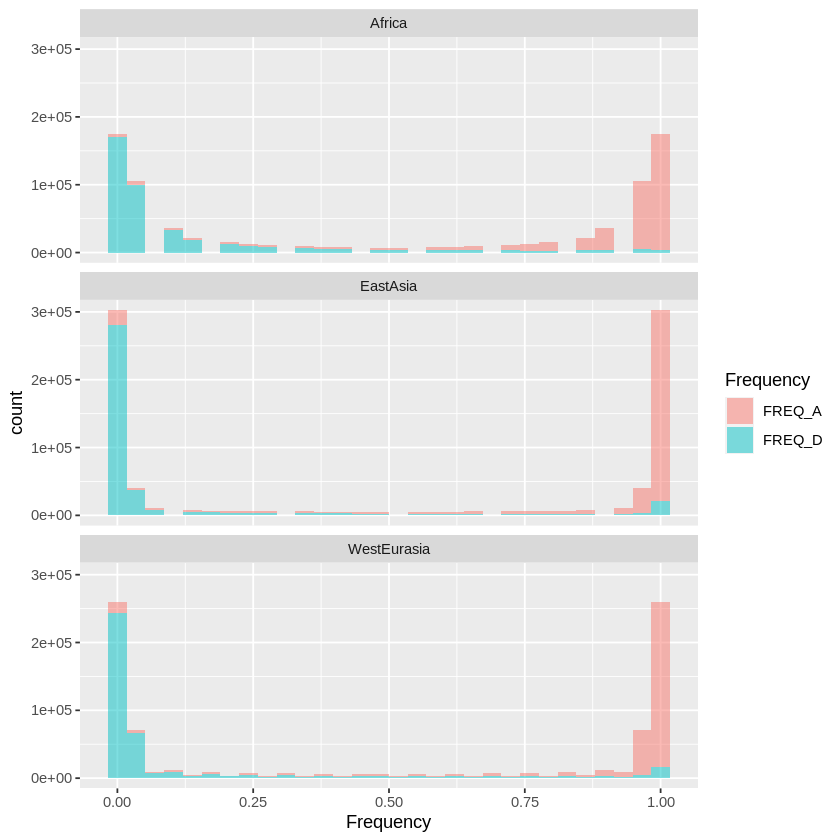

In [71]:
res.scan_three_pop <- res.scan %>% filter(region == 'Africa' | region == 'EastAsia' | region == 'WestEurasia')
freq_plot <- res.scan_three_pop  %>% select(FREQ_A, FREQ_D, region) %>% 
    pivot_longer(cols = c(FREQ_A, FREQ_D), names_to = "Frequency")  %>% 
    ggplot() + geom_histogram(aes(x = value, fill = Frequency), bins = 30, alpha = 0.5) + 
    facet_wrap(~region, nrow = 3)+xlab('Frequency')

freq_plot


The next step is to calculate Hs, Ht and following from that Fst for each position. I have written the following function to calculate those statistics per position:  

In [97]:
fst_each_pos <- function(res.scan, populations){
    chr <- NULL
    pos <- NULL
    HS <- NULL
    HT <- NULL
    Fst <- NULL
    res_scan_populations <- res.scan %>% filter(region %in% populations)
    
    for (i in 1:(nrow(SNPS))){
        chr[i] = SNPS$chr[i]
        pos[i] = SNPS$pos[i]
        subset <- res_scan_populations %>% filter(pos == pos[i])
        HS[i] = mean(2*subset$FREQ_A*subset$FREQ_D)
        HT[i] = 2*mean(subset$FREQ_A)*mean(subset$FREQ_D)
        Fst[i] = (HT[i] - HS[i])/HT[i]
    }
    
    Fst <- tibble(chr = chr,
                  pos = pos,
                  HS = HS,
                  HT = HT,
                  Fst = Fst)
    
    return(Fst)
}

In [ ]:
##I calculate that for every possible combination of populations and save it as a file: 
#Africa and Westeurasia
Fst_AF_WE_per_pos <- fst_each_pos(res.scan, c("Africa", "WestEurasia"))
head(Fst_AF_WE_per_pos)
write.csv(Fst_AF_WE_per_pos, "Fst_AF_WE_per_pos.csv")

#Europe and East Asia
Fst_WE_EA_per_pos <- fst_each_pos(res.scan, c("WestEurasia", "EastAsia"))
head(Fst_WE_EA_per_pos)
write.csv(Fst_WE_EA_per_pos, "Fst_WE_EA_per_pos.csv")

#East Asia and Africa.
Fst_EA_AF_per_pos <- fst_each_pos(res.scan, c("EastAsia", "Africa"))
head(Fst_EA_AF_per_pos)
write.csv(Fst_EA_AF_per_pos, "Fst_EA_AF_per_pos.csv")

#Africa and America
Fst_AF_AM_per_pos <- fst_each_pos(res.scan, c("Africa", "America"))
head(Fst_AF_AM_per_pos)
write.csv(Fst_AF_AM_per_pos, "Fst_AF_AM_per_pos.csv")

#Africa and Central
Fst_AF_CAS_per_pos <- fst_each_pos(res.scan, c("Africa", "CentralAsiaSiberia"))
head(Fst_AF_CAS_per_pos)
write.csv(Fst_AF_CAS_per_pos, "Fst_AF_CAS_per_pos.csv")

#Africa and Oceania
Fst_AF_O_per_pos <- fst_each_pos(res.scan, c("Africa", "Oceania"))
head(Fst_AF_O_per_pos)
write.csv(Fst_AF_O_per_pos, "Fst_AF_O_per_pos.csv")

#Africa and South Asia
Fst_AF_SA_per_pos <- fst_each_pos(res.scan, c("Africa", "SouthAsia"))
head(Fst_AF_SA_per_pos)
write.csv(Fst_AF_SA_per_pos, "Fst_AF_SA_per_pos.csv")

#America and CAS
Fst_AM_CAS_per_pos <- fst_each_pos(res.scan, c("America", "CentralAsiaSiberia"))
head(Fst_AM_CAS_per_pos)
write.csv(Fst_AM_CAS_per_pos, "Fst_AM_CAS_per_pos.csv")

#America and East Asia
Fst_AM_EA_per_pos <- fst_each_pos(res.scan, c("America", "EastAsia"))
head(Fst_AM_EA_per_pos)
write.csv(Fst_AM_EA_per_pos, "Fst_AM_EA_per_pos.csv")

#America and Oceania
Fst_AM_O_per_pos <- fst_each_pos(res.scan, c("America", "Oceania"))
head(Fst_AM_O_per_pos)
write.csv(Fst_AM_O_per_pos, "Fst_AM_O_per_pos.csv")

#America and South Asia
Fst_AM_SA_per_pos <- fst_each_pos(res.scan, c("America", "SouthAsia"))
head(Fst_AM_SA_per_pos)
write.csv(Fst_AM_SA_per_pos, "Fst_AM_SA_per_pos.csv")

#America and West Eurasia
Fst_AM_WE_per_pos <- fst_each_pos(res.scan, c("America", "WestEurasia"))
head(Fst_AM_WE_per_pos)
write.csv(Fst_AM_WE_per_pos, "Fst_AM_WE_per_pos.csv")

#CAS and East Asia
Fst_CAS_EA_per_pos <- fst_each_pos(res.scan, c("CentralAsiaSiberia", "EastAsia"))
head(Fst_CAS_EA_per_pos)
write.csv(Fst_CAS_EA_per_pos, "Fst_CAS_EA_per_pos.csv")

#CAS and Oceania
Fst_CAS_O_per_pos <- fst_each_pos(res.scan, c("CentralAsiaSiberia", "Oceania"))
head(Fst_CAS_O_per_pos)
write.csv(Fst_CAS_O_per_pos, "Fst_CAS_O_per_pos.csv")

#CAS and South Asia
Fst_CAS_SA_per_pos <- fst_each_pos(res.scan, c("CentralAsiaSiberia", "SouthAsia"))
head(Fst_CAS_SA_per_pos)
write.csv(Fst_CAS_SA_per_pos, "Fst_CAS_SA_per_pos.csv")

#CAS and West Eurasia
Fst_CAS_WE_per_pos <- fst_each_pos(res.scan, c("CentralAsiaSiberia", "WestEurasia"))
head(Fst_CAS_WE_per_pos)
write.csv(Fst_CAS_WE_per_pos, "Fst_CAS_WE_per_pos.csv")

#East Asia and Oceania
Fst_EA_O_per_pos <- fst_each_pos(res.scan, c("EastAsia", "Oceania"))
head(Fst_EA_O_per_pos)
write.csv(Fst_EA_O_per_pos, "Fst_EA_O_per_pos.csv")

#East Asia and South Asia
Fst_EA_SA_per_pos <- fst_each_pos(res.scan, c("EastAsia", "SouthAsia"))
head(Fst_EA_SA_per_pos)
write.csv(Fst_EA_SA_per_pos, "Fst_EA_SA_per_pos.csv")

#Oceania and South Asia
Fst_O_SA_per_pos <- fst_each_pos(res.scan, c("Oceania", "SouthAsia"))
head(Fst_O_SA_per_pos)
write.csv(Fst_O_SA_per_pos, "Fst_O_SA_per_pos.csv")


#Oceania and West Eurasia
Fst_O_WE_per_pos <- fst_each_pos(res.scan, c("Oceania", "WestEurasia"))
head(Fst_O_WE_per_pos)
write.csv(Fst_O_WE_per_pos, "Fst_O_WE_per_pos.csv")

#South Asia and West Eurasia
Fst_SA_WE_per_pos <- fst_each_pos(res.scan, c("SouthAsia", "WestEurasia"))
head(Fst_SA_WE_per_pos)
write.csv(Fst_SA_WE_per_pos, "Fst_SA_WE_per_pos.csv")

Also those I had saved as files to read them in when working on the project: 

In [3]:
Fst_AF_WE_per_pos <- read.csv("Fst_AF_WE_per_pos.csv")
head(Fst_AF_WE_per_pos)

Fst_WE_EA_per_pos <- read.csv("Fst_WE_EA_per_pos.csv")
head(Fst_WE_EA_per_pos)

Fst_EA_AF_per_pos <- read.csv("Fst_EA_AF_per_pos.csv")
head(Fst_EA_AF_per_pos)

Fst_AF_AM_per_pos <- read.csv("Fst_AF_AM_per_pos.csv")
head(Fst_AF_AM_per_pos)

Fst_AF_CAS_per_pos <- read.csv("Fst_AF_CAS_per_pos.csv")
head(Fst_AF_CAS_per_pos)

Fst_AF_O_per_pos <- read.csv("Fst_AF_O_per_pos.csv")
head(Fst_AF_O_per_pos)

Fst_AF_SA_per_pos <- read.csv("Fst_AF_SA_per_pos.csv")
head(Fst_AF_SA_per_pos)

Fst_AM_CAS_per_pos <- read.csv("Fst_AM_CAS_per_pos.csv")
head(Fst_AM_CAS_per_pos)


Fst_AM_EA_per_pos <- read.csv("Fst_AM_EA_per_pos.csv")
head(Fst_AM_EA_per_pos)


Fst_AM_O_per_pos <- read.csv("Fst_AM_O_per_pos.csv")
head(Fst_AM_O_per_pos)


Fst_AM_SA_per_pos <- read.csv("Fst_AM_SA_per_pos.csv")
head(Fst_AM_SA_per_pos)


Fst_AM_WE_per_pos <- read.csv("Fst_AM_WE_per_pos.csv")
head(Fst_AM_WE_per_pos)


Fst_CAS_EA_per_pos <- read.csv("Fst_CAS_EA_per_pos.csv")
head(Fst_CAS_EA_per_pos)

Fst_CAS_O_per_pos <- read.csv("Fst_CAS_O_per_pos.csv")
head(Fst_CAS_O_per_pos)

Fst_CAS_SA_per_pos <- read.csv("Fst_CAS_SA_per_pos.csv")
head(Fst_CAS_SA_per_pos)

Fst_CAS_WE_per_pos <- read.csv("Fst_CAS_WE_per_pos.csv")
head(Fst_CAS_WE_per_pos)

Fst_EA_O_per_pos <- read.csv("Fst_EA_O_per_pos.csv")
head(Fst_EA_O_per_pos)

Fst_EA_SA_per_pos <- read.csv("Fst_EA_SA_per_pos")
head(Fst_EA_SA_per_pos)

Fst_O_SA_per_pos <- read.csv("Fst_O_SA_per_pos.csv")
head(Fst_O_SA_per_pos)

Fst_O_WE_per_pos <- read.csv("Fst_O_WE_per_pos.csv")
head(Fst_O_WE_per_pos)

Fst_SA_WE_per_pos <- read.csv("Fst_SA_WE_per_pos.csv")
head(Fst_SA_WE_per_pos)


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.23285147,0.47952098,0.51440816
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.46723262,0.49985008,0.06525448


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,NA
2,2,X,400000,0.0000000,0.0000000,NA
3,3,X,400108,0.4097222,0.4131944,0.008403361
4,4,X,400132,0.0000000,0.0000000,NA
5,5,X,400148,0.0000000,0.0000000,NA
6,6,X,400303,0.4657800,0.4999354,0.068319773


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.04535147,0.04648526,2.439024e-02
3,3,X,400108,0.26757370,0.45918367,4.172840e-01
4,4,X,400132,0.18140590,0.20975057,1.351351e-01
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.47020266,0.47022038,3.767472e-05


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.04535147,0.49886621,0.90909091
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.37471655,0.39767574,0.05773343


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.04535147,0.49886621,0.90909091
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.47020266,0.49998228,0.05956135


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.043478261
2,2,X,400000,0.04535147,0.04648526,0.024390244
3,3,X,400108,0.12174036,0.12237812,0.005211349
4,4,X,400132,0.18140590,0.20975057,0.135135135
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.45804989,0.45918367,0.002469136


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.28535147,0.43791383,0.34838442
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.43138322,0.43791383,0.01491301


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,NA
2,2,X,400000,0.0000000,0.0000000,NA
3,3,X,400108,0.0000000,0.0000000,NA
4,4,X,400132,0.0000000,0.0000000,NA
5,5,X,400148,0.0000000,0.0000000,NA
6,6,X,400303,0.3732639,0.4782986,0.2196007


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,NA
2,2,X,400000,0.0000000,0.0000000,NA
3,3,X,400108,0.2222222,0.2777778,0.20000000
4,4,X,400132,0.0000000,0.0000000,NA
5,5,X,400148,0.0000000,0.0000000,NA
6,6,X,400303,0.3732639,0.3949653,0.05494505


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.04347826
2,2,X,400000,0.00000000,0.00000000,NA
3,3,X,400108,0.07638889,0.49652778,0.84615385
4,4,X,400132,0.00000000,0.00000000,NA
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.36111111,0.37500000,0.03703704


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.00000000,0.00000000,NA
3,3,X,400108,0.24000000,0.32000000,0.25000000
4,4,X,400132,0.00000000,0.00000000,NA
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.33444444,0.33944444,0.01472995


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,NA
2,2,X,400000,0.0000000,0.0000000,NA
3,3,X,400108,0.1875000,0.2187500,0.1428571
4,4,X,400132,0.0000000,0.0000000,NA
5,5,X,400148,0.0000000,0.0000000,NA
6,6,X,400303,0.3702938,0.4806015,0.2295199


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,NA
2,2,X,400000,0.0000000,0.0000000,NA
3,3,X,400108,0.2222222,0.2777778,0.2000
4,4,X,400132,0.0000000,0.0000000,NA
5,5,X,400148,0.0000000,0.0000000,NA
6,6,X,400303,0.4687500,0.5000000,0.0625


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.04347826
2,2,X,400000,0.00000000,0.00000000,NA
3,3,X,400108,0.07638889,0.49652778,0.84615385
4,4,X,400132,0.00000000,0.00000000,NA
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.45659722,0.49913194,0.08521739


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,NA
2,2,X,400000,0.00000000,0.00000000,NA
3,3,X,400108,0.24000000,0.32000000,0.25000000
4,4,X,400132,0.00000000,0.00000000,NA
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.42993056,0.49413194,0.12992762


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000,0.0000000,NA
2,2,X,400000,0.00000,0.0000000,NA
3,3,X,400108,0.18750,0.2187500,0.1428571429
4,4,X,400132,0.00000,0.0000000,NA
5,5,X,400148,0.00000,0.0000000,NA
6,6,X,400303,0.46578,0.4658445,0.0001386001


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.043478261
2,2,X,400000,0.00000000,0.00000000,NA
3,3,X,400108,0.29861111,0.46875000,0.362962963
4,4,X,400132,0.00000000,0.00000000,NA
5,5,X,400148,0.00000000,0.00000000,NA
6,6,X,400303,0.45659722,0.45746528,0.001897533


Warning message in file(file, "rt"):
“cannot open file 'Fst_EA_SA_per_pos': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


The following function I wrote to calculate the mean for each sliding window of length 100: 

In [ ]:
fst_mean <- function(fst_table, windowsize = 100){
    chr <- NULL
    begin_pos_SNP <- NULL
    end_pos_SNP <- NULL
    Fst_average <- NULL
    window <- windowsize-1
    
    for (i in 1:(nrow(SNPS) - window)){
        chr[i] = SNPS$chr[i]
        begin_pos_SNP[i] = SNPS$pos[i]
        end_pos_SNP[i] = SNPS$pos[i+window]
        SNPwindow <- fst_table %>% filter(between(pos, begin_pos_SNP[i], end_pos_SNP[i]))
        SNPwindow[is.na(SNPwindow)] <- 0 
        Fst_average[i] = mean(SNPwindow$Fst)
    }
    
    Fst <- tibble(chr = chr,
                  begin_pos_SNP = begin_pos_SNP,
                  end_pos_SNP = end_pos_SNP,
                  Fst_average = Fst_average)
    
    return(Fst)
}

In [ ]:
Fst_mean_AF_WE <- fst_mean(Fst_AF_WE_per_pos)
print("Africa and West Eurasia")
head(Fst_mean_AF_WE)
write.csv(Fst_mean_AF_WE, "Fst_mean_AF_WE.csv")


Fst_mean_WE_EA <- fst_mean(Fst_WE_EA_per_pos)
print("West Eurasia and East Asia")
head(Fst_mean_WE_EA)
write.csv(Fst_mean_WE_EA, "Fst_mean_WE_EA.csv")

Fst_mean_EA_AF <- fst_mean(Fst_EA_AF_per_pos)
print("East Asia and Africa")
head(Fst_mean_EA_AF)
write.csv(Fst_mean_EA_AF, "Fst_mean_EA_AF.csv")

#Africa and America
Fst_mean_AF_AM <- fst_mean(Fst_AF_AM_per_pos)
head(Fst_mean_AF_AM)
write.csv(Fst_mean_AF_AM, "Fst_mean_AF_AM.csv")

#Africa and Central
Fst_mean_AF_CAS <- fst_mean(Fst_AF_CAS_per_pos)
head(Fst_mean_AF_CAS)
write.csv(Fst_mean_AF_CAS, "Fst_mean_AF_CAS.csv")

#Africa and Oceania
Fst_mean_AF_O <- fst_mean(Fst_AF_O_per_pos)
head(Fst_mean_AF_O)
write.csv(Fst_mean_AF_O, "Fst_mean_AF_O.csv")

#Africa and South Asia
Fst_mean_AF_SA <- fst_mean(Fst_AF_SA_per_pos)
head(Fst_mean_AF_SA)
write.csv(Fst_mean_AF_SA, "Fst_mean_AF_SA.csv")

#America and CAS
Fst_mean_AM_CAS <- fst_mean(Fst_AM_CAS_per_pos)
head(Fst_mean_AM_CAS)
write.csv(Fst_mean_AM_CAS, "Fst_mean_AM_CAS.csv")

#America and East Asia
Fst_mean_AM_EA <- fst_mean(Fst_AM_EA_per_pos)
head(Fst_mean_AM_EA)
write.csv(Fst_mean_AM_EA, "Fst_mean_AM_EA.csv")

#America and Oceania
Fst_mean_AM_O <- fst_mean(Fst_AM_O_per_pos)
head(Fst_mean_AM_O)
write.csv(Fst_mean_AM_O, "Fst_mean_AM_O.csv")

#America and South Asia
Fst_mean_AM_SA <- fst_mean(Fst_AM_SA_per_pos)
head(Fst_mean_AM_SA)
write.csv(Fst_mean_AM_SA, "Fst_mean_AM_SA.csv")

#America and West Eurasia
Fst_mean_AM_WE <- fst_mean(Fst_AM_WE_per_pos)
head(Fst_mean_AM_WE)
write.csv(Fst_mean_AM_WE, "Fst_mean_AM_WE.csv")

#CAS and East Asia
Fst_mean_CAS_EA <- fst_mean(Fst_CAS_EA_per_pos)
head(Fst_mean_CAS_EA)
write.csv(Fst_mean_CAS_EA, "Fst_mean_CAS_EA.csv")

#CAS and Oceania
Fst_mean_CAS_O <- fst_mean(Fst_CAS_O_per_pos)
head(Fst_mean_CAS_O)
write.csv(Fst_mean_CAS_O, "Fst_mean_CAS_O.csv")

#CAS and South Asia
Fst_mean_CAS_SA <- fst_mean(Fst_CAS_SA_per_pos)
head(Fst_mean_CAS_SA)
write.csv(Fst_mean_CAS_SA, "Fst_mean_CAS_SA.csv")

#CAS and West Eurasia
Fst_mean_CAS_WE <- fst_mean(Fst_CAS_WE_per_pos)
head(Fst_mean_CAS_WE)
write.csv(Fst_mean_CAS_WE, "Fst_mean_CAS_WE.csv")

#East Asia and Oceania
Fst_mean_EA_O <- fst_mean(Fst_EA_O_per_pos)
head(Fst_mean_EA_O)
write.csv(Fst_mean_EA_O, "Fst_mean_EA_O.csv")

#East Asia and South Asia
Fst_mean_EA_SA <- fst_mean(Fst_EA_SA_per_pos)
head(Fst_mean_EA_SA)
write.csv(Fst_mean_EA_SA, "Fst_mean_EA_SA.csv")

#Oceania and South Asia
Fst_mean_O_SA <- fst_mean(Fst_O_SA_per_pos)
head(Fst_mean_O_SA)
write.csv(Fst_mean_O_SA, "Fst_mean_O_SA.csv")


#Oceania and West Eurasia
Fst_mean_O_WE <- fst_mean(Fst_O_WE_per_pos)
head(Fst_mean_O_WE)
write.csv(Fst_mean_O_WE, "Fst_mean_O_WE.csv")

#South Asia and West Eurasia
Fst_mean_SA_WE <- fst_mean(Fst_SA_WE_per_pos)
head(Fst_mean_SA_WE)
write.csv(Fst_mean_SA_WE, "Fst_mean_SA_WE.csv")

Also these files I saved as files, but for the following analysis I only need three of the population combinations. The other combination I will use in exercise E. 

In [26]:
Fst_mean_AF_WE <- read.csv("Fst_mean_AF_WE.csv")
Fst_mean_AF_WE <- Fst_mean_AF_WE %>% mutate(region = rep("Africa_WestEurasia", nrow(Fst_mean_AF_WE)))
Fst_mean_WE_EA <- read.csv("Fst_mean_WE_EA.csv")
Fst_mean_WE_EA <- Fst_mean_WE_EA %>% mutate(region = rep("WestEurasia_EastAsia", nrow(Fst_mean_WE_EA)))
Fst_mean_EA_AF <- read.csv("Fst_mean_EA_AF.csv")
Fst_mean_EA_AF <- Fst_mean_EA_AF %>% mutate(region = rep("EastAsia_Africa", nrow(Fst_mean_EA_AF)))

To get an overview of the distribution I make a plot of the Fst values for each window. Below both plots for all three populations combined in one plot and one population at a time can be seen. 

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,1,X,365712,452218,0.04586912,Africa_WestEurasia
2,2,X,400000,452221,0.04586912,Africa_WestEurasia
3,3,X,400108,452231,0.04562522,Africa_WestEurasia
4,4,X,400132,454014,0.04072504,Africa_WestEurasia
5,5,X,400148,454116,0.03937369,Africa_WestEurasia
6,6,X,400303,454355,0.03937369,Africa_WestEurasia


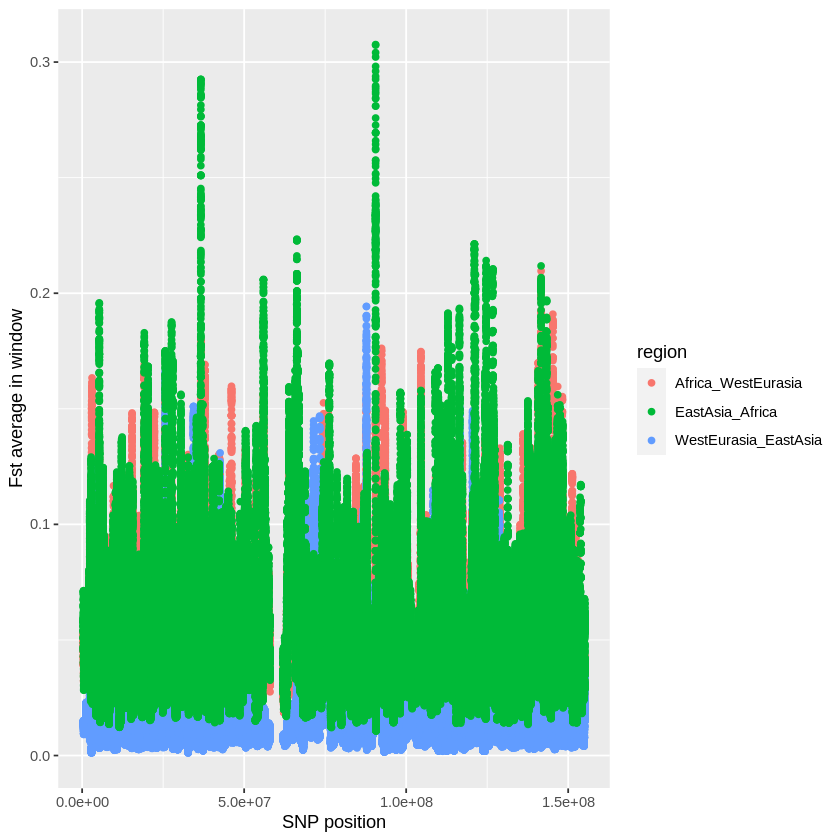

In [6]:
#Plot with the three populations combined:  
Fst_av <- bind_rows(Fst_mean_AF_WE, Fst_mean_WE_EA, Fst_mean_EA_AF)
head(Fst_av)
plot1 <- ggplot(Fst_av)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average, color = region))+xlab('SNP position')+
ylab('Fst average in window') 
plot1

[1] "Africa and West Eurasia"
[1] "West Eurasia and East Asia"


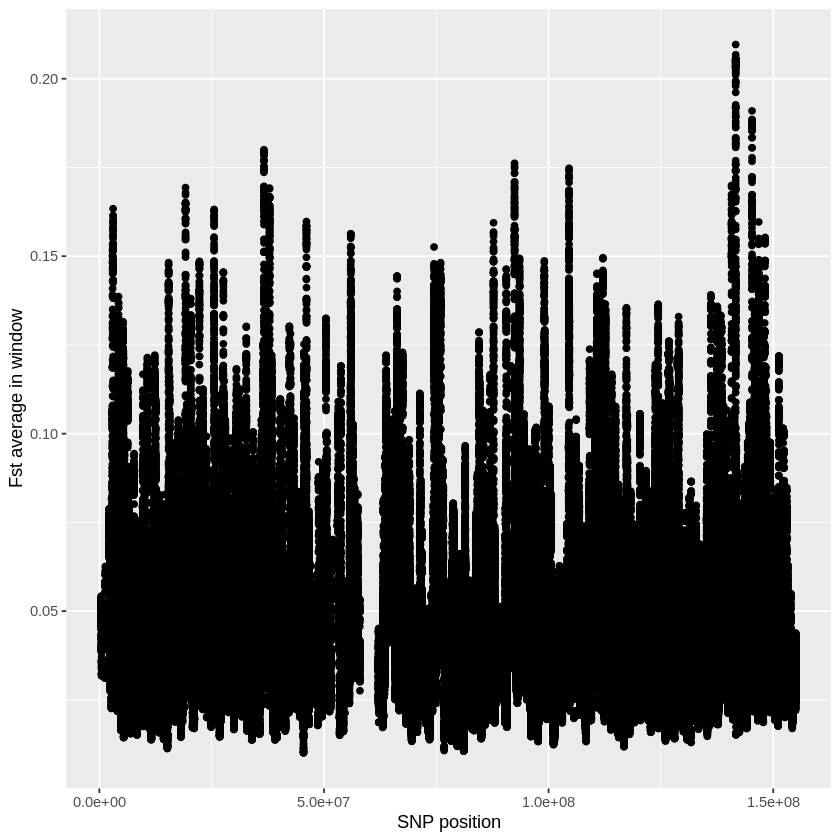

[1] "East Asia and Africa"


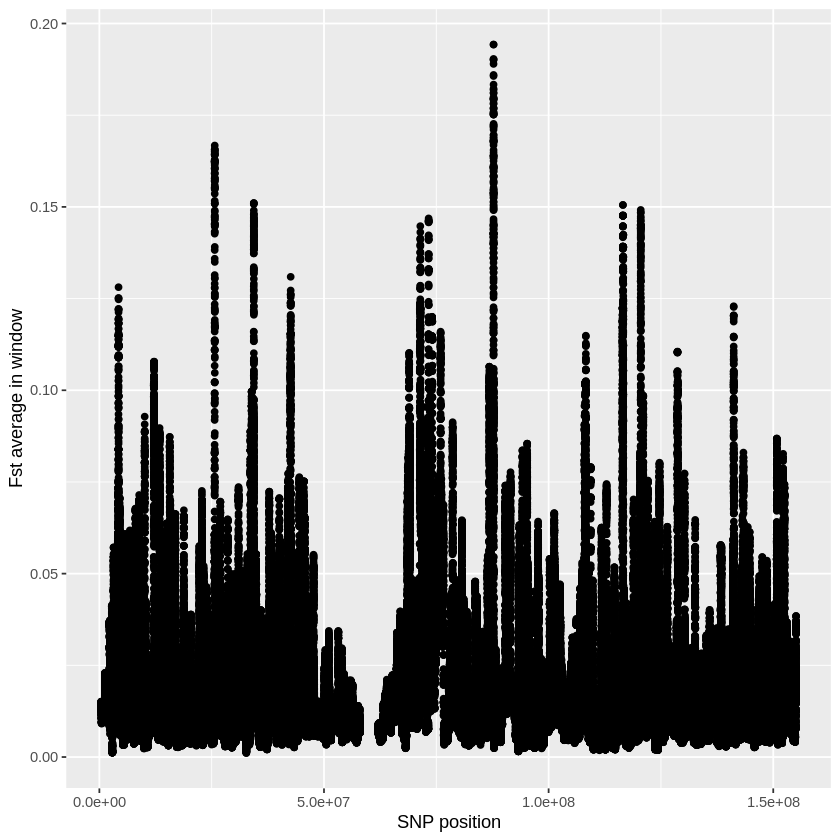

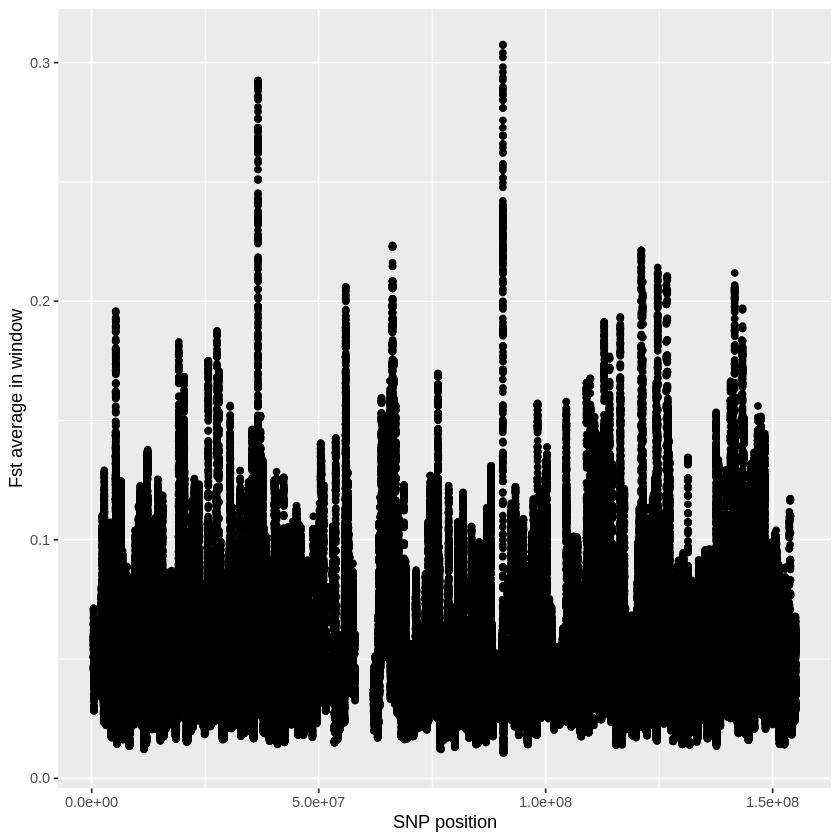

In [7]:
#Plots for one population at a time: 
par(mfrow=c(2,2))
print("Africa and West Eurasia")
plot_AF_WE <- ggplot(Fst_mean_AF_WE)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))+xlab('SNP position')+
ylab('Fst average in window') 
plot_AF_WE

print("West Eurasia and East Asia")
plot_WE_EA <- ggplot(Fst_mean_WE_EA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))+xlab('SNP position')+
ylab('Fst average in window') 
plot_WE_EA

print("East Asia and Africa")
plot_EA_AF <- ggplot(Fst_mean_EA_AF)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))+xlab('SNP position')+
ylab('Fst average in window') 
plot_EA_AF

Now I try to define the outlier regions. The goal was to find 10 regions that are outliers. My appraoch was to sort the values, and then take the regions with the highest Fsts as the outliers. At the same time, I plottet them. I made different plots where I increased the number of values I included in the new data frame, and each time I made a plot. On the plots I could see that there are many of the same regions that are covered by the same top 100 for example. That means that I was only able to qualify xx regions as  outliers. The regions with the next highest Fst values where not significantly different from the other regions.  

In [9]:
#Sorting the table according to the Fst values 
descending_order_AF_WE <- Fst_mean_AF_WE %>% dplyr::arrange(desc(Fst_average))
head(descending_order_AF_WE)

descending_order_WE_EA <- Fst_mean_WE_EA %>% dplyr::arrange(desc(Fst_average))
head(descending_order_WE_EA)

descending_order_AF_EA <- Fst_mean_EA_AF %>% dplyr::arrange(desc(Fst_average))
head(descending_order_AF_EA)

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373259,X,141639408,141650485,0.2096135,Africa_WestEurasia
2,373278,X,141641747,141654883,0.2067538,Africa_WestEurasia
3,373258,X,141638643,141650461,0.2057316,Africa_WestEurasia
4,373269,X,141640312,141652613,0.2056843,Africa_WestEurasia
5,373277,X,141641500,141654874,0.2056721,Africa_WestEurasia
6,373275,X,141640842,141654384,0.2053991,Africa_WestEurasia


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,229452,X,87742035,87756551,0.1942628,WestEurasia_EastAsia
2,229453,X,87742039,87756621,0.1942628,WestEurasia_EastAsia
3,229451,X,87742003,87756550,0.1903492,WestEurasia_EastAsia
4,229454,X,87742064,87756736,0.1901365,WestEurasia_EastAsia
5,229455,X,87742329,87756743,0.1901106,WestEurasia_EastAsia
6,229450,X,87741737,87756362,0.1889765,WestEurasia_EastAsia


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373259,X,141639408,141650485,0.2096135,Africa_WestEurasia
2,373278,X,141641747,141654883,0.2067538,Africa_WestEurasia
3,373258,X,141638643,141650461,0.2057316,Africa_WestEurasia
4,373269,X,141640312,141652613,0.2056843,Africa_WestEurasia
5,373277,X,141641500,141654874,0.2056721,Africa_WestEurasia
6,373275,X,141640842,141654384,0.2053991,Africa_WestEurasia


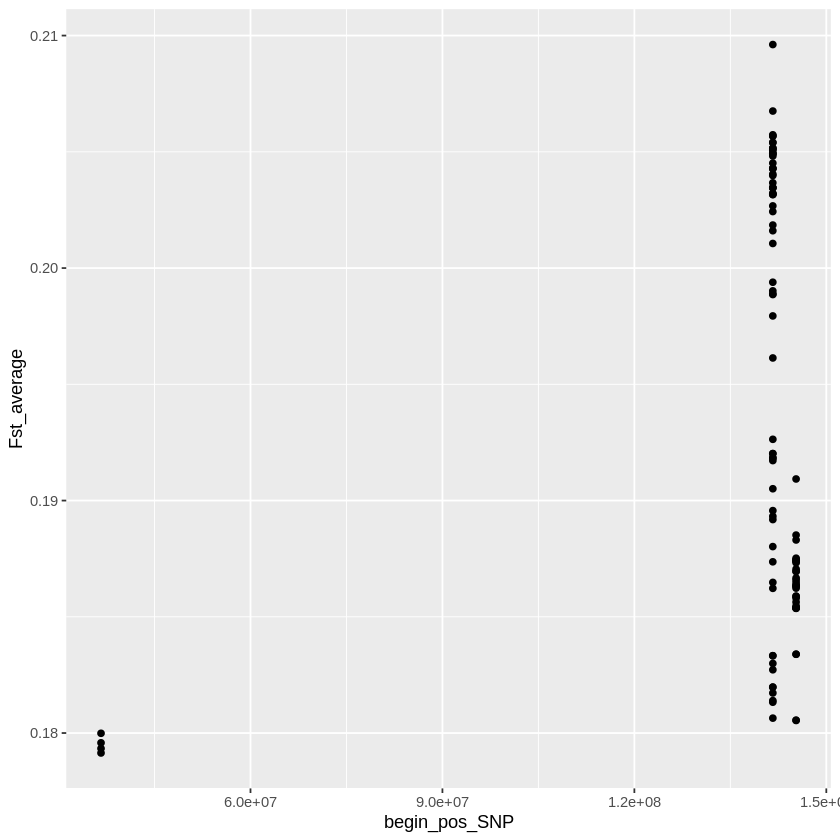

In [39]:
#100 most extreme Fst values Africa and West Eurasia
plotdata_AF_WE_100 <- descending_order_AF_WE[1:100,]
print("Africa and West Eurasia")
plot_AF_WE_100 <- ggplot(plotdata_AF_WE_100)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_WE_100
head(plotdata_AF_WE_100)


AF_WE_beddata <- plotdata_AF_WE_100 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_beddata <- AF_WE_beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_beddata))) 
AF_WE_beddata <- AF_WE_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_beddata, "AF_WE_beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373259,X,141639408,141650485,0.2096135,Africa_WestEurasia
2,373278,X,141641747,141654883,0.2067538,Africa_WestEurasia
3,373258,X,141638643,141650461,0.2057316,Africa_WestEurasia
4,373269,X,141640312,141652613,0.2056843,Africa_WestEurasia
5,373277,X,141641500,141654874,0.2056721,Africa_WestEurasia
6,373275,X,141640842,141654384,0.2053991,Africa_WestEurasia


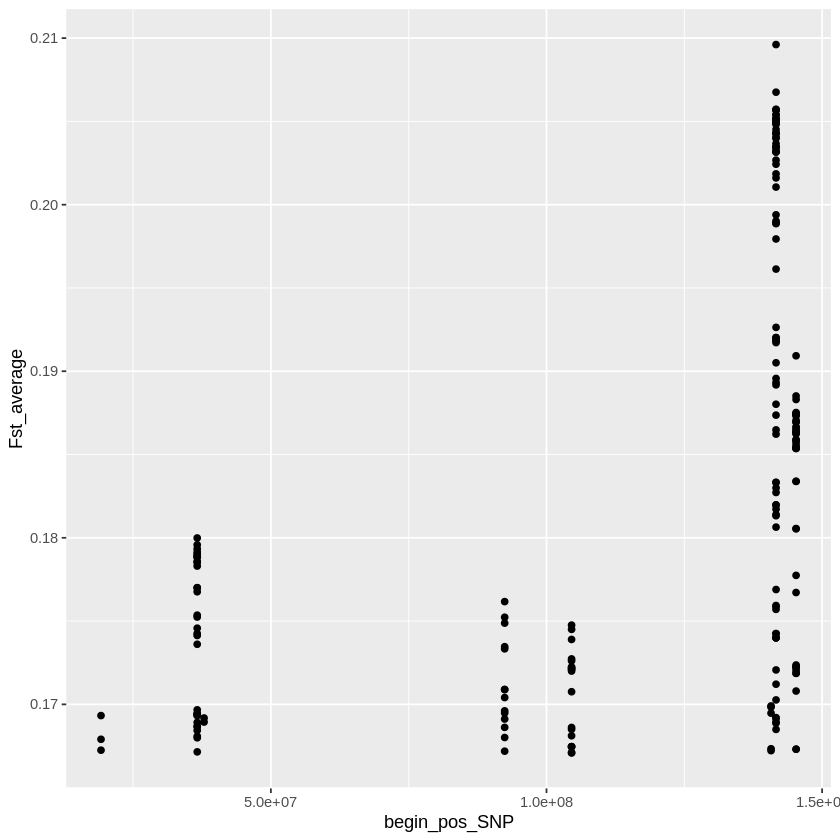

In [40]:
#200 most extreme Fst values Africa and West Eurasia
plotdata_AF_WE_200 <- descending_order_AF_WE[1:200,]
print("Africa and West Eurasia")
plot_AF_WE_200 <- ggplot(plotdata_AF_WE_200)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_WE_200
head(plotdata_AF_WE_200)


AF_WE_beddata <- plotdata_AF_WE_200 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_beddata <- AF_WE_beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_beddata))) 
AF_WE_beddata <- AF_WE_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_beddata, "AF_WE_beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373259,X,141639408,141650485,0.2096135,Africa_WestEurasia
2,373278,X,141641747,141654883,0.2067538,Africa_WestEurasia
3,373258,X,141638643,141650461,0.2057316,Africa_WestEurasia
4,373269,X,141640312,141652613,0.2056843,Africa_WestEurasia
5,373277,X,141641500,141654874,0.2056721,Africa_WestEurasia
6,373275,X,141640842,141654384,0.2053991,Africa_WestEurasia


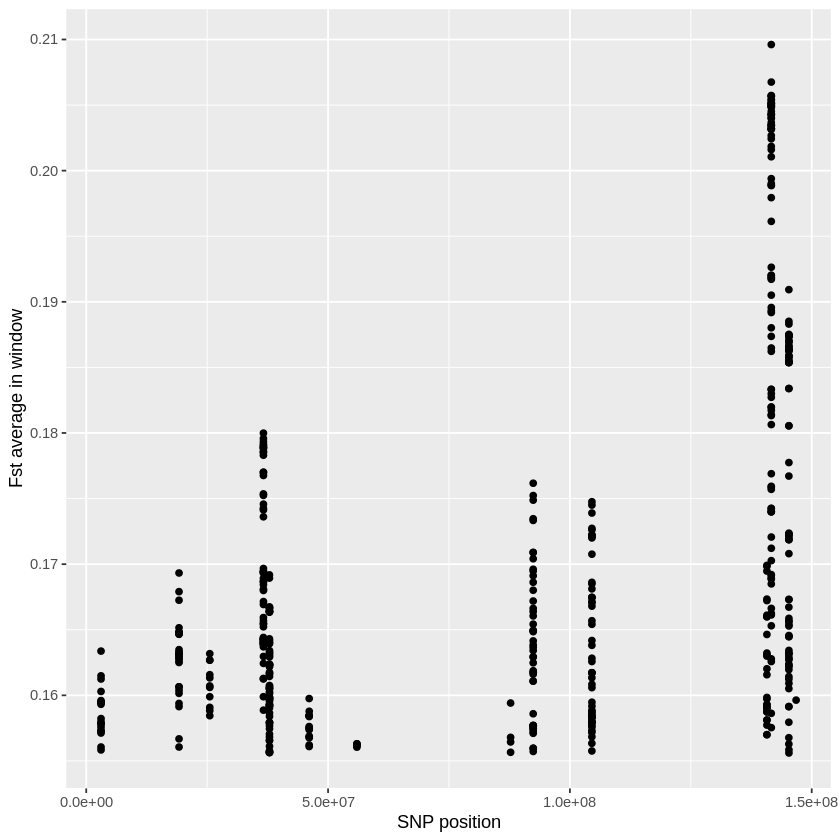

In [10]:
#500 most extreme Fst values Africa and West Eurasia
plotdata_AF_WE_500 <- descending_order_AF_WE[1:500,]
print("Africa and West Eurasia")
plot_AF_WE_500 <- ggplot(plotdata_AF_WE_500)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))+xlab('SNP position')+
ylab('Fst average in window') 
plot_AF_WE_500
head(plotdata_AF_WE_500)


AF_WE_beddata <- plotdata_AF_WE_500 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_beddata <- AF_WE_beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_beddata))) 
AF_WE_beddata <- AF_WE_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_beddata, "AF_WE_beddata_500.bed", delim = "\t", col_names = FALSE)

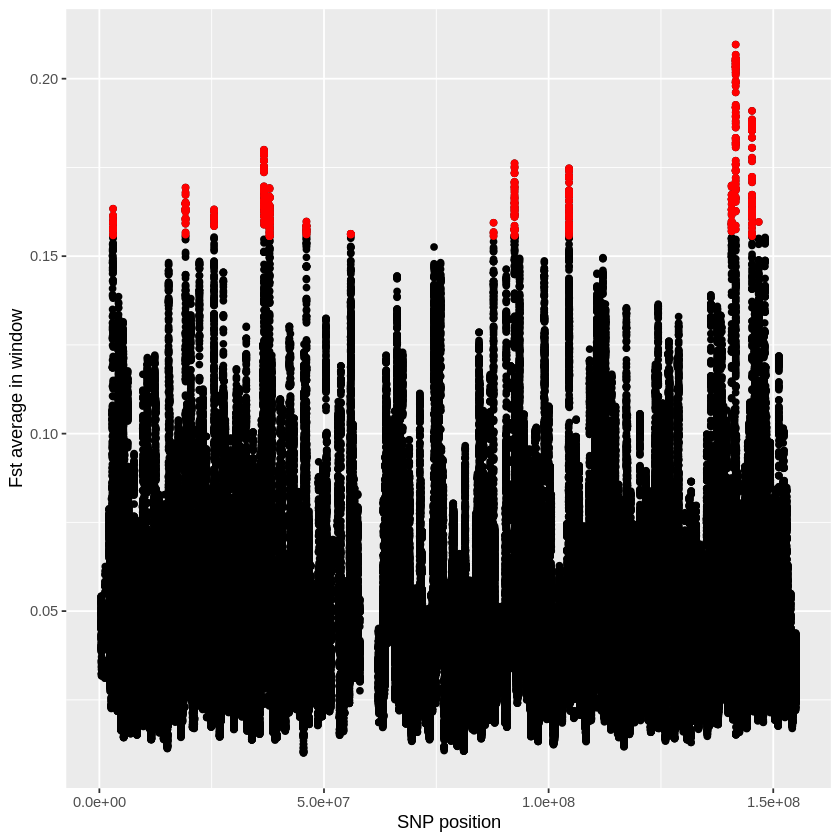

In [17]:
plot_AF_WE <- ggplot()+ 
geom_point(aes(x = Fst_mean_AF_WE$begin_pos_SNP, y= Fst_mean_AF_WE$Fst_average))+ 
geom_point(aes(x = plotdata_AF_WE_500$begin_pos_SNP, y= plotdata_AF_WE_500$Fst_average), color = 'red')+
xlab('SNP position')+
ylab('Fst average in window') 
plot_AF_WE

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,229452,X,87742035,87756551,0.1942628,WestEurasia_EastAsia
2,229453,X,87742039,87756621,0.1942628,WestEurasia_EastAsia
3,229451,X,87742003,87756550,0.1903492,WestEurasia_EastAsia
4,229454,X,87742064,87756736,0.1901365,WestEurasia_EastAsia
5,229455,X,87742329,87756743,0.1901106,WestEurasia_EastAsia
6,229450,X,87741737,87756362,0.1889765,WestEurasia_EastAsia


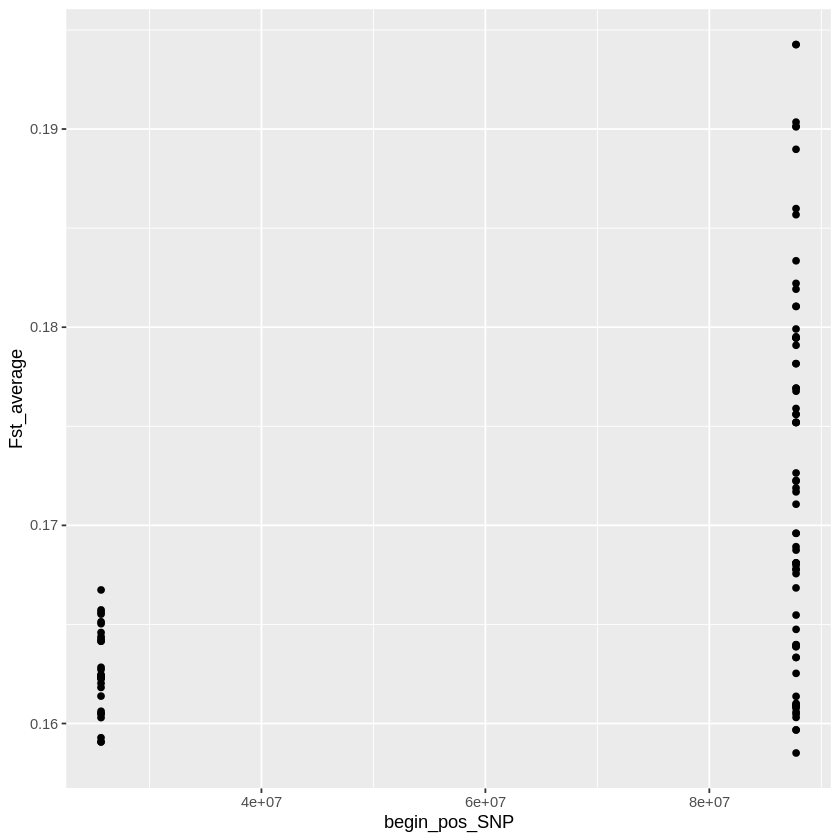

In [42]:
#100 most extreme Fst values West Eurasia and East Asia
plotdata_WE_EA_100 <- descending_order_WE_EA[1:100,]
print("West Eurasia and East Asia")
plot_WE_EA_100 <- ggplot(plotdata_WE_EA_100)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_WE_EA_100
head(plotdata_WE_EA_100)


WE_EA_beddata <- plotdata_WE_EA_100 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_beddata <- WE_EA_beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_beddata))) 
WE_EA_beddata <- WE_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_beddata, "WE_EA_beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,229452,X,87742035,87756551,0.1942628,WestEurasia_EastAsia
2,229453,X,87742039,87756621,0.1942628,WestEurasia_EastAsia
3,229451,X,87742003,87756550,0.1903492,WestEurasia_EastAsia
4,229454,X,87742064,87756736,0.1901365,WestEurasia_EastAsia
5,229455,X,87742329,87756743,0.1901106,WestEurasia_EastAsia
6,229450,X,87741737,87756362,0.1889765,WestEurasia_EastAsia


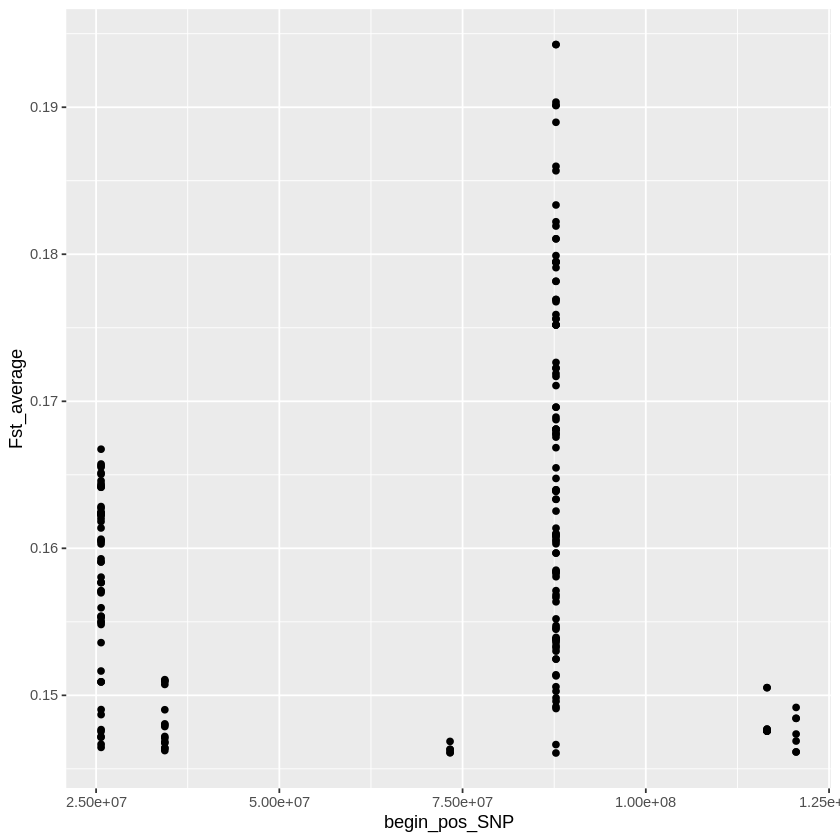

In [43]:
#200 most extreme Fst values West Eurasia and East Asia
plotdata_WE_EA_200 <- descending_order_WE_EA[1:200,]
print("West Eurasia and East Asia")
plot_WE_EA_200 <- ggplot(plotdata_WE_EA_200)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))

plot_WE_EA_200
head(plotdata_WE_EA_200)


WE_EA_beddata <- plotdata_WE_EA_200 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_beddata <- WE_EA_beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_beddata))) 
WE_EA_beddata <- WE_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_beddata, "WE_EA_beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,229452,X,87742035,87756551,0.1942628,WestEurasia_EastAsia
2,229453,X,87742039,87756621,0.1942628,WestEurasia_EastAsia
3,229451,X,87742003,87756550,0.1903492,WestEurasia_EastAsia
4,229454,X,87742064,87756736,0.1901365,WestEurasia_EastAsia
5,229455,X,87742329,87756743,0.1901106,WestEurasia_EastAsia
6,229450,X,87741737,87756362,0.1889765,WestEurasia_EastAsia


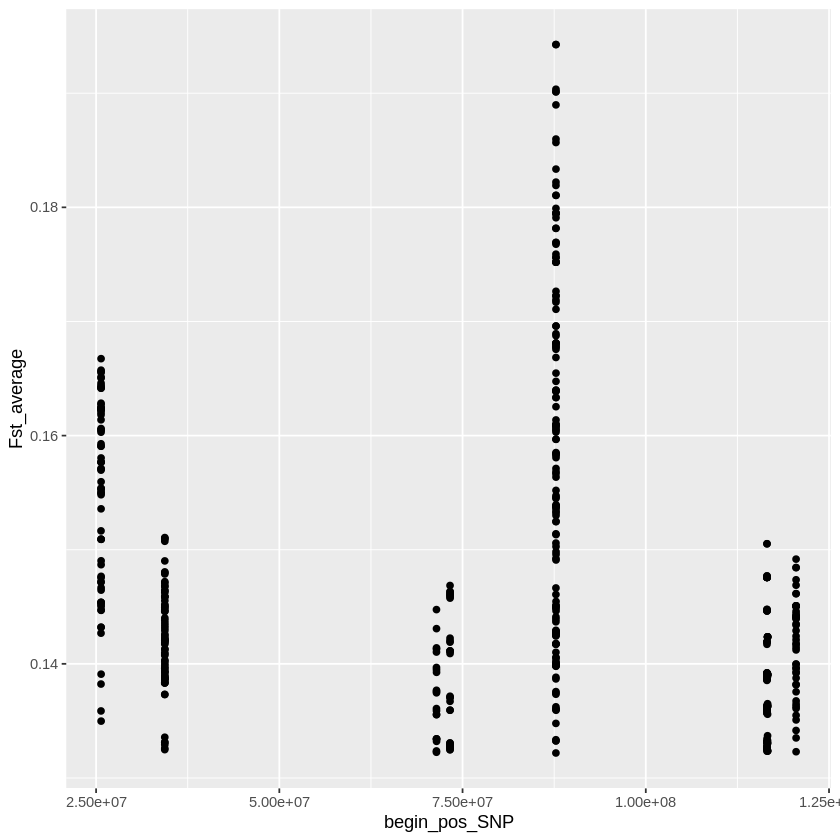

In [22]:
#500 most extreme Fst values West Eurasia and East Asia
plotdata_WE_EA_500 <- descending_order_WE_EA[1:500,]
print("West Eurasia and East Asia")
plot_WE_EA_500 <- ggplot(plotdata_WE_EA_500)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_WE_EA_500
head(plotdata_WE_EA_500)


WE_EA_beddata <- plotdata_WE_EA_500 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_beddata <- WE_EA_beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_beddata))) 
WE_EA_beddata <- WE_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_beddata, "WE_EA_beddata_500.bed", delim = "\t", col_names = FALSE)

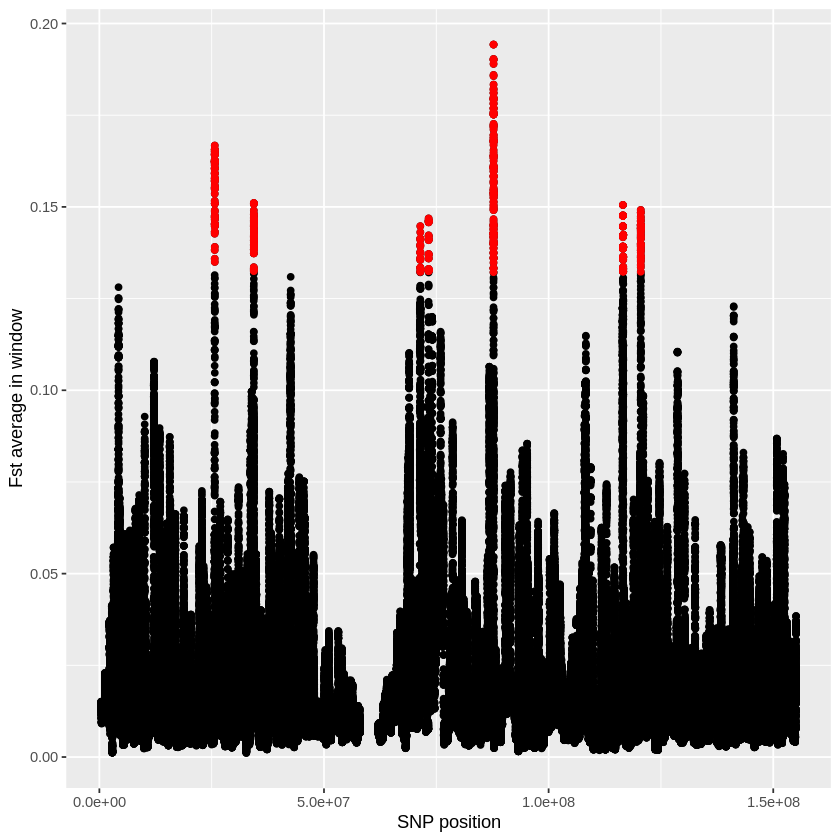

In [31]:
plot_WE_EA <- ggplot()+ 
geom_point(aes(x = Fst_mean_WE_EA$begin_pos_SNP, y= Fst_mean_WE_EA$Fst_average))+ 
geom_point(aes(x = plotdata_WE_EA_500$begin_pos_SNP, y= plotdata_WE_EA_500$Fst_average), color = 'red')+
xlab('SNP position')+
ylab('Fst average in window') 
plot_WE_EA

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


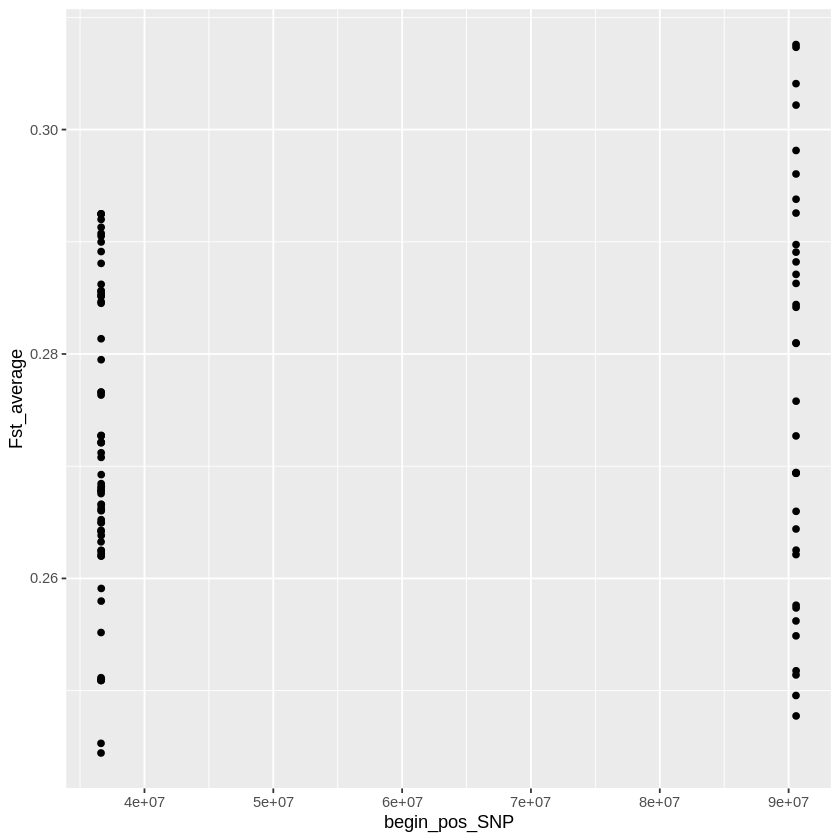

In [45]:
#100 most extreme Fst values Africa and East Asia
plotdata_AF_EA_100 <- descending_order_AF_EA[1:100,]
print("Africa and East Asia")
plot_AF_EA_100 <- ggplot(plotdata_AF_EA_100)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_EA_100
head(plotdata_AF_EA_100)


AF_EA_beddata <- plotdata_AF_EA_100 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_beddata <- AF_EA_beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_beddata))) 
AF_EA_beddata <- AF_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_beddata, "AF_EA_beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


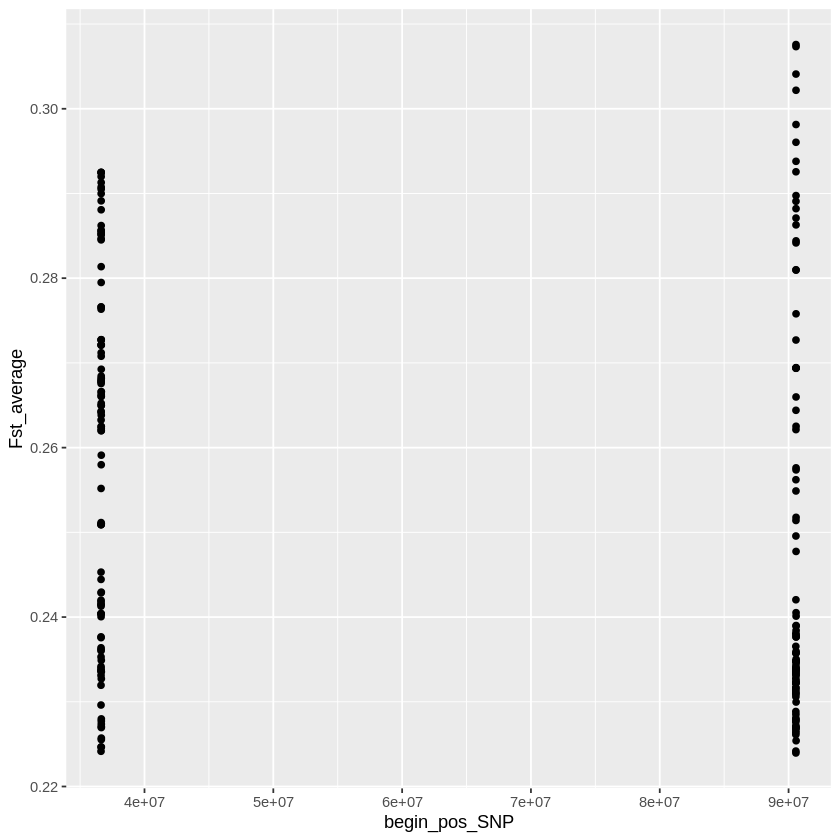

In [46]:
#200 most extreme Fst values Africa and East Asia
plotdata_AF_EA_200 <- descending_order_AF_EA[1:200,]
print("Africa and East Asia")
plot_AF_EA_200 <- ggplot(plotdata_AF_EA_200)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_EA_200
head(plotdata_AF_EA_200)


AF_EA_beddata <- plotdata_AF_EA_200 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_beddata <- AF_EA_beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_beddata))) 
AF_EA_beddata <- AF_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_beddata, "AF_EA_beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


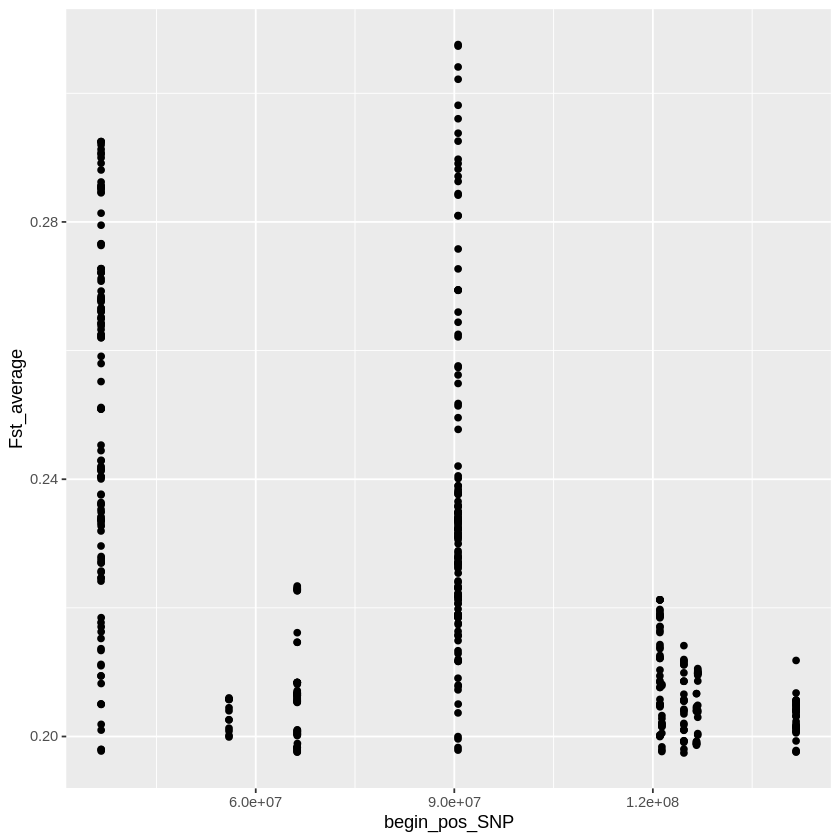

In [23]:
#500 most extreme Fst values Africa and East Asia
plotdata_AF_EA_500 <- descending_order_AF_EA[1:500,]
print("Africa and East Asia")
plot_AF_EA_500 <- ggplot(plotdata_AF_EA_500)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_EA_500
head(plotdata_AF_EA_500)


AF_EA_beddata <- plotdata_AF_EA_500 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_beddata <- AF_EA_beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_beddata))) 
AF_EA_beddata <- AF_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_beddata, "AF_EA_beddata_500.bed", delim = "\t", col_names = FALSE)

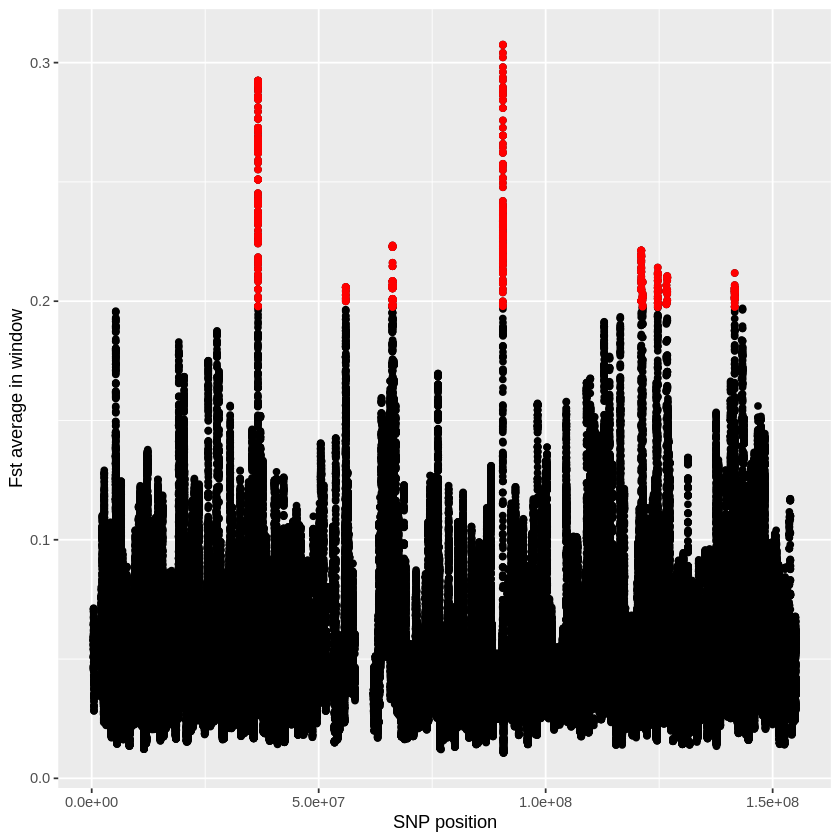

In [30]:
plot_AF_EA <- ggplot()+ 
geom_point(aes(x = Fst_mean_EA_AF$begin_pos_SNP, y= Fst_mean_EA_AF$Fst_average))+ 
geom_point(aes(x = plotdata_AF_EA_500$begin_pos_SNP, y= plotdata_AF_EA_500$Fst_average), color = 'red')+
xlab('SNP position')+
ylab('Fst average in window') 
plot_AF_EA

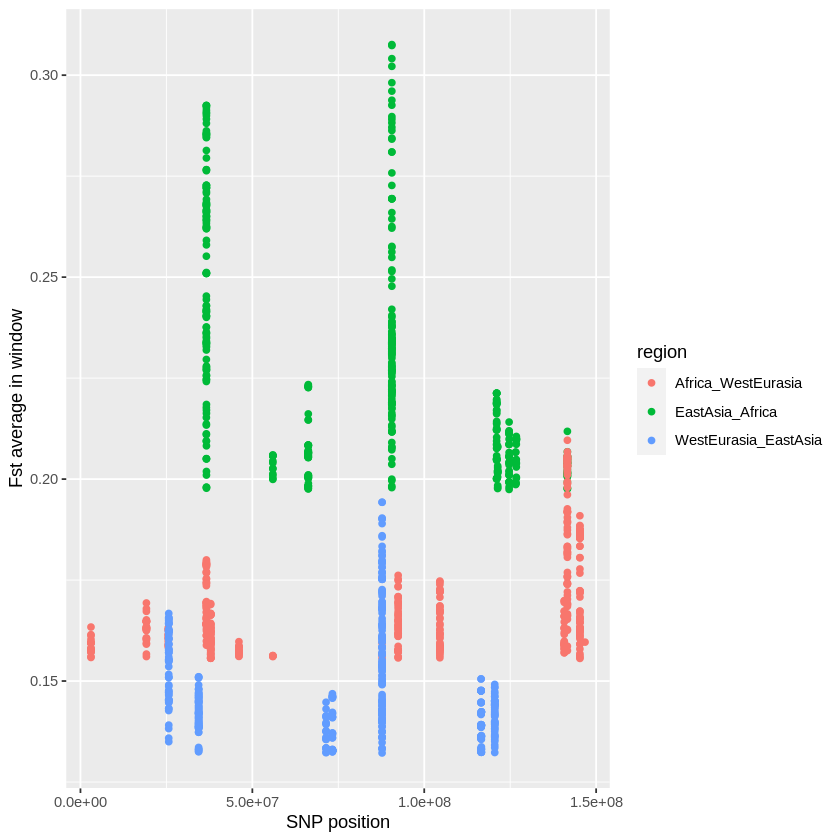

In [41]:
Fst_500_all <- bind_rows(plotdata_AF_EA_500, plotdata_AF_WE_500, plotdata_WE_EA_500)
#head(Fst_500_all)

plot_Fst_500_all <- ggplot(Fst_500_all) + geom_point(aes(x = begin_pos_SNP, y= Fst_average, color = region))+
xlab('SNP position')+
ylab('Fst average in window') 
plot_Fst_500_all

To be able to intersect the saved table with the highest Fst values and the gene annotation file, I manipulated it into a bed file in the terminal. That file only contains the X chromosome to make searching faster. The following code selects the first few rows since that are the only rows  need in the following analysis. 

In [ ]:
gencodeX  <- read.table("gencode.v30lift37.annotationX.bed", header = FALSE, sep = '\t')
head(gencodeX)

gencodeX  <- gencodeX  %>% select(V1, V2, V3, V4)
head(gencodeX)
tail(gencodeX)
write_delim(gencodeX, "gencodeX.bed", delim = "\t", col_names = FALSE)

The intersection was carried out in the terminal, using bedtools intersect function. This functions looks up for the file how it intersects with the other file, which I choose to be the gene annotation. I saved the intersected file, and that could tell me which genes were coded for in the outlier regions. The following code reads in the files I did save from the terminal. 

In [33]:
#Afrika and West Eurasia
print('Africa and West Eurasia 100')
AF_WE_100 <- read.csv('AF_WE_100.bed', sep = '\t', header = FALSE)
AF_WE_100  <- AF_WE_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_100)
genesAF_WE_100 <- unique(AF_WE_100[c("V7")])
genesAF_WE_100

print('Africa and West Eurasia 200')
AF_WE_200 <- read.csv('AF_WE_200.bed', sep = '\t', header = FALSE)
AF_WE_200  <- AF_WE_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_200)
genesAF_WE_200 <- unique(AF_WE_200[c("V7")])
genesAF_WE_200

print('Africa and West Eurasia 500')
AF_WE_500 <- read.csv('AF_WE_500.bed', sep = '\t', header = FALSE)
AF_WE_500  <- AF_WE_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_500)
genesAF_WE_500 <- unique(AF_WE_500[c("V7")])
genesAF_WE_500

#West Eurasia and East Asia
print('West Eurasia and East Asia 100')
WE_EA_100 <- read.csv('WE_EA_100.bed', sep = '\t', header = FALSE)
WE_EA_100  <- WE_EA_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_100)
genesWE_EA_100 <- unique(WE_EA_100[c("V7")])
genesWE_EA_100

print('West Eurasia and East Asia 200')
WE_EA_200 <- read.csv('WE_EA_200.bed', sep = '\t', header = FALSE)
WE_EA_200  <- WE_EA_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_200)
genesWE_EA_200 <- unique(WE_EA_200[c("V7")])
genesWE_EA_200

print('West Eurasia and East Asia 500')
WE_EA_500 <- read.csv('WE_EA_500.bed', sep = '\t', header = FALSE)
WE_EA_500  <- WE_EA_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_500)
genesWE_EA_500 <- unique(WE_EA_500[c("V7")])
genesWE_EA_500

#East Asia and Africa
print('East Asia and Africa 100')
EA_AF_100 <- read.csv('EA_AF_100.bed', sep = '\t', header = FALSE)
EA_AF_100  <- EA_AF_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_AF_100)
genesEA_AF_100 <- unique(EA_AF_100[c("V7")])
genesEA_AF_100

print('East Asia and Africa 200')
EA_AF_200 <- read.csv('EA_AF_200.bed', sep = '\t', header = FALSE)
EA_AF_200  <- EA_AF_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_AF_200)
genesEA_AF_200 <- unique(EA_AF_200[c("V7")])
genesEA_AF_200

print('East Asia and Africa 500')
EA_AF_500 <- read.csv('EA_AF_500.bed', sep = '\t', header = FALSE)
EA_AF_500  <- EA_AF_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_AF_500)
genesEA_AF_500 <- unique(EA_AF_500[c("V7")])
genesEA_AF_500

[1] "Africa and West Eurasia 100"


V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>


V7
<chr>


[1] "Africa and West Eurasia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,104551933,104578307,chrX,103810995,105011822,ENSG00000189108.12_3,26374
2,chrX,104552956,104578330,chrX,103810995,105011822,ENSG00000189108.12_3,25374
3,chrX,104549101,104575152,chrX,103810995,105011822,ENSG00000189108.12_3,26051
4,chrX,104548422,104574589,chrX,103810995,105011822,ENSG00000189108.12_3,26167
5,chrX,104548287,104574421,chrX,103810995,105011822,ENSG00000189108.12_3,26134
6,chrX,104548952,104574633,chrX,103810995,105011822,ENSG00000189108.12_3,25681


,V7
,<chr>
1,ENSG00000189108.12_3
12,ENSG00000277215.1_5
15,ENSG00000147041.12_5
16,ENSG00000221466.2
17,ENSG00000250349.3_6


[1] "Africa and West Eurasia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,104551933,104578307,chrX,103810995,105011822,ENSG00000189108.12_3,26374
2,chrX,104552956,104578330,chrX,103810995,105011822,ENSG00000189108.12_3,25374
3,chrX,104549101,104575152,chrX,103810995,105011822,ENSG00000189108.12_3,26051
4,chrX,104548422,104574589,chrX,103810995,105011822,ENSG00000189108.12_3,26167
5,chrX,104548287,104574421,chrX,103810995,105011822,ENSG00000189108.12_3,26134
6,chrX,104548952,104574633,chrX,103810995,105011822,ENSG00000189108.12_3,25681


,V7
,<chr>
1,ENSG00000189108.12_3
12,ENSG00000277215.1_5
15,ENSG00000147041.12_5
16,ENSG00000221466.2
17,ENSG00000250349.3_6
229,ENSG00000214745.2_5
230,ENSG00000227486.1_6


[1] "West Eurasia and East Asia 100"


V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>


V7
<chr>


[1] "West Eurasia and East Asia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,34376249,34397898,chrX,34224841,34433654,ENSG00000233571.1_5,21649
2,chrX,34377398,34398835,chrX,34224841,34433654,ENSG00000233571.1_5,21437
3,chrX,34376327,34398325,chrX,34224841,34433654,ENSG00000233571.1_5,21998
4,chrX,34376206,34396837,chrX,34224841,34433654,ENSG00000233571.1_5,20631
5,chrX,34376447,34398334,chrX,34224841,34433654,ENSG00000233571.1_5,21887
6,chrX,34377735,34398980,chrX,34224841,34433654,ENSG00000233571.1_5,21245


,V7
,<chr>
1,ENSG00000233571.1_5
11,ENSG00000230590.10_5
12,ENSG00000223650.1_4


[1] "West Eurasia and East Asia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,34376249,34397898,chrX,34224841,34433654,ENSG00000233571.1_5,21649
2,chrX,34377398,34398835,chrX,34224841,34433654,ENSG00000233571.1_5,21437
3,chrX,34376327,34398325,chrX,34224841,34433654,ENSG00000233571.1_5,21998
4,chrX,34376206,34396837,chrX,34224841,34433654,ENSG00000233571.1_5,20631
5,chrX,34376447,34398334,chrX,34224841,34433654,ENSG00000233571.1_5,21887
6,chrX,34377735,34398980,chrX,34224841,34433654,ENSG00000233571.1_5,21245


,V7
,<chr>
1,ENSG00000233571.1_5
11,ENSG00000230590.10_5
12,ENSG00000223650.1_4
40,ENSG00000264396.1
41,ENSG00000186871.7_5
42,ENSG00000102309.13_5
43,ENSG00000198034.11_3
47,ENSG00000265456.1
74,ENSG00000224314.1_5


[1] "East Asia and Africa 100"


V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>


V7
<chr>


[1] "East Asia and Africa 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90563242,90584159,chrX,90562779,90563877,ENSG00000206062.4_5,635
2,chrX,90563281,90584340,chrX,90562779,90563877,ENSG00000206062.4_5,596
3,chrX,90563445,90584378,chrX,90562779,90563877,ENSG00000206062.4_5,432
4,chrX,90563535,90584555,chrX,90562779,90563877,ENSG00000206062.4_5,342
5,chrX,90562804,90583816,chrX,90562779,90563877,ENSG00000206062.4_5,1073
6,chrX,90563860,90584609,chrX,90562779,90563877,ENSG00000206062.4_5,17


,V7
,<chr>
1,ENSG00000206062.4_5


[1] "East Asia and Africa 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90563242,90584159,chrX,90562779,90563877,ENSG00000206062.4_5,635
2,chrX,90563281,90584340,chrX,90562779,90563877,ENSG00000206062.4_5,596
3,chrX,90563445,90584378,chrX,90562779,90563877,ENSG00000206062.4_5,432
4,chrX,90563535,90584555,chrX,90562779,90563877,ENSG00000206062.4_5,342
5,chrX,90562804,90583816,chrX,90562779,90563877,ENSG00000206062.4_5,1073
6,chrX,90563860,90584609,chrX,90562779,90563877,ENSG00000206062.4_5,17


,V7
,<chr>
1,ENSG00000206062.4_5
19,ENSG00000260683.1_5
31,ENSG00000280142.1_5
34,ENSG00000274631.1_5
38,ENSG00000214745.2_5
39,ENSG00000227486.1_6


**Exercise B** 

Perform an iHS scan of the whole X chromosome for at least three populations. Identify the 10 most significant regions and associated with genes as in A.

In this exercise I calculate the iHS statistic. This is also done in sliding windows. As with the Fst, I first calculate the iHS per position, and after that take the mean in every sliding window. 

In [60]:
#Calculation per posistion
iHS_AF <- ihh2ihs(res.scanAF, freqbin = 0.05)
iHS_EA <- ihh2ihs(res.scanEA, freqbin = 0.05)
iHS_WE <- ihh2ihs(res.scanWE, freqbin = 0.05)

Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
279774 markers discarded.
132118 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
343097 markers discarded.
68795 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
331505 markers discarded.
80387 markers remaining.


In [62]:
#Function to calculate the mean in every sliding window
iHS_mean <- function(iHS_table, windowsize = 100){
    chr <- NULL
    begin_pos_SNP <- NULL
    end_pos_SNP <- NULL
    iHS_mean <- NULL
    window <- windowsize-1
    
    for (i in 1:(nrow(SNPS) - window)){
        chr[i] = SNPS$chr[i]
        begin_pos_SNP[i] = SNPS$pos[i]
        end_pos_SNP[i] = SNPS$pos[i+window]
        SNPwindow <- iHS_table %>% filter(between(pos, begin_pos_SNP[i], end_pos_SNP[i]))
        SNPwindow <- SNPwindow %>% drop_na()
        iHS_mean[i] = mean(SNPwindow$IHS)
    }
    
    iHS <- tibble(chr = chr,
                  begin_pos_SNP = begin_pos_SNP,
                  end_pos_SNP = end_pos_SNP,
                  iHS_mean = iHS_mean)
    
    return(iHS)
}

Because the output of the iHS function is a list of lists, I make a new data frame that only includes the iHS list. 

In [67]:
iHS_AF_new <- as.data.frame(iHS_AF$ihs)
head(iHS_AF_new)

iHS_EA_new <- as.data.frame(iHS_EA$ihs)

iHS_WE_new <- as.data.frame(iHS_WE$ihs)

,CHR,POSITION,IHS,LOGPVALUE
,<chr>,<dbl>,<dbl>,<dbl>
X:X_400132,X,400132,NA,NA
X:X_400303,X,400303,NA,NA
X:X_401651,X,401651,NA,NA
X:X_401893,X,401893,NA,NA
X:X_401894,X,401894,NA,NA
X:X_403395,X,403395,NA,NA


In [ ]:
#Calculate the iHS mean per 100 lenght sliding window for the three populations
iHS_mean_AF <- iHS_mean(iHS_AF_new)
head(iHS_mean_AF)
write.csv(iHS_mean_AF, "iHS_mean_AF.csv")

iHS_mean_EA <- iHS_mean(iHS_EA_new)
head(iHS_mean_EA)
write.csv(iHS_mean_EA, "iHS_mean_EA.csv")

iHS_mean_WE <- iHS_mean(iHS_WE_new)
head(iHS_mean_WE)
write.csv(iHS_mean_WE, "iHS_mean_WE.csv")

I also had saved these as a table, and the following code reads them in again: 

In [42]:
iHS_mean_AF <- read.csv("iHS_mean_AF.csv")
iHS_mean_EA <- read.csv("iHS_mean_EA.csv")
iHS_mean_WE <- read.csv("iHS_mean_WE.csv")

The next step is to find outlier values for iHS. I proceed in the same way as explained for the Fst, with the only exception that I take the highest and lowest values as outliers this time. 

In [43]:
#Africa 
iHS_descending_order_AF <- iHS_mean_AF %>% dplyr::arrange(desc(iHS_mean))
head(iHS_descending_order_AF)

iHS_ascending_order_AF <- iHS_mean_AF %>% dplyr::arrange(iHS_mean)
head(iHS_ascending_order_AF)

#East Asia
iHS_descending_order_EA <- iHS_mean_EA %>% dplyr::arrange(desc(iHS_mean))
head(iHS_descending_order_EA)

iHS_ascending_order_EA <- iHS_mean_EA %>% dplyr::arrange(iHS_mean)
head(iHS_ascending_order_EA)

#West Eurasia
iHS_descending_order_WE <- iHS_mean_WE %>% dplyr::arrange(desc(iHS_mean))
head(iHS_descending_order_WE)

iHS_ascending_order_WE <- iHS_mean_WE %>% dplyr::arrange(iHS_mean)
head(iHS_ascending_order_WE)

,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,299678,X,115407125,115423718,1.694851
2,299679,X,115407256,115424298,1.694851
3,299680,X,115407301,115424391,1.694851
4,299681,X,115407489,115424601,1.694851
5,299682,X,115407731,115424734,1.694851
6,299683,X,115407785,115424766,1.694851


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,370391,X,140743424,140790409,-1.488243
2,370392,X,140743573,140790458,-1.488243
3,370393,X,140743585,140790626,-1.488243
4,370394,X,140743696,140790660,-1.488243
5,370395,X,140743730,140791306,-1.488243
6,370396,X,140743898,140794185,-1.488243


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,250788,X,97250534,97274681,3.181525
2,250789,X,97250734,97274821,3.181525
3,250790,X,97250918,97275342,3.181525
4,250791,X,97251642,97275377,3.181525
5,250792,X,97252100,97275501,3.181525
6,250793,X,97252687,97275593,3.181525


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,298,X,1314388,2180815,-3.561811
2,299,X,1314594,2180854,-3.561811
3,300,X,1321732,2180957,-3.561811
4,301,X,1321749,2181324,-3.561811
5,308,X,2162893,2182221,-3.519350
6,309,X,2162898,2182305,-3.519350


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,117795,X,37711759,37734447,3.250072
2,117796,X,37711956,37734517,3.250072
3,117797,X,37712751,37734900,3.250072
4,117798,X,37712975,37734970,3.250072
5,117799,X,37713174,37735003,3.250072
6,117800,X,37713185,37735230,3.250072


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,256084,X,99182445,99208061,-2.900820
2,256085,X,99184039,99208207,-2.900820
3,151038,X,50441676,50461505,-2.854866
4,151039,X,50442253,50461508,-2.854866
5,151040,X,50442353,50461515,-2.854866
6,151041,X,50442416,50461641,-2.854866


In the next step, I calculate, plot and save the 100, 200 and 500 iHS values (composed by the top and lowest 50, 100 and 250 values, respectively). 

,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,299678,X,115407125,115423718,1.694851
2,299679,X,115407256,115424298,1.694851
3,299680,X,115407301,115424391,1.694851
4,299681,X,115407489,115424601,1.694851
5,299682,X,115407731,115424734,1.694851
6,299683,X,115407785,115424766,1.694851


[1] "Africa"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,299678,X,115407125,115423718,1.694851
2,299679,X,115407256,115424298,1.694851
3,299680,X,115407301,115424391,1.694851
4,299681,X,115407489,115424601,1.694851
5,299682,X,115407731,115424734,1.694851
6,299683,X,115407785,115424766,1.694851


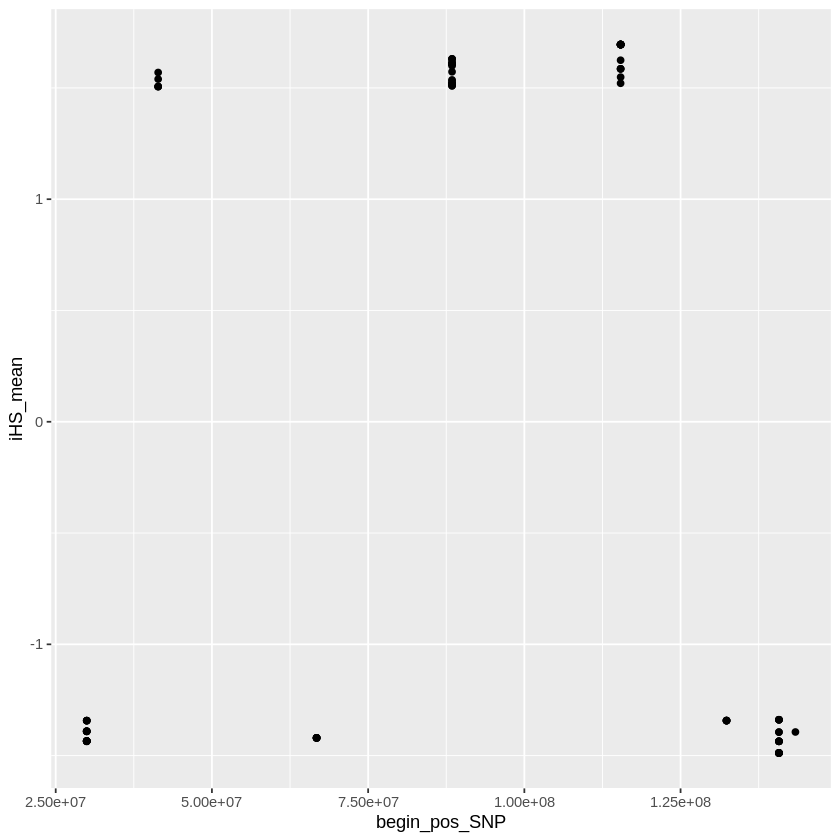

In [28]:
#100 most extreme iHS values Africa
des_100_AF <- iHS_descending_order_AF[1:50,]
asc_100_AF <- iHS_ascending_order_AF[1:50,]

plotdata_AF_iHS_100 <- bind_rows(des_100_AF, asc_100_AF)
head(plotdata_AF_iHS_100)
print("Africa")
plot_AF_iHS_100 <- ggplot(plotdata_AF_iHS_100)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_AF_iHS_100
head(plotdata_AF_iHS_100)


AF_iHS__beddata <- plotdata_AF_iHS_100 %>% select(begin_pos_SNP, end_pos_SNP)
AF_iHS__beddata <- AF_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(AF_iHS__beddata))) 
AF_iHS__beddata <- AF_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_iHS__beddata, "AF_iHS__beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "Africa"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,299678,X,115407125,115423718,1.694851
2,299679,X,115407256,115424298,1.694851
3,299680,X,115407301,115424391,1.694851
4,299681,X,115407489,115424601,1.694851
5,299682,X,115407731,115424734,1.694851
6,299683,X,115407785,115424766,1.694851


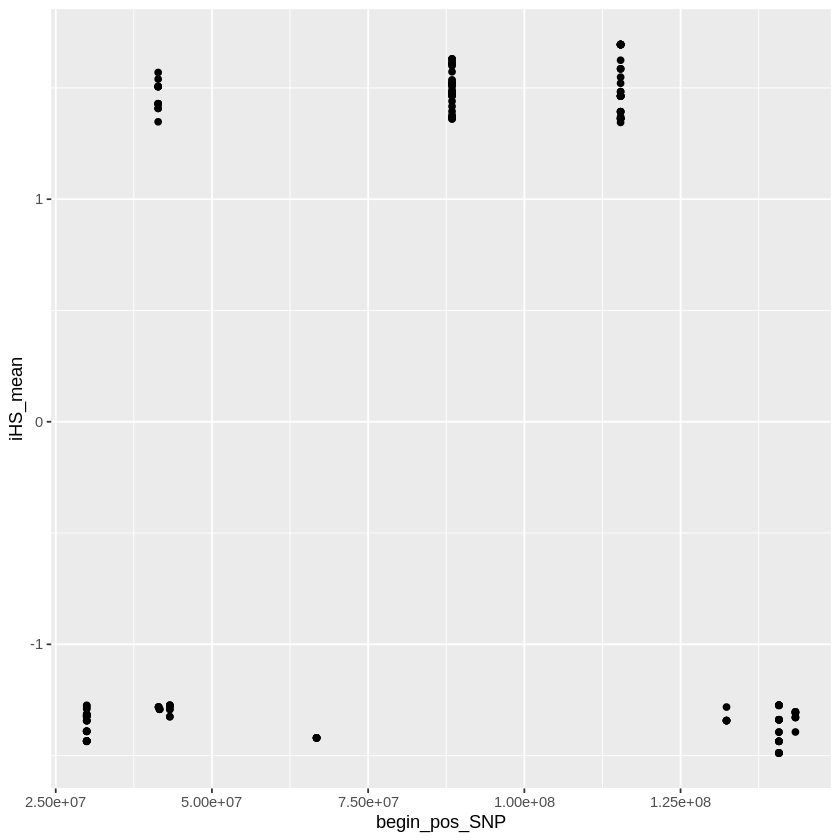

In [49]:
#200 most extreme iHS values Africa
des_200_AF <- iHS_descending_order_AF[1:100,]
asc_200_AF <- iHS_ascending_order_AF[1:100,]

plotdata_AF_iHS_200 <- bind_rows(des_200_AF, asc_200_AF)
print("Africa")
plot_AF_iHS_200 <- ggplot(plotdata_AF_iHS_200)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_AF_iHS_200
head(plotdata_AF_iHS_200)


AF_iHS__beddata <- plotdata_AF_iHS_200 %>% select(begin_pos_SNP, end_pos_SNP)
AF_iHS__beddata <- AF_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(AF_iHS__beddata))) 
AF_iHS__beddata <- AF_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_iHS__beddata, "AF_iHS__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "Africa"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,299678,X,115407125,115423718,1.694851
2,299679,X,115407256,115424298,1.694851
3,299680,X,115407301,115424391,1.694851
4,299681,X,115407489,115424601,1.694851
5,299682,X,115407731,115424734,1.694851
6,299683,X,115407785,115424766,1.694851


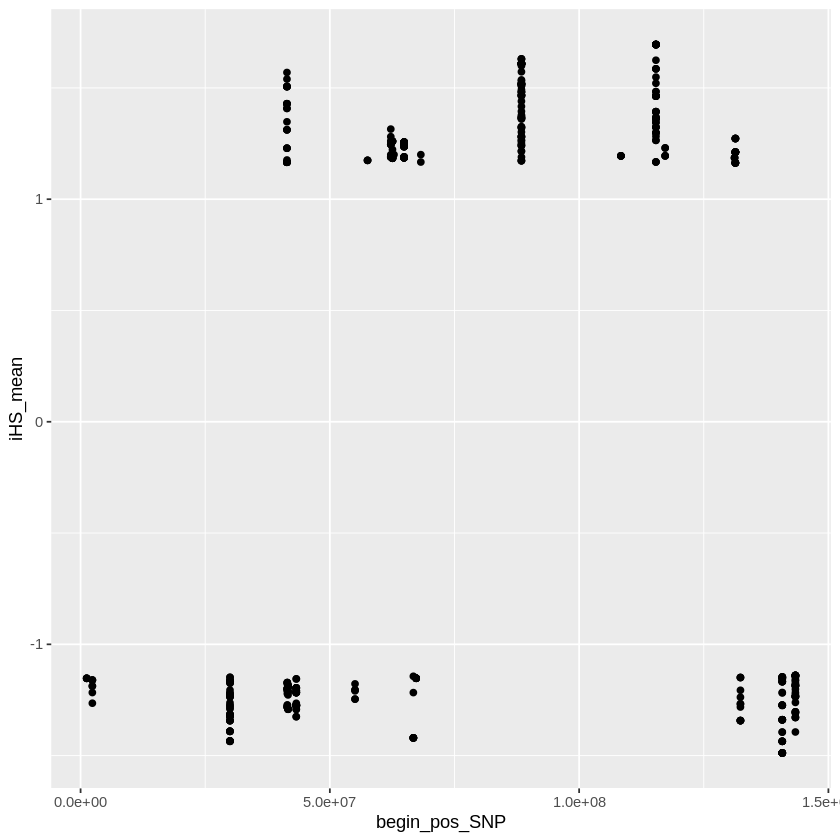

In [44]:
#500 most extreme iHS values Africa
des_500_AF <- iHS_descending_order_AF[1:250,]
asc_500_AF <- iHS_ascending_order_AF[1:250,]

plotdata_AF_iHS_500 <- bind_rows(des_500_AF, asc_500_AF)
print("Africa")
plot_AF_iHS_500 <- ggplot(plotdata_AF_iHS_500)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_AF_iHS_500
head(plotdata_AF_iHS_500)


AF_iHS__beddata <- plotdata_AF_iHS_500 %>% select(begin_pos_SNP, end_pos_SNP)
AF_iHS__beddata <- AF_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(AF_iHS__beddata))) 
AF_iHS__beddata <- AF_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_iHS__beddata, "AF_iHS__beddata_500.bed", delim = "\t", col_names = FALSE)

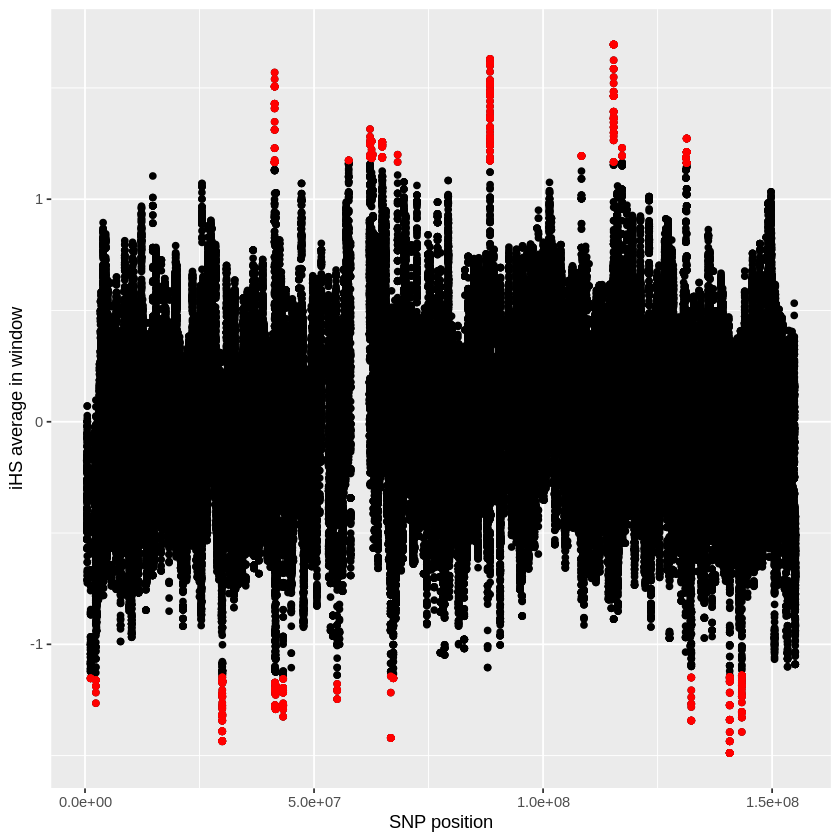

In [47]:


iHS_Africa_500 <- ggplot()+ 
geom_point(aes(x = iHS_mean_AF$begin_pos_SNP, y= iHS_mean_AF$iHS_mean))+ 
geom_point(aes(x = plotdata_AF_iHS_500$begin_pos_SNP, y= plotdata_AF_iHS_500$iHS_mean), color = 'red')+
xlab('SNP position')+
ylab('iHS average in window') 
iHS_Africa_500


[1] "West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,117795,X,37711759,37734447,3.250072
2,117796,X,37711956,37734517,3.250072
3,117797,X,37712751,37734900,3.250072
4,117798,X,37712975,37734970,3.250072
5,117799,X,37713174,37735003,3.250072
6,117800,X,37713185,37735230,3.250072


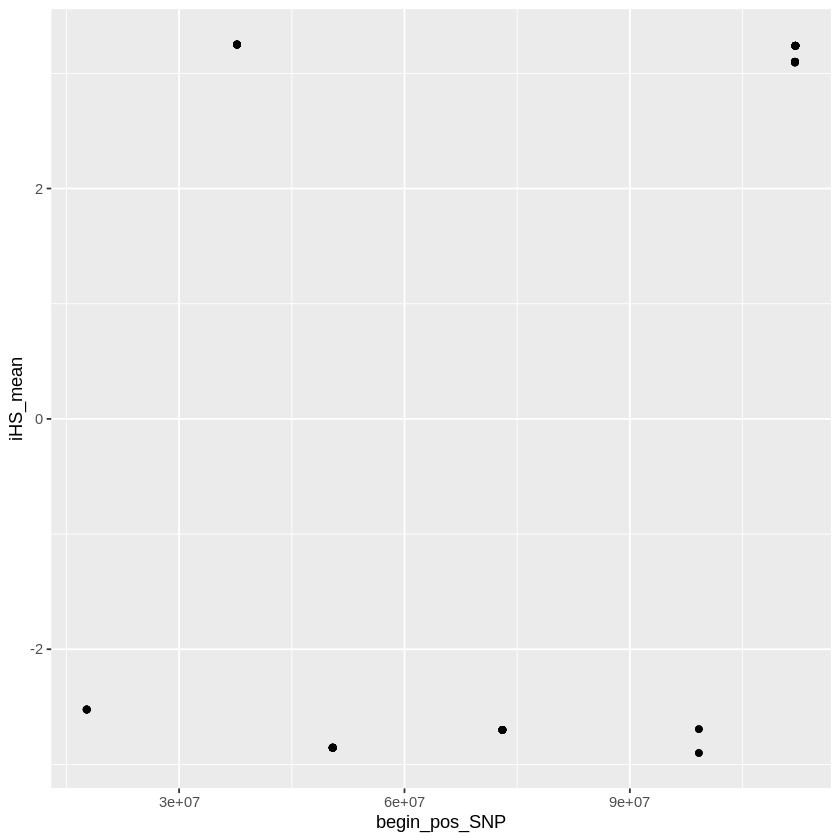

In [51]:
#100 most extreme iHS values West Eurasia
des_100_WE <- iHS_descending_order_WE[1:50,]
asc_100_WE <- iHS_ascending_order_WE[1:50,]

plotdata_WE_iHS_100 <- bind_rows(des_100_WE, asc_100_WE)
print("West Eurasia")
plot_WE_iHS_100 <- ggplot(plotdata_WE_iHS_100)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_WE_iHS_100
head(plotdata_WE_iHS_100)


WE_iHS__beddata <- plotdata_WE_iHS_100 %>% select(begin_pos_SNP, end_pos_SNP)
WE_iHS__beddata <- WE_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(WE_iHS__beddata))) 
WE_iHS__beddata <- WE_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_iHS__beddata, "WE_iHS__beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,117795,X,37711759,37734447,3.250072
2,117796,X,37711956,37734517,3.250072
3,117797,X,37712751,37734900,3.250072
4,117798,X,37712975,37734970,3.250072
5,117799,X,37713174,37735003,3.250072
6,117800,X,37713185,37735230,3.250072


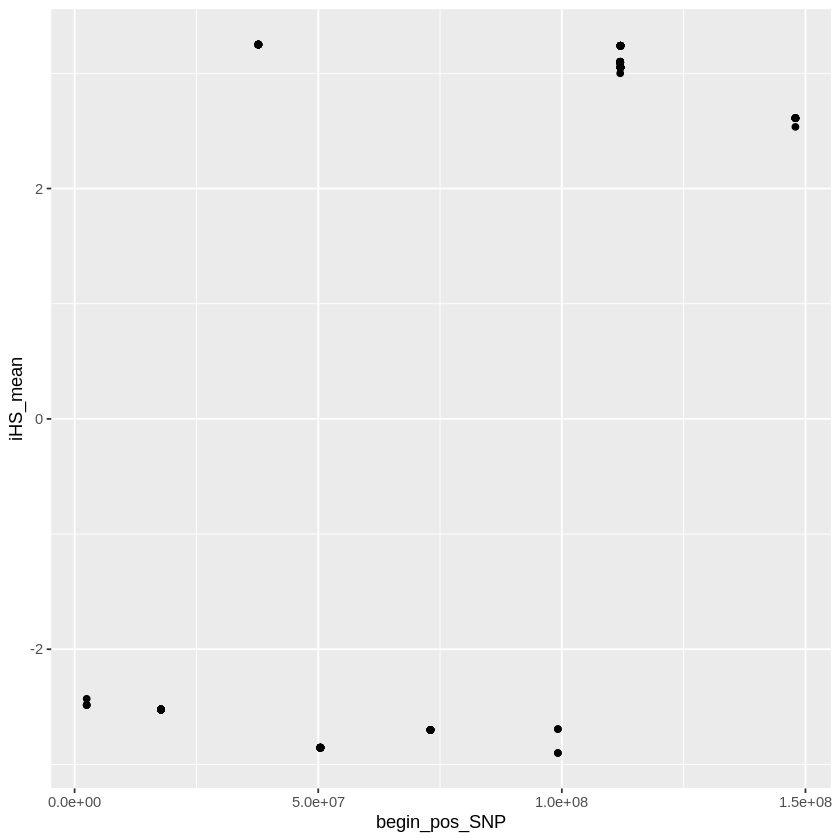

In [52]:
#200 most extreme iHS values West Eurasia
des_200_WE <- iHS_descending_order_WE[1:100,]
asc_200_WE <- iHS_ascending_order_WE[1:100,]

plotdata_WE_iHS_200 <- bind_rows(des_200_WE, asc_200_WE)
print("West Eurasia")
plot_WE_iHS_200 <- ggplot(plotdata_WE_iHS_200)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_WE_iHS_200
head(plotdata_WE_iHS_200)


WE_iHS__beddata <- plotdata_WE_iHS_200 %>% select(begin_pos_SNP, end_pos_SNP)
WE_iHS__beddata <- WE_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(WE_iHS__beddata))) 
WE_iHS__beddata <- WE_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_iHS__beddata, "WE_iHS__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,117795,X,37711759,37734447,3.250072
2,117796,X,37711956,37734517,3.250072
3,117797,X,37712751,37734900,3.250072
4,117798,X,37712975,37734970,3.250072
5,117799,X,37713174,37735003,3.250072
6,117800,X,37713185,37735230,3.250072


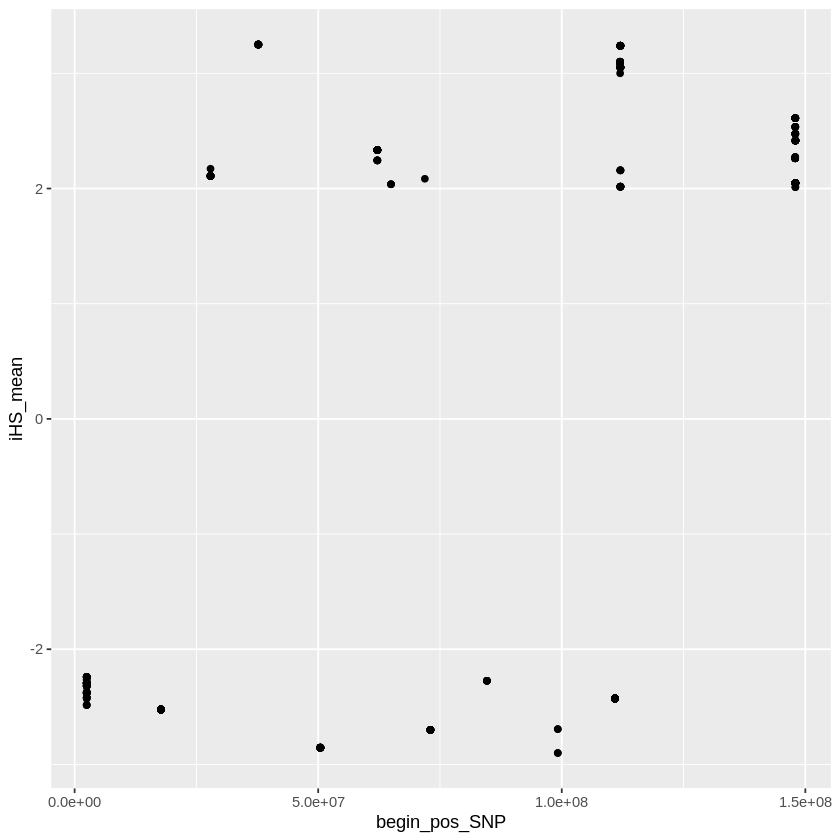

In [48]:
#500 most extreme iHS values West Eurasia
des_500_WE <- iHS_descending_order_WE[1:250,]
asc_500_WE <- iHS_ascending_order_WE[1:250,]

plotdata_WE_iHS_500 <- bind_rows(des_500_WE, asc_500_WE)
print("West Eurasia")
plot_WE_iHS_500 <- ggplot(plotdata_WE_iHS_500)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_WE_iHS_500
head(plotdata_WE_iHS_500)


WE_iHS__beddata <- plotdata_WE_iHS_500 %>% select(begin_pos_SNP, end_pos_SNP)
WE_iHS__beddata <- WE_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(WE_iHS__beddata))) 
WE_iHS__beddata <- WE_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_iHS__beddata, "WE_iHS__beddata_500.bed", delim = "\t", col_names = FALSE)

Warning message:
“Removed 3022 rows containing missing values (geom_point).”


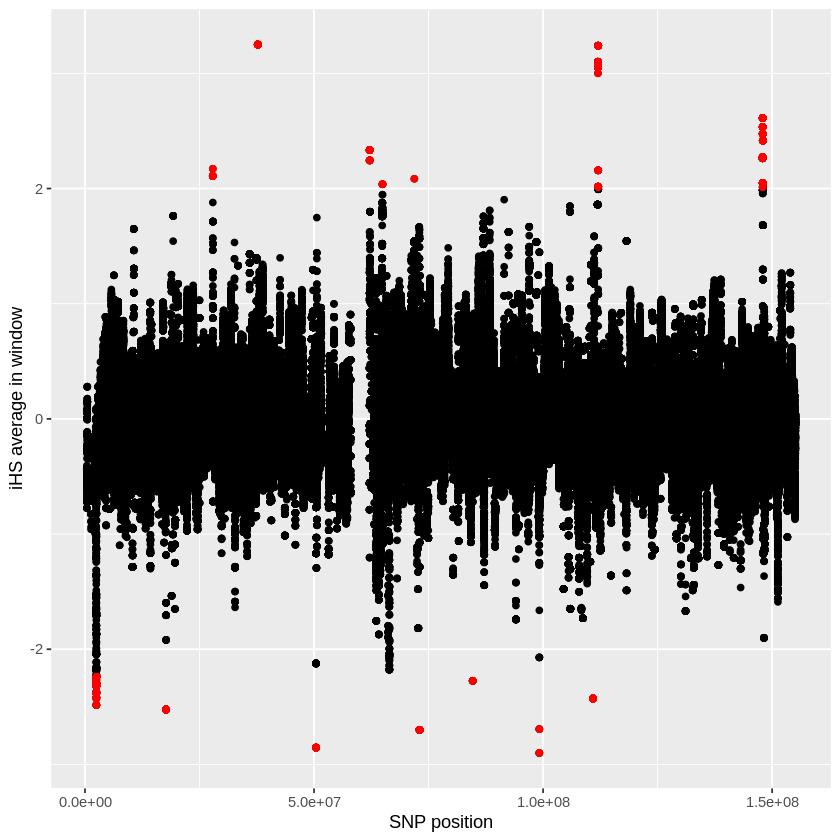

In [49]:
iHS_WE_500 <- ggplot()+ 
geom_point(aes(x = iHS_mean_WE$begin_pos_SNP, y= iHS_mean_WE$iHS_mean))+ 
geom_point(aes(x = plotdata_WE_iHS_500$begin_pos_SNP, y= plotdata_WE_iHS_500$iHS_mean), color = 'red')+
xlab('SNP position')+
ylab('iHS average in window') 
iHS_WE_500

[1] "East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,250788,X,97250534,97274681,3.181525
2,250789,X,97250734,97274821,3.181525
3,250790,X,97250918,97275342,3.181525
4,250791,X,97251642,97275377,3.181525
5,250792,X,97252100,97275501,3.181525
6,250793,X,97252687,97275593,3.181525


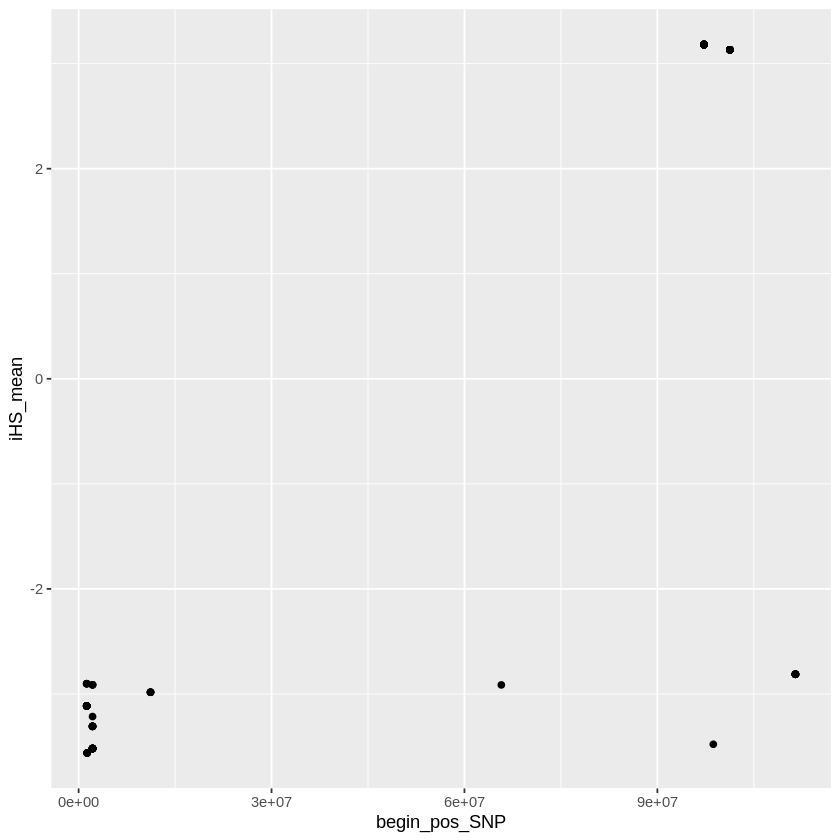

In [54]:
#100 most extreme iHS values East Asia 
des_100_EA <- iHS_descending_order_EA[1:50,]
asc_100_EA <- iHS_ascending_order_EA[1:50,]

plotdata_EA_iHS_100 <- bind_rows(des_100_EA, asc_100_EA)
print("East Asia")
plot_EA_iHS_100 <- ggplot(plotdata_EA_iHS_100)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_EA_iHS_100
head(plotdata_EA_iHS_100)


EA_iHS__beddata <- plotdata_EA_iHS_100 %>% select(begin_pos_SNP, end_pos_SNP)
EA_iHS__beddata <- EA_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(EA_iHS__beddata))) 
EA_iHS__beddata <- EA_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(EA_iHS__beddata, "EA_iHS__beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,250788,X,97250534,97274681,3.181525
2,250789,X,97250734,97274821,3.181525
3,250790,X,97250918,97275342,3.181525
4,250791,X,97251642,97275377,3.181525
5,250792,X,97252100,97275501,3.181525
6,250793,X,97252687,97275593,3.181525


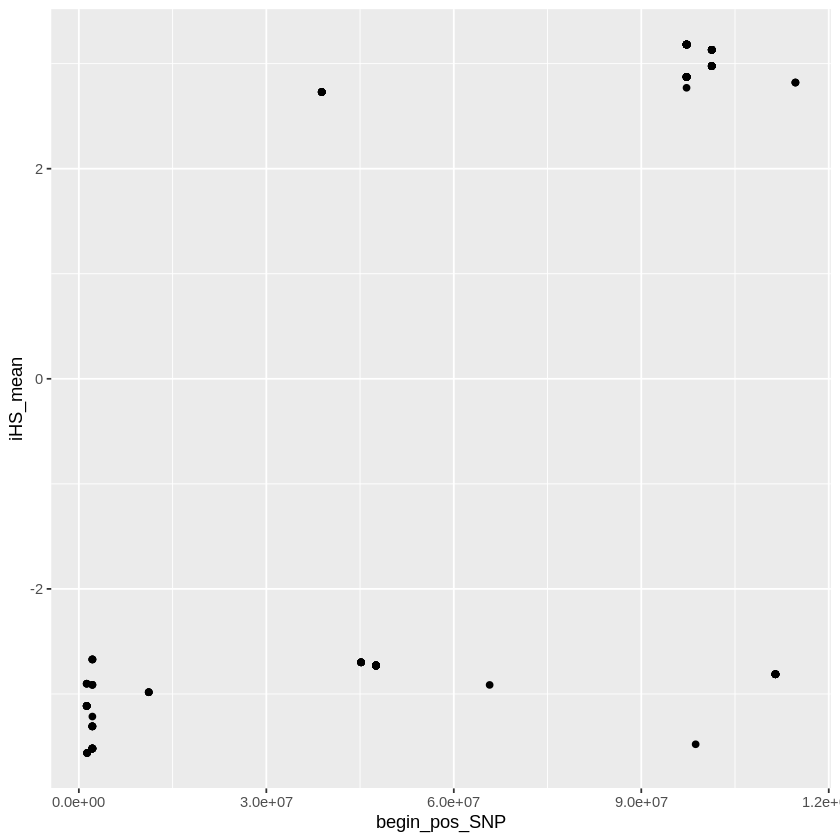

In [55]:
#200 most extreme iHS values East Asia 
des_200_EA <- iHS_descending_order_EA[1:100,]
asc_200_EA <- iHS_ascending_order_EA[1:100,]

plotdata_EA_iHS_200 <- bind_rows(des_200_EA, asc_200_EA)
print("East Asia")
plot_EA_iHS_200 <- ggplot(plotdata_EA_iHS_200)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_EA_iHS_200
head(plotdata_EA_iHS_200)


EA_iHS__beddata <- plotdata_EA_iHS_200 %>% select(begin_pos_SNP, end_pos_SNP)
EA_iHS__beddata <- EA_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(EA_iHS__beddata))) 
EA_iHS__beddata <- EA_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(EA_iHS__beddata, "EA_iHS__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,250788,X,97250534,97274681,3.181525
2,250789,X,97250734,97274821,3.181525
3,250790,X,97250918,97275342,3.181525
4,250791,X,97251642,97275377,3.181525
5,250792,X,97252100,97275501,3.181525
6,250793,X,97252687,97275593,3.181525


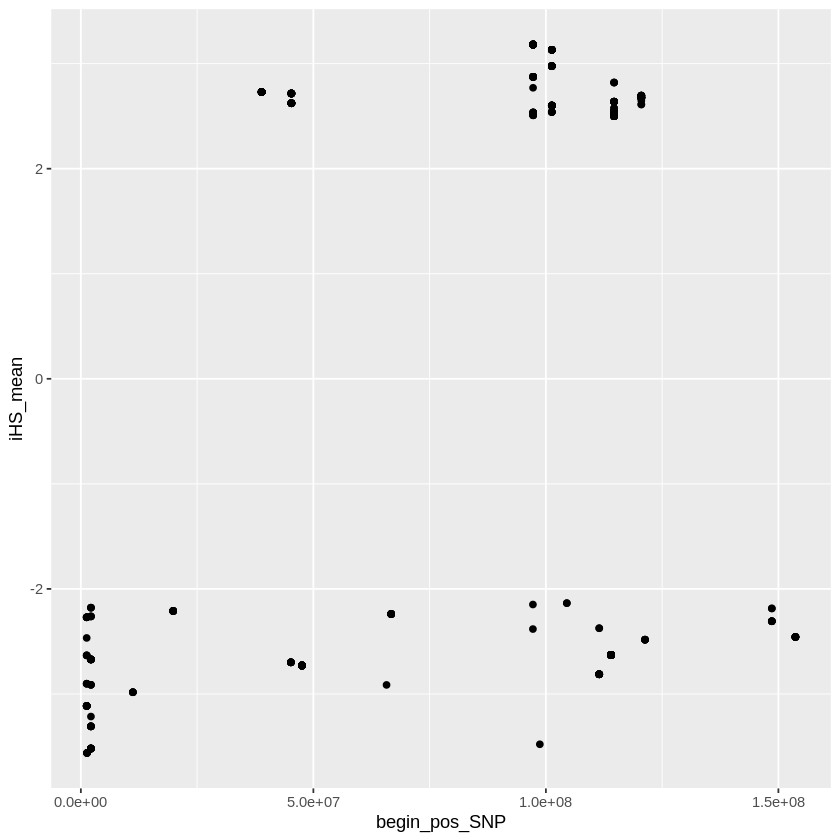

In [50]:
#500 most extreme iHS values East Asia 
des_500_EA <- iHS_descending_order_EA[1:250,]
asc_500_EA <- iHS_ascending_order_EA[1:250,]

plotdata_EA_iHS_500 <- bind_rows(des_500_EA, asc_500_EA)
print("East Asia")
plot_EA_iHS_500 <- ggplot(plotdata_EA_iHS_500)+ geom_point(aes(x = begin_pos_SNP, y= iHS_mean))
plot_EA_iHS_500
head(plotdata_EA_iHS_500)


EA_iHS__beddata <- plotdata_EA_iHS_500 %>% select(begin_pos_SNP, end_pos_SNP)
EA_iHS__beddata <- EA_iHS__beddata %>% mutate(chrom = rep('chrX', nrow(EA_iHS__beddata))) 
EA_iHS__beddata <- EA_iHS__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(EA_iHS__beddata, "EA_iHS__beddata_500.bed", delim = "\t", col_names = FALSE)

Warning message:
“Removed 10169 rows containing missing values (geom_point).”


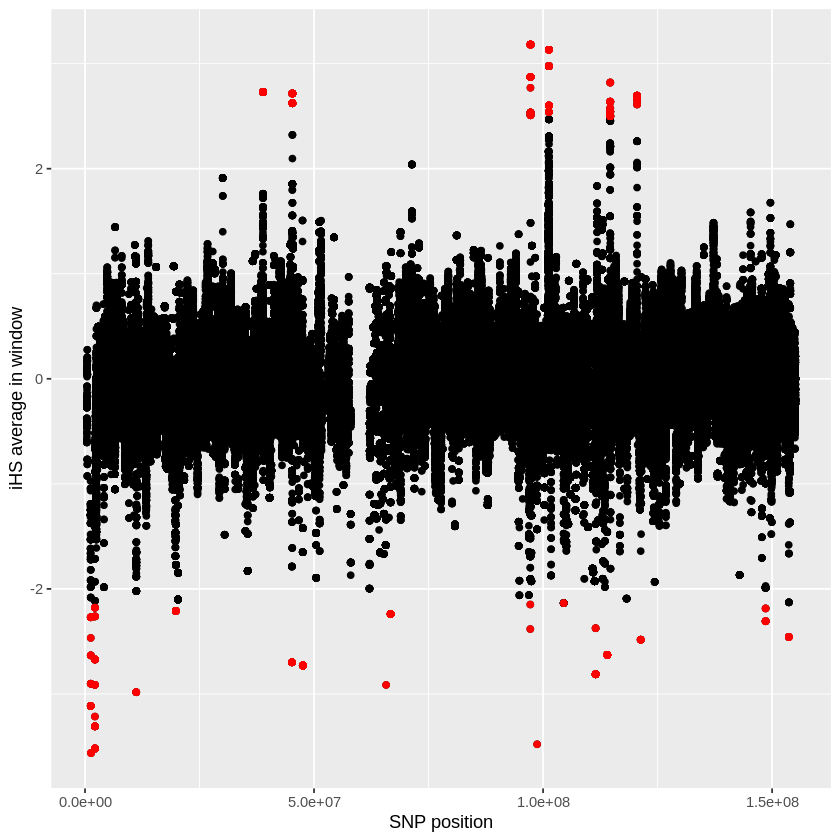

In [51]:
iHS_EA_500 <- ggplot()+ 
geom_point(aes(x = iHS_mean_EA$begin_pos_SNP, y= iHS_mean_EA$iHS_mean))+ 
geom_point(aes(x = plotdata_EA_iHS_500$begin_pos_SNP, y= plotdata_EA_iHS_500$iHS_mean), color = 'red')+
xlab('SNP position')+
ylab('iHS average in window') 
iHS_EA_500

,X,chr,begin_pos_SNP,end_pos_SNP,iHS_mean,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,299678,X,115407125,115423718,1.694851,Africa
2,299679,X,115407256,115424298,1.694851,Africa
3,299680,X,115407301,115424391,1.694851,Africa
4,299681,X,115407489,115424601,1.694851,Africa
5,299682,X,115407731,115424734,1.694851,Africa
6,299683,X,115407785,115424766,1.694851,Africa


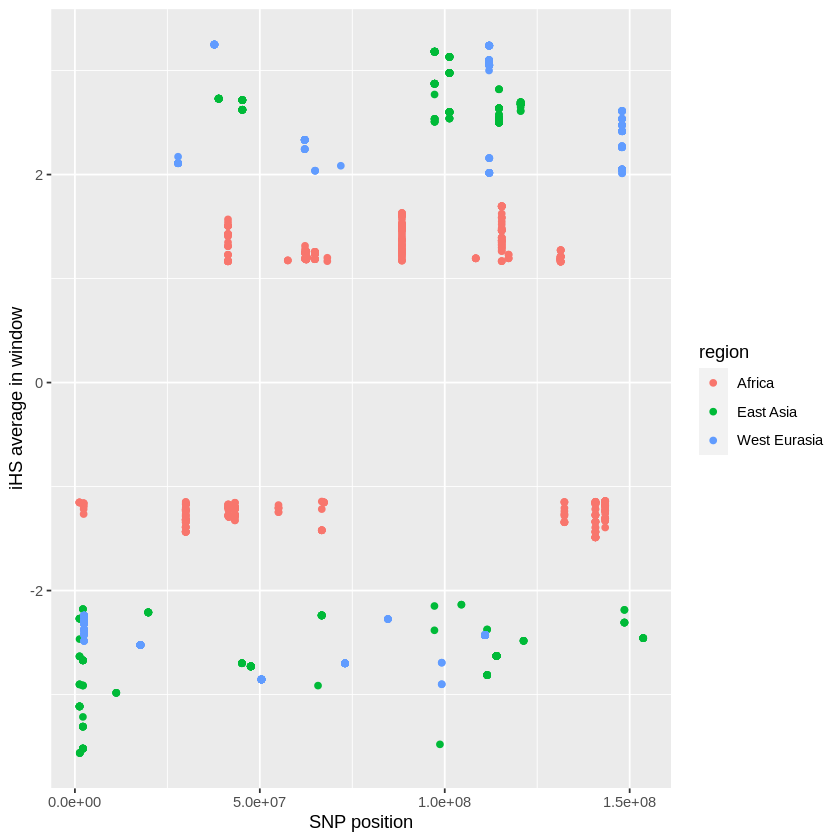

In [55]:
plotdata_AF_iHS_500 <- plotdata_AF_iHS_500 %>% mutate(region = rep('Africa', nrow(plotdata_AF_iHS_500)))
plotdata_EA_iHS_500 <- plotdata_EA_iHS_500 %>% mutate(region = rep('East Asia', nrow(plotdata_EA_iHS_500)))
plotdata_WE_iHS_500 <- plotdata_WE_iHS_500 %>% mutate(region = rep('West Eurasia', nrow(plotdata_WE_iHS_500)))
iHS_500_all <- bind_rows(plotdata_AF_iHS_500, plotdata_EA_iHS_500, plotdata_WE_iHS_500)
head(iHS_500_all)

plot_iHS_500_all <- ggplot(iHS_500_all) + geom_point(aes(x = begin_pos_SNP, y= iHS_mean, color = region))+
xlab('SNP position')+
ylab('iHS average in window') 
plot_iHS_500_all

I read in the intersection results from bedtools (carried out in the terminal) like in the first exercise. 

In [72]:
#Afrika
print('Africa 100')
AF_100 <- read.csv('AF_100.bed', sep = '\t', header = FALSE)
AF_100  <- AF_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_100)
genesAF_iHS_100 <- unique(AF_100[c("V7")])
genesAF_iHS_100

print('Africa 200')
AF_200 <- read.csv('AF_200.bed', sep = '\t', header = FALSE)
AF_200  <- AF_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_100)
genesAF_iHS_200 <- unique(AF_100[c("V7")])
genesAF_iHS_200

print('Africa 500')
AF_500 <- read.csv('AF_500.bed', sep = '\t', header = FALSE)
AF_500  <- AF_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_500)
genesAF_iHS_500 <- unique(AF_500[c("V7")])
genesAF_iHS_500

#West Eurasia 
print('West Eurasia 100')
WE_100 <- read.csv('WE_100.bed', sep = '\t', header = FALSE)
WE_100  <- WE_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_100)
genesWE_iHS_100 <- unique(WE_100[c("V7")])
genesWE_iHS_100

print('West Eurasia 200')
WE_200 <- read.csv('WE_200.bed', sep = '\t', header = FALSE)
WE_200  <- WE_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_200)
genesWE_iHS_200 <- unique(WE_200[c("V7")])
genesWE_iHS_200

print('West Eurasia 500')
WE_500 <- read.csv('WE_500.bed', sep = '\t', header = FALSE)
WE_500  <- WE_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_500)
genesWE_iHS_500 <- unique(WE_500[c("V7")])
genesWE_iHS_500

#East Asia
print('East Asia 100')
EA_100 <- read.csv('EA_100.bed', sep = '\t', header = FALSE)
EA_100  <- EA_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_100)
genesEA_iHS_100 <- unique(EA_100[c("V7")])
genesEA_iHS_100

print('East Asia 200')
EA_200 <- read.csv('EA_200.bed', sep = '\t', header = FALSE)
EA_200  <- EA_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_200)
genesEA_iHS_200 <- unique(EA_200[c("V7")])
genesEA_iHS_200

print('East Asia 500')
EA_500 <- read.csv('EA_500.bed', sep = '\t', header = FALSE)
EA_500  <- EA_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_500)
genesEA_iHS_500 <- unique(EA_500[c("V7")])
genesEA_iHS_500

[1] "Africa 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,41396345,41438939,chrX,41401943,41402059,ENSG00000147044.21_7,116
2,chrX,41396345,41438939,chrX,41430175,41430282,ENSG00000212207.1,107
3,chrX,41396396,41439037,chrX,41401943,41402059,ENSG00000147044.21_7,116
4,chrX,41396396,41439037,chrX,41430175,41430282,ENSG00000212207.1,107
5,chrX,41394793,41436927,chrX,41401943,41402059,ENSG00000147044.21_7,116
6,chrX,41394793,41436927,chrX,41430175,41430282,ENSG00000212207.1,107


,V7
,<chr>
1,ENSG00000147044.21_7
2,ENSG00000212207.1
11,ENSG00000196406.4_2
21,ENSG00000169306.9_3
34,ENSG00000233710.1_5
35,ENSG00000169083.16_4
48,ENSG00000224630.2_5
49,ENSG00000235598.1_4
59,ENSG00000202199.1


[1] "Africa 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,41396345,41438939,chrX,41401943,41402059,ENSG00000147044.21_7,116
2,chrX,41396345,41438939,chrX,41430175,41430282,ENSG00000212207.1,107
3,chrX,41396396,41439037,chrX,41401943,41402059,ENSG00000147044.21_7,116
4,chrX,41396396,41439037,chrX,41430175,41430282,ENSG00000212207.1,107
5,chrX,41394793,41436927,chrX,41401943,41402059,ENSG00000147044.21_7,116
6,chrX,41394793,41436927,chrX,41430175,41430282,ENSG00000212207.1,107


,V7
,<chr>
1,ENSG00000147044.21_7
2,ENSG00000212207.1
11,ENSG00000196406.4_2
21,ENSG00000169306.9_3
34,ENSG00000233710.1_5
35,ENSG00000169083.16_4
48,ENSG00000224630.2_5
49,ENSG00000235598.1_4
59,ENSG00000202199.1


[1] "Africa 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,41396345,41438939,chrX,41401943,41402059,ENSG00000147044.21_7,116
2,chrX,41396345,41438939,chrX,41430175,41430282,ENSG00000212207.1,107
3,chrX,41396396,41439037,chrX,41401943,41402059,ENSG00000147044.21_7,116
4,chrX,41396396,41439037,chrX,41430175,41430282,ENSG00000212207.1,107
5,chrX,41394793,41436927,chrX,41401943,41402059,ENSG00000147044.21_7,116
6,chrX,41394793,41436927,chrX,41430175,41430282,ENSG00000212207.1,107


,V7
,<chr>
1,ENSG00000147044.21_7
2,ENSG00000212207.1
35,ENSG00000123728.10_3
36,ENSG00000232160.6_5
45,ENSG00000235437.7_5
46,ENSG00000186767.6_3
47,ENSG00000233661.1_5
48,ENSG00000131089.15_5
65,ENSG00000147065.17_4


[1] "West Eurasia 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,37711759,37734447,chrX,37729361,37729468,ENSG00000206983.1,107
2,chrX,37711759,37734447,chrX,37208582,38546928,ENSG00000250349.3_6,22688
3,chrX,37711956,37734517,chrX,37729361,37729468,ENSG00000206983.1,107
4,chrX,37711956,37734517,chrX,37208582,38546928,ENSG00000250349.3_6,22561
5,chrX,37712751,37734900,chrX,37729361,37729468,ENSG00000206983.1,107
6,chrX,37712751,37734900,chrX,37208582,38546928,ENSG00000250349.3_6,22149


,V7
,<chr>
1,ENSG00000206983.1
2,ENSG00000250349.3_6
31,ENSG00000126016.15_3
53,ENSG00000158352.15_2
77,ENSG00000229807.11_4
78,ENSG00000270641.1_2
105,ENSG00000188158.15_5
106,ENSG00000226153.1_5


[1] "West Eurasia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,37711759,37734447,chrX,37729361,37729468,ENSG00000206983.1,107
2,chrX,37711759,37734447,chrX,37208582,38546928,ENSG00000250349.3_6,22688
3,chrX,37711956,37734517,chrX,37729361,37729468,ENSG00000206983.1,107
4,chrX,37711956,37734517,chrX,37208582,38546928,ENSG00000250349.3_6,22561
5,chrX,37712751,37734900,chrX,37729361,37729468,ENSG00000206983.1,107
6,chrX,37712751,37734900,chrX,37208582,38546928,ENSG00000250349.3_6,22149


,V7
,<chr>
1,ENSG00000206983.1
2,ENSG00000250349.3_6
31,ENSG00000126016.15_3
60,ENSG00000263351.1
92,ENSG00000155966.13_4
104,ENSG00000158352.15_2
128,ENSG00000229807.11_4
129,ENSG00000270641.1_2
156,ENSG00000188158.15_5


[1] "West Eurasia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,37711759,37734447,chrX,37729361,37729468,ENSG00000206983.1,107
2,chrX,37711759,37734447,chrX,37208582,38546928,ENSG00000250349.3_6,22688
3,chrX,37711956,37734517,chrX,37729361,37729468,ENSG00000206983.1,107
4,chrX,37711956,37734517,chrX,37208582,38546928,ENSG00000250349.3_6,22561
5,chrX,37712751,37734900,chrX,37729361,37729468,ENSG00000206983.1,107
6,chrX,37712751,37734900,chrX,37208582,38546928,ENSG00000250349.3_6,22149


,V7
,<chr>
1,ENSG00000206983.1
2,ENSG00000250349.3_6
31,ENSG00000126016.15_3
60,ENSG00000263351.1
92,ENSG00000155966.13_4
141,ENSG00000224589.1_5
159,ENSG00000067177.15_4
160,ENSG00000231944.1_5
212,ENSG00000147065.17_4


[1] "East Asia 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,1314388,2180815,chrX,1325325,1325492,ENSG00000205755.11_2,167
2,chrX,1314388,2180815,chrX,1387692,1387772,ENSG00000198223.16_4,80
3,chrX,1314388,2180815,chrX,1410647,1410721,ENSG00000264510.1,74
4,chrX,1314388,2180815,chrX,1410986,1411060,ENSG00000264819.1,74
5,chrX,1314388,2180815,chrX,1412507,1412582,ENSG00000263980.1,75
6,chrX,1314388,2180815,chrX,1412810,1412885,ENSG00000265658.1,75


,V7
,<chr>
1,ENSG00000205755.11_2
2,ENSG00000198223.16_4
3,ENSG00000264510.1
4,ENSG00000264819.1
5,ENSG00000263980.1
6,ENSG00000265658.1
7,ENSG00000263835.1
8,ENSG00000223274.6_1
9,ENSG00000265350.1


[1] "East Asia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,114667356,114697042,chrX,114689493,114689955,ENSG00000271021.1_5,462
2,chrX,114667432,114697363,chrX,114689493,114689955,ENSG00000271021.1_5,462
3,chrX,114667490,114697903,chrX,114689493,114689955,ENSG00000271021.1_5,462
4,chrX,1314388,2180815,chrX,1325325,1325492,ENSG00000205755.11_2,167
5,chrX,1314388,2180815,chrX,1387692,1387772,ENSG00000198223.16_4,80
6,chrX,1314388,2180815,chrX,1410647,1410721,ENSG00000264510.1,74


,V7
,<chr>
1,ENSG00000271021.1_5
4,ENSG00000205755.11_2
5,ENSG00000198223.16_4
6,ENSG00000264510.1
7,ENSG00000264819.1
8,ENSG00000263980.1
9,ENSG00000265658.1
10,ENSG00000263835.1
11,ENSG00000223274.6_1


[1] "East Asia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,114667356,114697042,chrX,114689493,114689955,ENSG00000271021.1_5,462
2,chrX,114667432,114697363,chrX,114689493,114689955,ENSG00000271021.1_5,462
3,chrX,114667490,114697903,chrX,114689493,114689955,ENSG00000271021.1_5,462
4,chrX,114665505,114693243,chrX,114689493,114689955,ENSG00000271021.1_5,462
5,chrX,114665861,114693883,chrX,114689493,114689955,ENSG00000271021.1_5,462
6,chrX,114665905,114694402,chrX,114689493,114689955,ENSG00000271021.1_5,462


,V7
,<chr>
1,ENSG00000271021.1_5
20,ENSG00000274374.1_5
49,ENSG00000205755.11_2
50,ENSG00000198223.16_4
51,ENSG00000264510.1
52,ENSG00000264819.1
53,ENSG00000263980.1
54,ENSG00000265658.1
55,ENSG00000263835.1


**Exercise C**

Perform an XP-EHH scan of the whole X chromosome for at least three populations. Identify the 10 most significant regions and associated with genes as in A.

This exercise is performed in the same steps as the previos exercise, but for pairwise populations just as for the Fst

In [27]:
#Calculation of the XP-EHH per position
XPEHH_AF_WE <- ies2xpehh(res.scanAF,res.scanWE, popname1 = "Africa", popname2 = "WestEurope")
XPEHH_AF_EA <- ies2xpehh(res.scanAF,res.scanEA, popname1 = "Africa", popname2 = "EastAsia")
XPEHH_WE_EA <- ies2xpehh(res.scanWE,res.scanEA, popname1 = "WestEurope", popname2 = "EastAsia")

Scan of pop1 contains 411892 markers.
Scan of pop2 contains 411892 markers.
Merged data contains 411892 markers.
Scan of pop1 contains 411892 markers.
Scan of pop2 contains 411892 markers.
Merged data contains 411892 markers.
Scan of pop1 contains 411892 markers.
Scan of pop2 contains 411892 markers.
Merged data contains 411892 markers.


In [28]:
#I change the column name for easier acces in the following analysis.
XPEHH_AF_WE <- XPEHH_AF_WE %>% rename(XPEHH = XPEHH_Africa_WestEurope)
head(XPEHH_AF_WE)
XPEHH_AF_EA <- XPEHH_AF_EA %>% rename(XPEHH = XPEHH_Africa_EastAsia)
head(XPEHH_AF_EA)
XPEHH_WE_EA <- XPEHH_WE_EA %>% rename(XPEHH = XPEHH_WestEurope_EastAsia)
head(XPEHH_WE_EA)

,CHR,POSITION,XPEHH,LOGPVALUE
,<chr>,<dbl>,<dbl>,<dbl>
1,X,365712,NA,NA
2,X,400000,NA,NA
3,X,400108,NA,NA
4,X,400132,NA,NA
5,X,400148,NA,NA
6,X,400303,NA,NA


,CHR,POSITION,XPEHH,LOGPVALUE
,<chr>,<dbl>,<dbl>,<dbl>
1,X,365712,NA,NA
2,X,400000,NA,NA
3,X,400108,NA,NA
4,X,400132,NA,NA
5,X,400148,NA,NA
6,X,400303,NA,NA


,CHR,POSITION,XPEHH,LOGPVALUE
,<chr>,<dbl>,<dbl>,<dbl>
1,X,365712,NA,NA
2,X,400000,NA,NA
3,X,400108,NA,NA
4,X,400132,NA,NA
5,X,400148,NA,NA
6,X,400303,NA,NA


In [29]:
#Function for calculating the mean
XPEHH_mean <- function(XPEHH_table, windowsize = 100){
    chr <- NULL
    begin_pos_SNP <- NULL
    end_pos_SNP <- NULL
    XPEHH_mean <- NULL
    window <- windowsize-1
    
    for (i in 1:(nrow(SNPS) - window)){
        chr[i] = SNPS$chr[i]
        begin_pos_SNP[i] = SNPS$pos[i]
        end_pos_SNP[i] = SNPS$pos[i+window]
        SNPwindow <- XPEHH_table %>% filter(between(pos, begin_pos_SNP[i], end_pos_SNP[i]))
        SNPwindow <- SNPwindow %>% drop_na()
        XPEHH_mean[i] = mean(SNPwindow$XPEHH)
    }
    
    XPEHH <- tibble(chr = chr,
                  begin_pos_SNP = begin_pos_SNP,
                  end_pos_SNP = end_pos_SNP,
                  XPEHH_mean = XPEHH_mean)
    
    return(XPEHH)
}

In [32]:
#Calculate the iHS mean per 100 lenght sliding window for the three populations
XPEHH_mean_AF_WE <- XPEHH_mean(XPEHH_AF_WE)
head(XPEHH_mean_AF_WE)
write.csv(XPEHH_mean_AF_WE, "XPEHH_mean_AF_WE.csv")

XPEHH_mean_AF_EA <- XPEHH_mean(XPEHH_AF_EA)
head(XPEHH_mean_AF_EA)
write.csv(XPEHH_mean_AF_EA, "XPEHH_mean_AF_EA.csv")

XPEHH_mean_WE_EA <- XPEHH_mean(XPEHH_WE_EA)
head(XPEHH_mean_WE_EA)
write.csv(XPEHH_mean_WE_EA, "XPEHH_mean_WE_EA.csv")

chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
<chr>,<int>,<int>,<dbl>
X,365712,452218,0.9312118
X,400000,452221,0.9321710
X,400108,452231,0.9331061
X,400132,454014,0.9332866
X,400148,454116,0.9336585
X,400303,454355,0.9340214


chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
<chr>,<int>,<int>,<dbl>
X,365712,452218,0.4955491
X,400000,452221,0.4920200
X,400108,452231,0.4885802
X,400132,454014,0.4845304
X,400148,454116,0.4830846
X,400303,454355,0.4808243


chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
<chr>,<int>,<int>,<dbl>
X,365712,452218,-0.4977801
X,400000,452221,-0.5042994
X,400108,452231,-0.5106538
X,400132,454014,-0.5168492
X,400148,454116,-0.5196795
X,400303,454355,-0.5236184


In [56]:
#Opening the files
XPEHH_mean_AF_WE <- read.csv("XPEHH_mean_AF_WE.csv")
XPEHH_mean_AF_EA <- read.csv("XPEHH_mean_AF_EA.csv")
XPEHH_mean_WE_EA <- read.csv("XPEHH_mean_WE_EA.csv")

In [57]:
#Sorting the files descending and ascending
#Africa and West Eurasia
XPEHH_descending_order_AF_WE <- XPEHH_mean_AF_WE %>% dplyr::arrange(desc(XPEHH_mean))
head(XPEHH_descending_order_AF_WE)

XPEHH_ascending_order_AF_WE <- XPEHH_mean_AF_WE %>% dplyr::arrange(XPEHH_mean)
head(XPEHH_ascending_order_AF_WE)

#East Africa and East Asia
XPEHH_descending_order_AF_EA <- XPEHH_mean_AF_EA %>% dplyr::arrange(desc(XPEHH_mean))
head(XPEHH_descending_order_AF_EA)

XPEHH_ascending_order_AF_EA <- XPEHH_mean_AF_EA %>% dplyr::arrange(XPEHH_mean)
head(XPEHH_ascending_order_AF_EA)

#West Eurasia and East Asia
XPEHH_descending_order_WE_EA <- XPEHH_mean_WE_EA %>% dplyr::arrange(desc(XPEHH_mean))
head(XPEHH_descending_order_WE_EA)

XPEHH_ascending_order_WE_EA <- XPEHH_mean_WE_EA %>% dplyr::arrange(XPEHH_mean)
head(XPEHH_ascending_order_WE_EA)

,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,140253,X,45034956,45051656,3.115016
2,140254,X,45034961,45051755,3.112900
3,140252,X,45034955,45051427,3.112205
4,140255,X,45034962,45052413,3.110590
5,140251,X,45034954,45051304,3.109697
6,140256,X,45034963,45052503,3.108682


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,315,X,2164180,2184727,-4.560711
2,314,X,2164151,2184707,-4.558749
3,313,X,2164110,2184691,-4.556787
4,312,X,2163347,2182735,-4.554824
5,316,X,2164295,2184771,-4.550031
6,311,X,2163111,2182653,-4.539597


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,359227,X,137140296,137176547,2.855152
2,359226,X,137139691,137176522,2.853470
3,359228,X,137140972,137176586,2.853421
4,359225,X,137139280,137176403,2.853115
5,359224,X,137139120,137176274,2.852341
6,359229,X,137141008,137177381,2.850379


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,315,X,2164180,2184727,-4.983197
2,314,X,2164151,2184707,-4.981883
3,313,X,2164110,2184691,-4.980569
4,312,X,2163347,2182735,-4.979254
5,316,X,2164295,2184771,-4.972631
6,311,X,2163111,2182653,-4.965074


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,182327,X,72474639,72497228,3.589335
2,182326,X,72474570,72496944,3.586242
3,182328,X,72474931,72497489,3.586140
4,182325,X,72474533,72496916,3.584417
5,182324,X,72474530,72496381,3.582118
6,182329,X,72475225,72498126,3.581701


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,262175,X,101790866,101820206,-4.117787
2,262176,X,101791531,101820358,-4.116744
3,262174,X,101790097,101820203,-4.116469
4,262173,X,101789496,101820198,-4.115042
5,262177,X,101792065,101820794,-4.111827
6,262172,X,101789108,101820176,-4.111394


[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,140253,X,45034956,45051656,3.115016
2,140254,X,45034961,45051755,3.112900
3,140252,X,45034955,45051427,3.112205
4,140255,X,45034962,45052413,3.110590
5,140251,X,45034954,45051304,3.109697
6,140256,X,45034963,45052503,3.108682


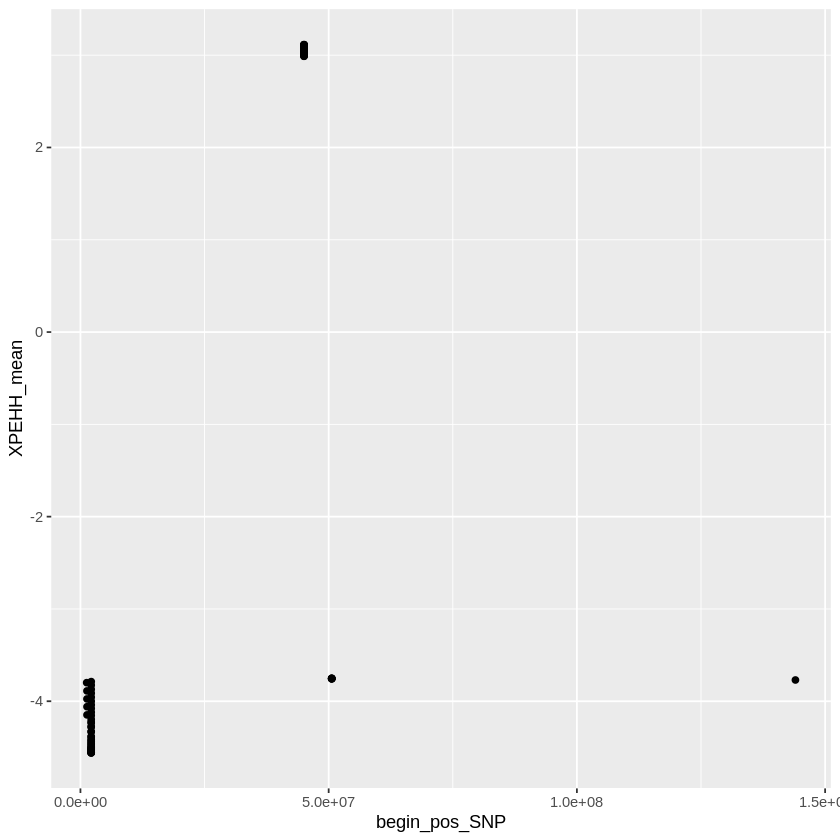

In [70]:
#100 most extreme XPEHH values Africa and West Eurasia
des_100_AF_WE <- XPEHH_descending_order_AF_WE[1:50,]
asc_100_AF_WE <- XPEHH_ascending_order_AF_WE[1:50,]

plotdata_AF_WE_XPEHH_100 <- bind_rows(des_100_AF_WE, asc_100_AF_WE)
print("Africa and West Eurasia")
plot_AF_WE_XPEHH_100 <- ggplot(plotdata_AF_WE_XPEHH_100)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_WE_XPEHH_100
head(plotdata_AF_WE_XPEHH_100)


AF_WE_XPEHH__beddata <- plotdata_AF_WE_XPEHH_100 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_XPEHH__beddata))) 
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_XPEHH__beddata, "AF_WE_XPEHH_beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,140253,X,45034956,45051656,3.115016
2,140254,X,45034961,45051755,3.112900
3,140252,X,45034955,45051427,3.112205
4,140255,X,45034962,45052413,3.110590
5,140251,X,45034954,45051304,3.109697
6,140256,X,45034963,45052503,3.108682


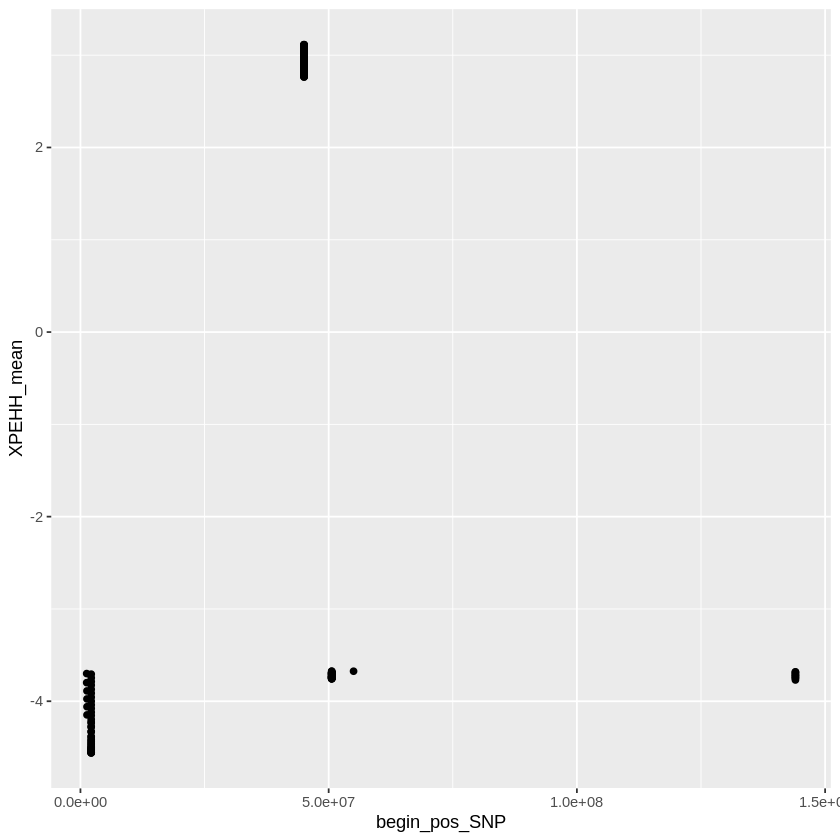

In [83]:
#200 most extreme XPEHH values Africa and West Eurasia
des_200_AF_WE <- XPEHH_descending_order_AF_WE[1:100,]
asc_200_AF_WE <- XPEHH_ascending_order_AF_WE[1:100,]

plotdata_AF_WE_XPEHH_200 <- bind_rows(des_200_AF_WE, asc_200_AF_WE)
print("Africa and West Eurasia")
plot_AF_WE_XPEHH_200 <- ggplot(plotdata_AF_WE_XPEHH_200)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_WE_XPEHH_200
head(plotdata_AF_WE_XPEHH_200)


AF_WE_XPEHH__beddata <- plotdata_AF_WE_XPEHH_200 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_XPEHH__beddata))) 
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_XPEHH__beddata, "AF_WE_XPEHH__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,140253,X,45034956,45051656,3.115016
2,140254,X,45034961,45051755,3.112900
3,140252,X,45034955,45051427,3.112205
4,140255,X,45034962,45052413,3.110590
5,140251,X,45034954,45051304,3.109697
6,140256,X,45034963,45052503,3.108682


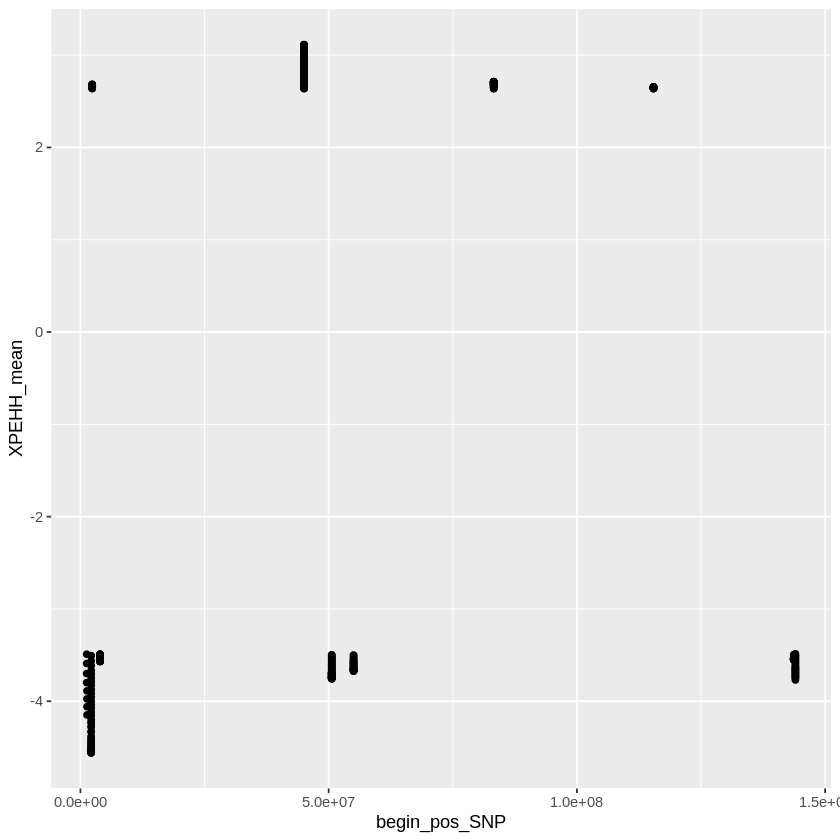

In [58]:
#500 most extreme XPEHH values Africa and West Eurasia
des_500_AF_WE <- XPEHH_descending_order_AF_WE[1:250,]
asc_500_AF_WE <- XPEHH_ascending_order_AF_WE[1:250,]

plotdata_AF_WE_XPEHH_500 <- bind_rows(des_500_AF_WE, asc_500_AF_WE)
print("Africa and West Eurasia")
plot_AF_WE_XPEHH_500 <- ggplot(plotdata_AF_WE_XPEHH_500)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_WE_XPEHH_500
head(plotdata_AF_WE_XPEHH_500)


AF_WE_XPEHH__beddata <- plotdata_AF_WE_XPEHH_500 %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_XPEHH__beddata))) 
AF_WE_XPEHH__beddata <- AF_WE_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_XPEHH__beddata, "AF_WE_XPEHH__beddata_500.bed", delim = "\t", col_names = FALSE)

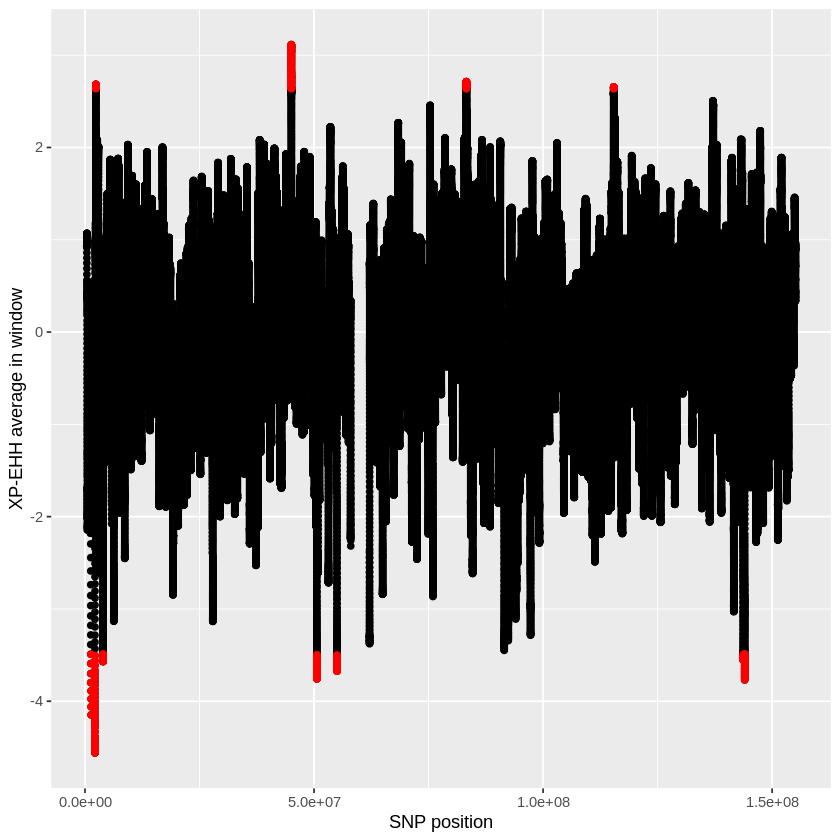

In [60]:
XPEHH_AF_WE_500 <- ggplot()+ 
geom_point(aes(x = XPEHH_mean_AF_WE$begin_pos_SNP, y= XPEHH_mean_AF_WE$XPEHH_mean))+ 
geom_point(aes(x = plotdata_AF_WE_XPEHH_500$begin_pos_SNP, y= plotdata_AF_WE_XPEHH_500$XPEHH_mean), color = 'red')+
xlab('SNP position')+
ylab('XP-EHH average in window') 
XPEHH_AF_WE_500

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,359227,X,137140296,137176547,2.855152
2,359226,X,137139691,137176522,2.853470
3,359228,X,137140972,137176586,2.853421
4,359225,X,137139280,137176403,2.853115
5,359224,X,137139120,137176274,2.852341
6,359229,X,137141008,137177381,2.850379


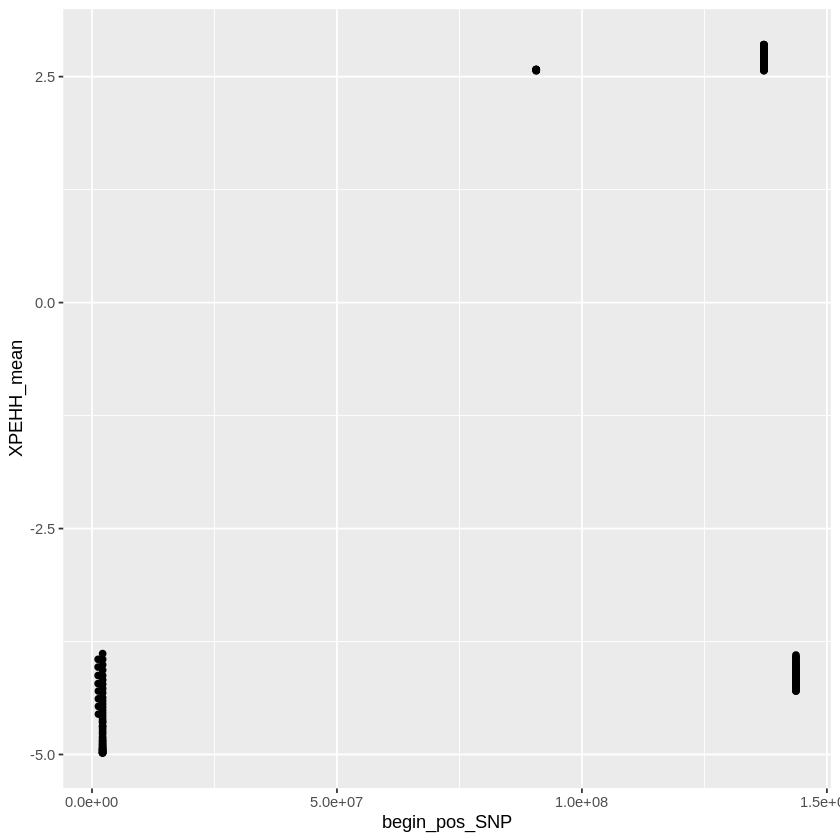

In [81]:
#100 most extreme XPEHH values Africa and East Asia
des_100_AF_EA <- XPEHH_descending_order_AF_EA[1:100,]
asc_100_AF_EA <- XPEHH_ascending_order_AF_EA[1:100,]

plotdata_AF_EA_XPEHH_100 <- bind_rows(des_100_AF_EA, asc_100_AF_EA)
print("Africa and East Asia")
plot_AF_EA_XPEHH_100 <- ggplot(plotdata_AF_EA_XPEHH_100)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_EA_XPEHH_100
head(plotdata_AF_EA_XPEHH_100)


AF_EA_XPEHH__beddata <- plotdata_AF_EA_XPEHH_100 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_XPEHH__beddata))) 
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_XPEHH__beddata, "AF_EA_XPEHH__beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,359227,X,137140296,137176547,2.855152
2,359226,X,137139691,137176522,2.853470
3,359228,X,137140972,137176586,2.853421
4,359225,X,137139280,137176403,2.853115
5,359224,X,137139120,137176274,2.852341
6,359229,X,137141008,137177381,2.850379


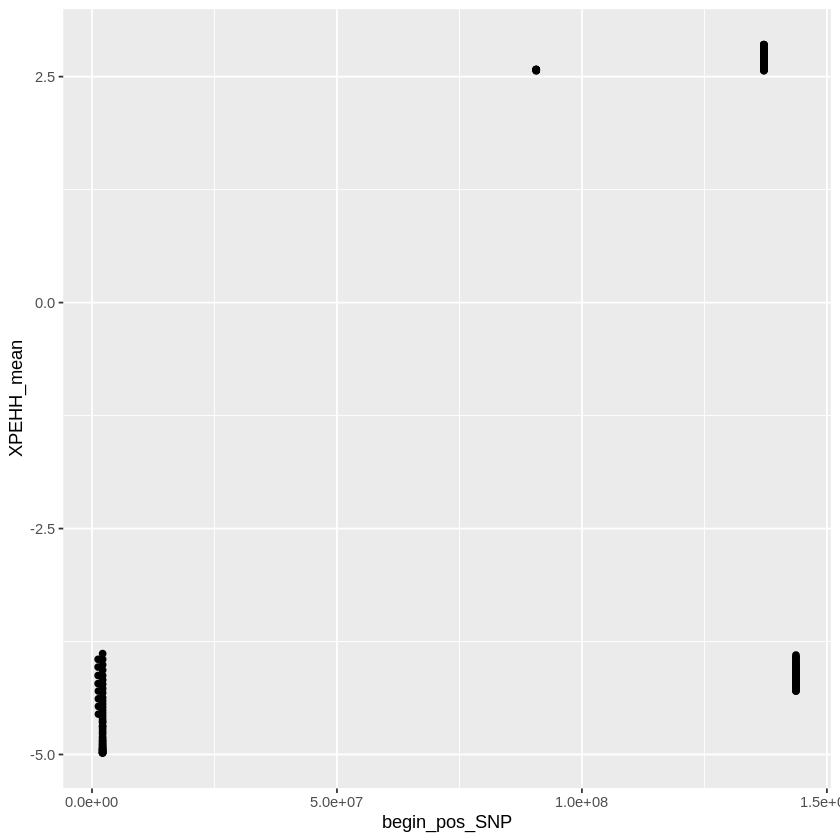

In [80]:
#200 most extreme XPEHH values Africa and East Asia
des_200_AF_EA <- XPEHH_descending_order_AF_EA[1:100,]
asc_200_AF_EA <- XPEHH_ascending_order_AF_EA[1:100,]

plotdata_AF_EA_XPEHH_200 <- bind_rows(des_200_AF_EA, asc_200_AF_EA)
print("Africa and East Asia")
plot_AF_EA_XPEHH_200 <- ggplot(plotdata_AF_EA_XPEHH_200)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_EA_XPEHH_200
head(plotdata_AF_EA_XPEHH_200)


AF_EA_XPEHH__beddata <- plotdata_AF_EA_XPEHH_200 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_XPEHH__beddata))) 
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_XPEHH__beddata, "AF_EA_XPEHH__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "Africa and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,359227,X,137140296,137176547,2.855152
2,359226,X,137139691,137176522,2.853470
3,359228,X,137140972,137176586,2.853421
4,359225,X,137139280,137176403,2.853115
5,359224,X,137139120,137176274,2.852341
6,359229,X,137141008,137177381,2.850379


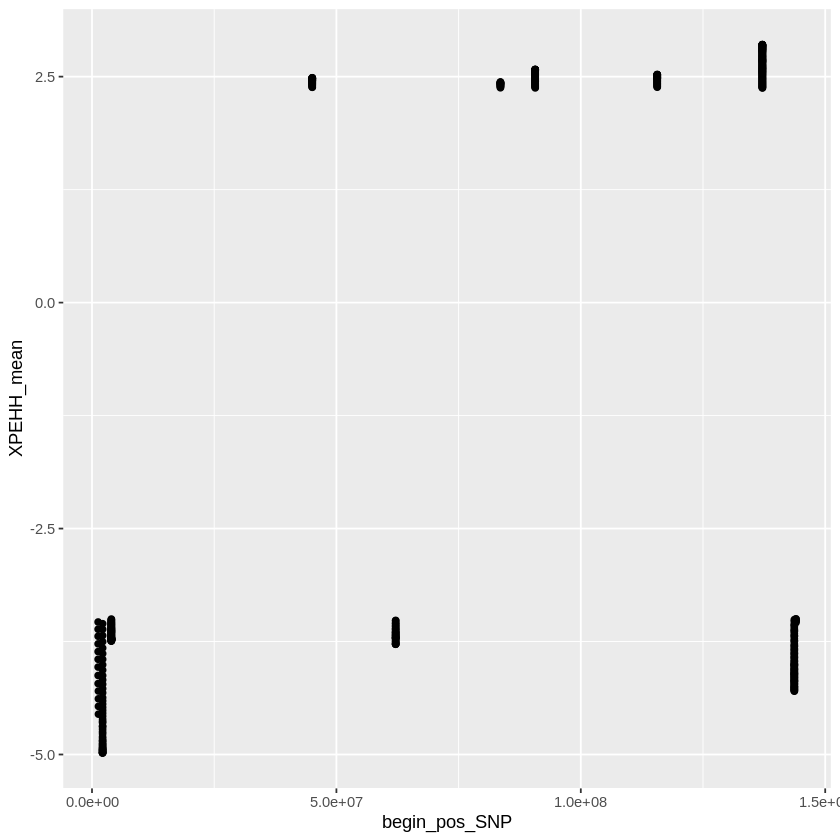

In [61]:
#500 most extreme XPEHH values Africa and East Asia
des_500_AF_EA <- XPEHH_descending_order_AF_EA[1:250,]
asc_500_AF_EA <- XPEHH_ascending_order_AF_EA[1:250,]

plotdata_AF_EA_XPEHH_500 <- bind_rows(des_500_AF_EA, asc_500_AF_EA)
print("Africa and East Asia")
plot_AF_EA_XPEHH_500 <- ggplot(plotdata_AF_EA_XPEHH_500)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_AF_EA_XPEHH_500
head(plotdata_AF_EA_XPEHH_500)


AF_EA_XPEHH__beddata <- plotdata_AF_EA_XPEHH_500 %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_XPEHH__beddata))) 
AF_EA_XPEHH__beddata <- AF_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_XPEHH__beddata, "AF_EA_XPEHH__beddata_500.bed", delim = "\t", col_names = FALSE)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


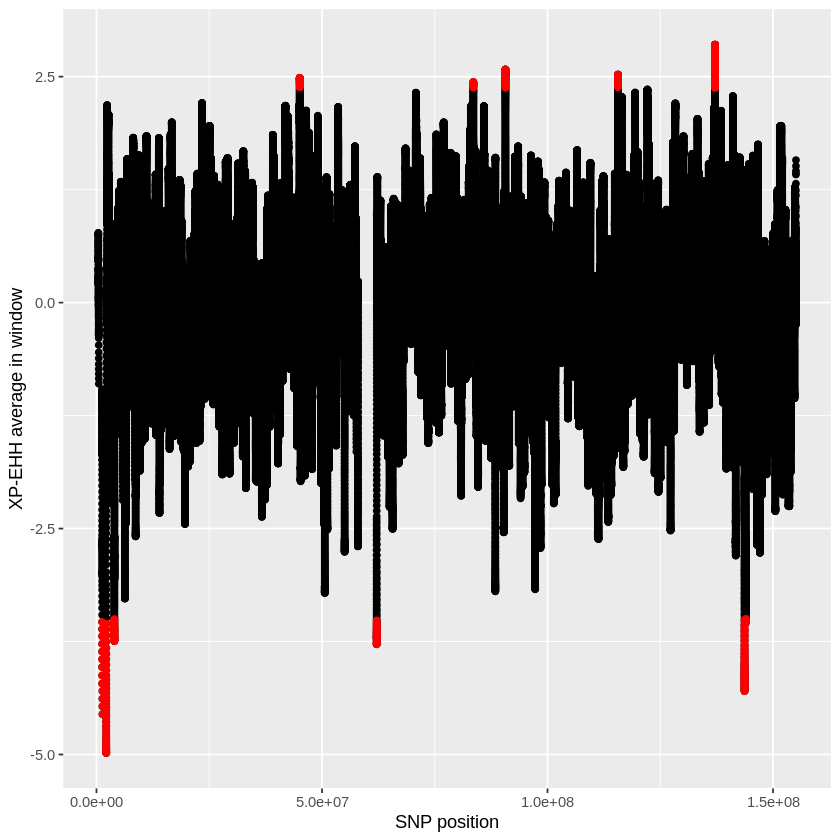

In [62]:
XPEHH_AF_EA_500 <- ggplot()+ 
geom_point(aes(x = XPEHH_mean_AF_EA$begin_pos_SNP, y= XPEHH_mean_AF_EA$XPEHH_mean))+ 
geom_point(aes(x = plotdata_AF_EA_XPEHH_500$begin_pos_SNP, y= plotdata_AF_EA_XPEHH_500$XPEHH_mean), color = 'red')+
xlab('SNP position')+
ylab('XP-EHH average in window') 
XPEHH_AF_EA_500

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,182327,X,72474639,72497228,3.589335
2,182326,X,72474570,72496944,3.586242
3,182328,X,72474931,72497489,3.586140
4,182325,X,72474533,72496916,3.584417
5,182324,X,72474530,72496381,3.582118
6,182329,X,72475225,72498126,3.581701


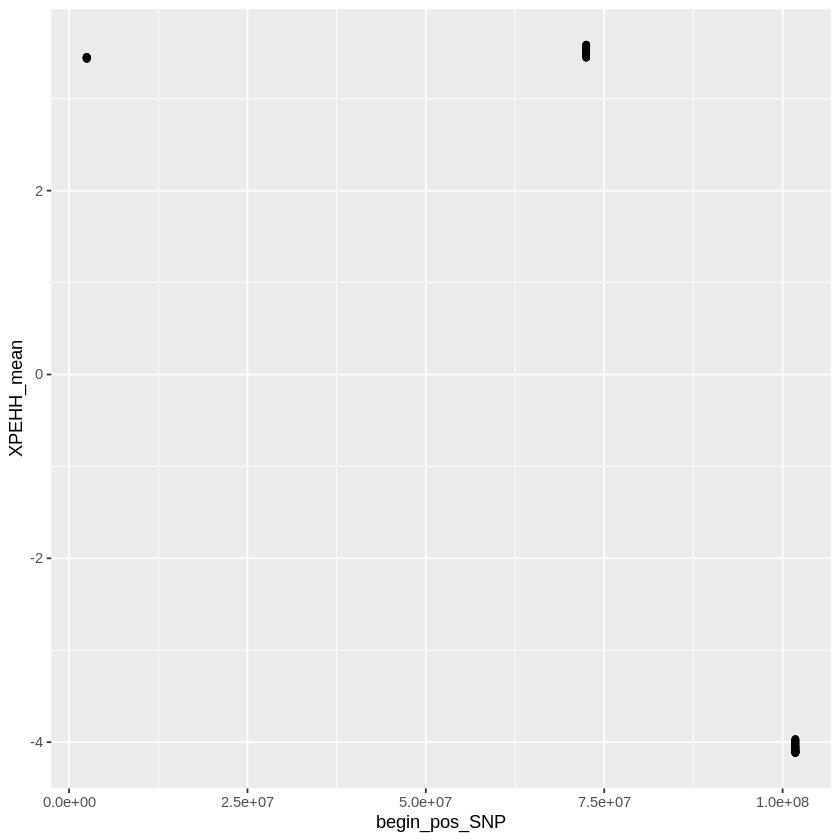

In [77]:
#100 most extreme XPEHH values West Eurasia and East Asia
des_100_WE_EA <- XPEHH_descending_order_WE_EA[1:50,]
asc_100_WE_EA <- XPEHH_ascending_order_WE_EA[1:50,]

plotdata_WE_EA_XPEHH_100 <- bind_rows(des_100_WE_EA, asc_100_WE_EA)
print("West Eurasia and East Asia")
plot_WE_EA_XPEHH_100 <- ggplot(plotdata_WE_EA_XPEHH_100)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_WE_EA_XPEHH_100
head(plotdata_WE_EA_XPEHH_100)


WE_EA_XPEHH__beddata <- plotdata_WE_EA_XPEHH_100 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_XPEHH__beddata))) 
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_XPEHH__beddata, "WE_EA_XPEHH__beddata_100.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,182327,X,72474639,72497228,3.589335
2,182326,X,72474570,72496944,3.586242
3,182328,X,72474931,72497489,3.586140
4,182325,X,72474533,72496916,3.584417
5,182324,X,72474530,72496381,3.582118
6,182329,X,72475225,72498126,3.581701


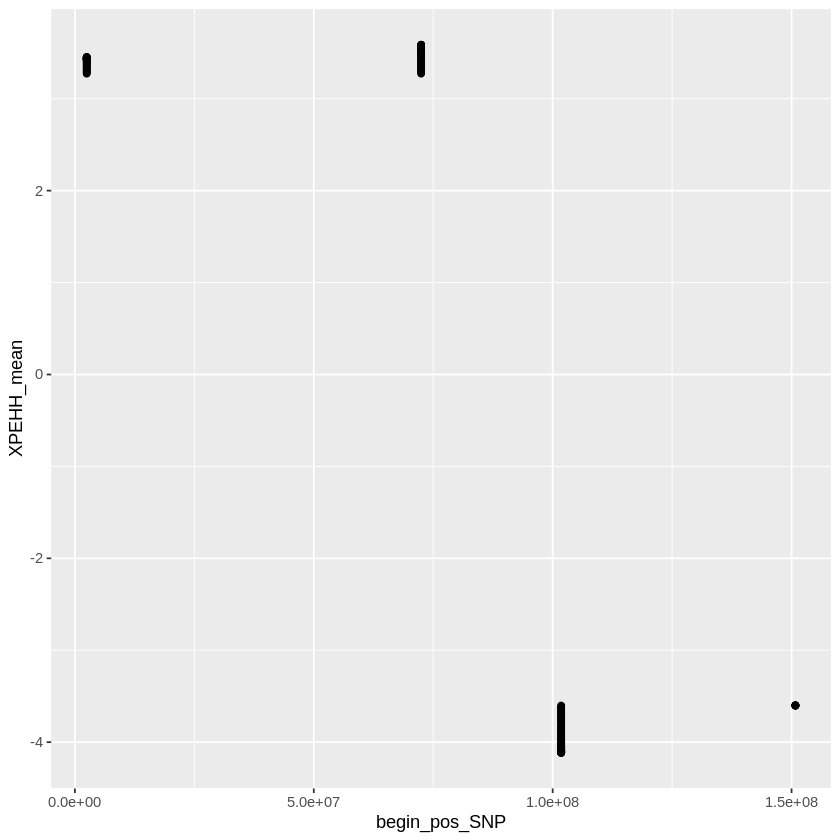

In [78]:
#200 most extreme XPEHH values West Eurasia and East Asia
des_200_WE_EA <- XPEHH_descending_order_WE_EA[1:100,]
asc_200_WE_EA <- XPEHH_ascending_order_WE_EA[1:100,]

plotdata_WE_EA_XPEHH_200 <- bind_rows(des_200_WE_EA, asc_200_WE_EA)
print("West Eurasia and East Asia")
plot_WE_EA_XPEHH_200 <- ggplot(plotdata_WE_EA_XPEHH_200)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_WE_EA_XPEHH_200
head(plotdata_WE_EA_XPEHH_200)


WE_EA_XPEHH__beddata <- plotdata_WE_EA_XPEHH_200 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_XPEHH__beddata))) 
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_XPEHH__beddata, "WE_EA_XPEHH__beddata_200.bed", delim = "\t", col_names = FALSE)

[1] "West Eurasia and East Asia"


,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean
,<int>,<chr>,<int>,<int>,<dbl>
1,182327,X,72474639,72497228,3.589335
2,182326,X,72474570,72496944,3.586242
3,182328,X,72474931,72497489,3.586140
4,182325,X,72474533,72496916,3.584417
5,182324,X,72474530,72496381,3.582118
6,182329,X,72475225,72498126,3.581701


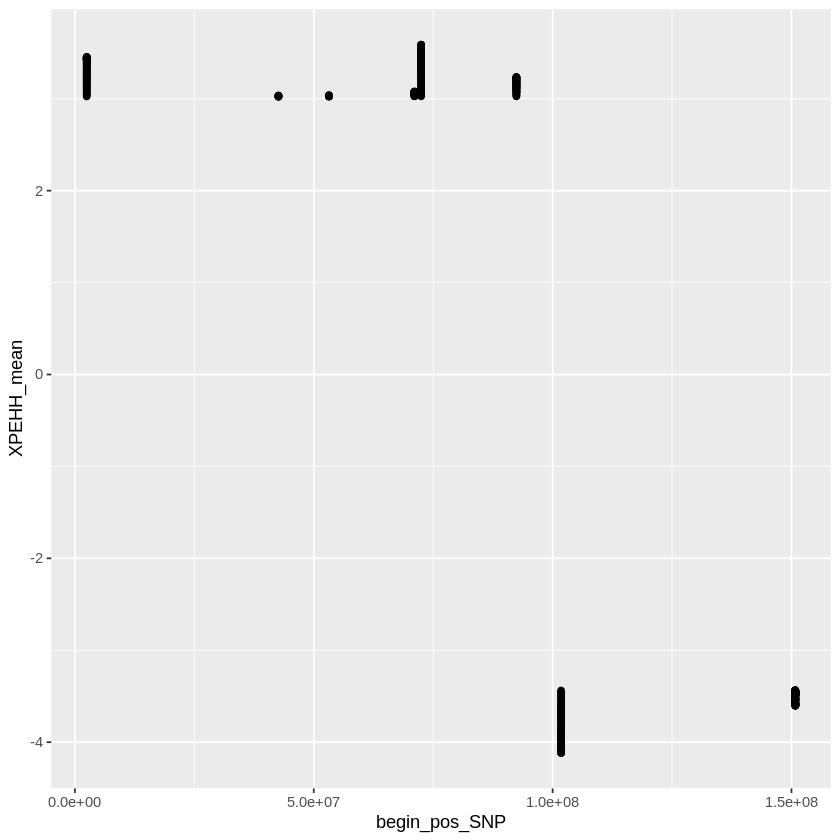

In [63]:
#500 most extreme XPEHH values West Eurasia and East Asia
des_500_WE_EA <- XPEHH_descending_order_WE_EA[1:250,]
asc_500_WE_EA <- XPEHH_ascending_order_WE_EA[1:250,]

plotdata_WE_EA_XPEHH_500 <- bind_rows(des_500_WE_EA, asc_500_WE_EA)
print("West Eurasia and East Asia")
plot_WE_EA_XPEHH_500 <- ggplot(plotdata_WE_EA_XPEHH_500)+ geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean))
plot_WE_EA_XPEHH_500
head(plotdata_WE_EA_XPEHH_500)


WE_EA_XPEHH__beddata <- plotdata_WE_EA_XPEHH_500 %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_XPEHH__beddata))) 
WE_EA_XPEHH__beddata <- WE_EA_XPEHH__beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_XPEHH__beddata, "WE_EA_XPEHH__beddata_500.bed", delim = "\t", col_names = FALSE)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


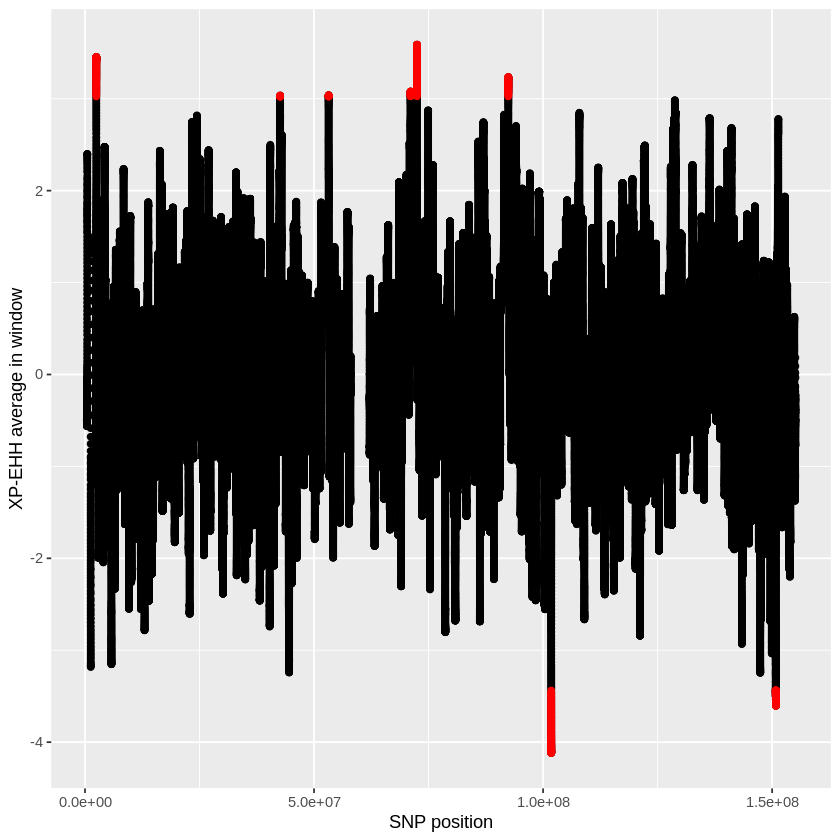

In [64]:
XPEHH_WE_EA_500 <- ggplot()+ 
geom_point(aes(x = XPEHH_mean_WE_EA$begin_pos_SNP, y= XPEHH_mean_WE_EA$XPEHH_mean))+ 
geom_point(aes(x = plotdata_WE_EA_XPEHH_500$begin_pos_SNP, y= plotdata_WE_EA_XPEHH_500$XPEHH_mean), color = 'red')+
xlab('SNP position')+
ylab('XP-EHH average in window') 
XPEHH_WE_EA_500

,X,chr,begin_pos_SNP,end_pos_SNP,XPEHH_mean,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,140253,X,45034956,45051656,3.115016,Africa_WestEurasia
2,140254,X,45034961,45051755,3.112900,Africa_WestEurasia
3,140252,X,45034955,45051427,3.112205,Africa_WestEurasia
4,140255,X,45034962,45052413,3.110590,Africa_WestEurasia
5,140251,X,45034954,45051304,3.109697,Africa_WestEurasia
6,140256,X,45034963,45052503,3.108682,Africa_WestEurasia


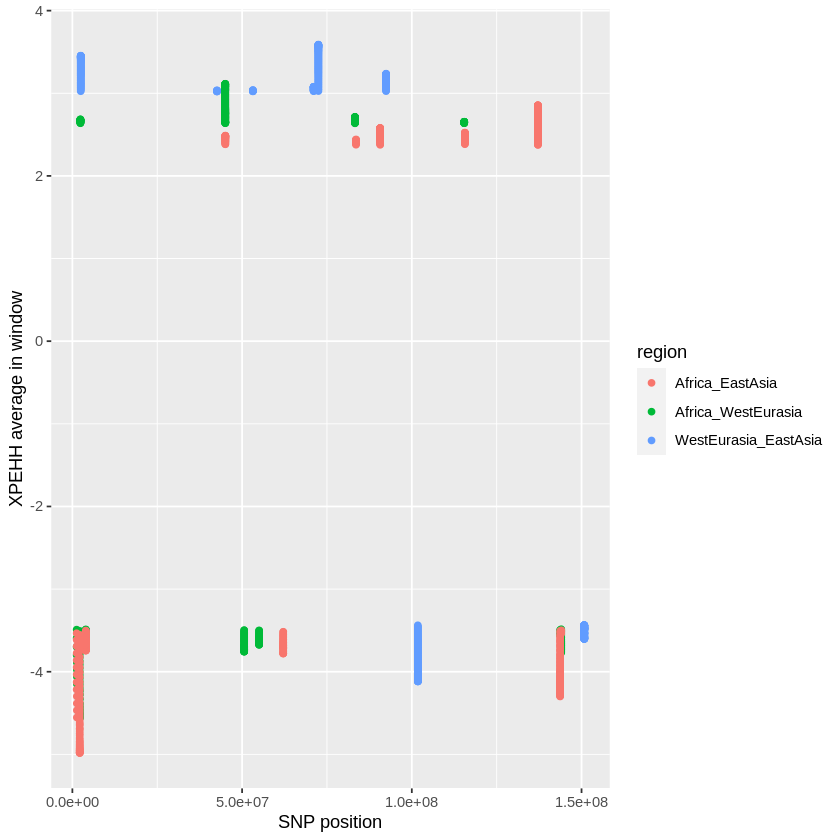

In [66]:
plotdata_AF_WE_XPEHH_500 <- plotdata_AF_WE_XPEHH_500 %>% mutate(region = rep('Africa_WestEurasia', nrow(plotdata_AF_WE_XPEHH_500)))
plotdata_AF_EA_XPEHH_500 <- plotdata_AF_EA_XPEHH_500 %>% mutate(region = rep('Africa_EastAsia', nrow(plotdata_AF_EA_XPEHH_500)))
plotdata_WE_EA_XPEHH_500 <- plotdata_WE_EA_XPEHH_500 %>% mutate(region = rep('WestEurasia_EastAsia', nrow(plotdata_WE_EA_XPEHH_500)))
XPEHH_500_all <- bind_rows(plotdata_AF_WE_XPEHH_500, plotdata_AF_EA_XPEHH_500, plotdata_WE_EA_XPEHH_500)
head(XPEHH_500_all)

plot_XPEHH_500_all <- ggplot(XPEHH_500_all) + geom_point(aes(x = begin_pos_SNP, y= XPEHH_mean, color = region))+
xlab('SNP position')+
ylab('XPEHH average in window') 
plot_XPEHH_500_all

In [30]:
#Afrika and West Eurasia
print('Africa and West Eurasia 100')
AF_WE_XPEHH_100 <- read.csv('AF_WE_XPEHH_100.bed', sep = '\t', header = FALSE)
AF_WE_XPEHH_100  <- AF_WE_XPEHH_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_XPEHH_100)
genesAF_WE_XPEHH_100 <- unique(AF_WE_XPEHH_100[c("V7")])
genesAF_WE_XPEHH_100

print('Africa and West Eurasia 200')
AF_WE_XPEHH_200 <- read.csv('AF_WE_XPEHH_200.bed', sep = '\t', header = FALSE)
AF_WE_XPEHH_200  <- AF_WE_XPEHH_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_XPEHH_200)
genesAF_WE_XPEHH_200 <- unique(AF_WE_XPEHH_200[c("V7")])
genesAF_WE_XPEHH_200

print('Africa and West Eurasia 500')
AF_WE_XPEHH_500 <- read.csv('AF_WE_XPEHH_500.bed', sep = '\t', header = FALSE)
AF_WE_XPEHH_500  <- AF_WE_XPEHH_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_XPEHH_500)
genesAF_WE_XPEHH_500 <- unique(AF_WE_XPEHH_500[c("V7")])
genesAF_WE_XPEHH_500

#West Eurasia and East Asia
print('West Eurasia and East Asia 100')
WE_EA_XPEHH_100 <- read.csv('WE_EA_XPEHH_100.bed', sep = '\t', header = FALSE)
WE_EA_XPEHH_100  <- WE_EA_XPEHH_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_XPEHH_100)
genesWE_EA_XPEHH_100 <- unique(WE_EA_XPEHH_100[c("V7")])
genesWE_EA_XPEHH_100

print('West Eurasia and East Asia 200')
WE_EA_XPEHH_200 <- read.csv('WE_EA_XPEHH_200.bed', sep = '\t', header = FALSE)
WE_EA_XPEHH_200  <- WE_EA_XPEHH_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_XPEHH_200)
genesWE_EA_XPEHH_200 <- unique(WE_EA_XPEHH_200[c("V7")])
genesWE_EA_XPEHH_200

print('West Eurasia and East Asia 500')
WE_EA_XPEHH_500 <- read.csv('WE_EA_XPEHH_500.bed', sep = '\t', header = FALSE)
WE_EA_XPEHH_500  <- WE_EA_XPEHH_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_XPEHH_500)
genesWE_EA_XPEHH_500 <- unique(WE_EA_XPEHH_500[c("V7")])
genesWE_EA_XPEHH_500

#Africa and East Asia
print('Africa and East Asia 100')
AF_EA_XPEHH_100 <- read.csv('AF_EA_XPEHH_100.bed', sep = '\t', header = FALSE)
AF_EA_XPEHH_100  <- AF_EA_XPEHH_100 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_EA_XPEHH_100)
genesAF_EA_XPEHH_100 <- unique(AF_EA_XPEHH_100[c("V7")])
genesAF_EA_XPEHH_100

print('Africa and East Asia200')
AF_EA_XPEHH_200 <- read.csv('AF_EA_XPEHH_200.bed', sep = '\t', header = FALSE)
AF_EA_XPEHH_200  <- AF_EA_XPEHH_200 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_EA_XPEHH_200)
genesAF_EA_XPEHH_200 <- unique(AF_EA_XPEHH_200[c("V7")])
genesAF_EA_XPEHH_200

print('Africa and East Asia 500')
AF_EA_XPEHH_500 <- read.csv('AF_EA_XPEHH_500.bed', sep = '\t', header = FALSE)
AF_EA_XPEHH_500  <- AF_EA_XPEHH_500 %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_EA_XPEHH_500)
genesAF_EA_XPEHH_500 <- unique(AF_EA_XPEHH_500[c("V7")])
genesAF_EA_XPEHH_500

[1] "Africa and West Eurasia 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,45034956,45051656,chrX,45050995,45051260,ENSG00000147113.17_3,265
2,chrX,45034956,45051656,chrX,45042495,45042674,ENSG00000229491.5_5,179
3,chrX,45034961,45051755,chrX,45050995,45051260,ENSG00000147113.17_3,265
4,chrX,45034961,45051755,chrX,45042495,45042674,ENSG00000229491.5_5,179
5,chrX,45034955,45051427,chrX,45050995,45051260,ENSG00000147113.17_3,265
6,chrX,45034955,45051427,chrX,45042495,45042674,ENSG00000229491.5_5,179


,V7
,<chr>
1,ENSG00000147113.17_3
2,ENSG00000229491.5_5
101,ENSG00000169084.13_4
110,ENSG00000223571.6_5
143,ENSG00000205755.11_2
144,ENSG00000198223.16_4
145,ENSG00000264510.1
146,ENSG00000264819.1
147,ENSG00000263980.1


[1] "Africa and West Eurasia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,45034956,45051656,chrX,45050995,45051260,ENSG00000147113.17_3,265
2,chrX,45034956,45051656,chrX,45042495,45042674,ENSG00000229491.5_5,179
3,chrX,45034961,45051755,chrX,45050995,45051260,ENSG00000147113.17_3,265
4,chrX,45034961,45051755,chrX,45042495,45042674,ENSG00000229491.5_5,179
5,chrX,45034955,45051427,chrX,45050995,45051260,ENSG00000147113.17_3,265
6,chrX,45034955,45051427,chrX,45042495,45042674,ENSG00000229491.5_5,179


,V7
,<chr>
1,ENSG00000147113.17_3
2,ENSG00000229491.5_5
201,ENSG00000169084.13_4
210,ENSG00000223571.6_5
243,ENSG00000205755.11_2
244,ENSG00000198223.16_4
245,ENSG00000264510.1
246,ENSG00000264819.1
247,ENSG00000263980.1


[1] "Africa and West Eurasia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,45034956,45051656,chrX,45050995,45051260,ENSG00000147113.17_3,265
2,chrX,45034956,45051656,chrX,45042495,45042674,ENSG00000229491.5_5,179
3,chrX,45034961,45051755,chrX,45050995,45051260,ENSG00000147113.17_3,265
4,chrX,45034961,45051755,chrX,45042495,45042674,ENSG00000229491.5_5,179
5,chrX,45034955,45051427,chrX,45050995,45051260,ENSG00000147113.17_3,265
6,chrX,45034955,45051427,chrX,45042495,45042674,ENSG00000229491.5_5,179


,V7
,<chr>
1,ENSG00000147113.17_3
2,ENSG00000229491.5_5
249,ENSG00000169084.13_4
321,ENSG00000223571.6_5
354,ENSG00000205755.11_2
355,ENSG00000198223.16_4
356,ENSG00000264510.1
357,ENSG00000264819.1
358,ENSG00000263980.1


[1] "West Eurasia and East Asia 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,72474639,72497228,chrX,72494620,72495351,ENSG00000225664.3_4,731
2,chrX,72474570,72496944,chrX,72494620,72495351,ENSG00000225664.3_4,731
3,chrX,72474931,72497489,chrX,72494620,72495351,ENSG00000225664.3_4,731
4,chrX,72474533,72496916,chrX,72494620,72495351,ENSG00000225664.3_4,731
5,chrX,72474530,72496381,chrX,72494620,72495351,ENSG00000225664.3_4,731
6,chrX,72475225,72498126,chrX,72494620,72495351,ENSG00000225664.3_4,731


,V7
,<chr>
1,ENSG00000225664.3_4
29,ENSG00000176318.8_4
30,ENSG00000196970.8_2


[1] "West Eurasia and East Asia 200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,72474639,72497228,chrX,72494620,72495351,ENSG00000225664.3_4,731
2,chrX,72474570,72496944,chrX,72494620,72495351,ENSG00000225664.3_4,731
3,chrX,72474931,72497489,chrX,72494620,72495351,ENSG00000225664.3_4,731
4,chrX,72474533,72496916,chrX,72494620,72495351,ENSG00000225664.3_4,731
5,chrX,72474530,72496381,chrX,72494620,72495351,ENSG00000225664.3_4,731
6,chrX,72475225,72498126,chrX,72494620,72495351,ENSG00000225664.3_4,731


,V7
,<chr>
1,ENSG00000225664.3_4
36,ENSG00000176318.8_4
37,ENSG00000196970.8_2
213,ENSG00000239429.1
214,ENSG00000166049.11_4


[1] "West Eurasia and East Asia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,72474639,72497228,chrX,72494620,72495351,ENSG00000225664.3_4,731
2,chrX,72474570,72496944,chrX,72494620,72495351,ENSG00000225664.3_4,731
3,chrX,72474931,72497489,chrX,72494620,72495351,ENSG00000225664.3_4,731
4,chrX,72474533,72496916,chrX,72494620,72495351,ENSG00000225664.3_4,731
5,chrX,72474530,72496381,chrX,72494620,72495351,ENSG00000225664.3_4,731
6,chrX,72475225,72498126,chrX,72494620,72495351,ENSG00000225664.3_4,731


,V7
,<chr>
1,ENSG00000225664.3_4
44,ENSG00000283178.1_5
68,ENSG00000227329.2_5
69,ENSG00000126012.11_4
70,ENSG00000235262.1_5
71,ENSG00000124313.15_6
72,ENSG00000232593.7_4
119,ENSG00000176318.8_4
120,ENSG00000196970.8_2


[1] "Africa and East Asia 100"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90669453,90695261,chrX,90673782,90673870,ENSG00000234161.1_5,88
2,chrX,90669453,90695261,chrX,90677307,90677537,ENSG00000236413.2_5,230
3,chrX,90669453,90695261,chrX,90689593,90691999,ENSG00000174740.8_4,2406
4,chrX,90669439,90695017,chrX,90673782,90673870,ENSG00000234161.1_5,88
5,chrX,90669439,90695017,chrX,90677307,90677537,ENSG00000236413.2_5,230
6,chrX,90669439,90695017,chrX,90689593,90691999,ENSG00000174740.8_4,2406


,V7
,<chr>
1,ENSG00000234161.1_5
2,ENSG00000236413.2_5
3,ENSG00000174740.8_4
46,ENSG00000169084.13_4
55,ENSG00000223571.6_5
90,ENSG00000205755.11_2
91,ENSG00000198223.16_4
92,ENSG00000264510.1
93,ENSG00000264819.1


[1] "Africa and East Asia200"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90669453,90695261,chrX,90673782,90673870,ENSG00000234161.1_5,88
2,chrX,90669453,90695261,chrX,90677307,90677537,ENSG00000236413.2_5,230
3,chrX,90669453,90695261,chrX,90689593,90691999,ENSG00000174740.8_4,2406
4,chrX,90669439,90695017,chrX,90673782,90673870,ENSG00000234161.1_5,88
5,chrX,90669439,90695017,chrX,90677307,90677537,ENSG00000236413.2_5,230
6,chrX,90669439,90695017,chrX,90689593,90691999,ENSG00000174740.8_4,2406


,V7
,<chr>
1,ENSG00000234161.1_5
2,ENSG00000236413.2_5
3,ENSG00000174740.8_4
46,ENSG00000169084.13_4
55,ENSG00000223571.6_5
90,ENSG00000205755.11_2
91,ENSG00000198223.16_4
92,ENSG00000264510.1
93,ENSG00000264819.1


[1] "Africa and East Asia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90669453,90695261,chrX,90673782,90673870,ENSG00000234161.1_5,88
2,chrX,90669453,90695261,chrX,90677307,90677537,ENSG00000236413.2_5,230
3,chrX,90669453,90695261,chrX,90689593,90691999,ENSG00000174740.8_4,2406
4,chrX,90669439,90695017,chrX,90673782,90673870,ENSG00000234161.1_5,88
5,chrX,90669439,90695017,chrX,90677307,90677537,ENSG00000236413.2_5,230
6,chrX,90669439,90695017,chrX,90689593,90691999,ENSG00000174740.8_4,2406


,V7
,<chr>
1,ENSG00000234161.1_5
2,ENSG00000236413.2_5
3,ENSG00000174740.8_4
109,ENSG00000147113.17_3
110,ENSG00000229491.5_5
166,ENSG00000165259.14_4
224,ENSG00000169084.13_4
233,ENSG00000223571.6_5
268,ENSG00000205755.11_2


**Exercise D**

 Intersect the analysis of Fst and XP-EHH.

This analysis was done manually by checking if the genes that were found are the same, and the results can be found below. For none of the regions comparisons, the genes seem to overlap. 

In [94]:
Fst_XPEHH_AF_WE <- intersect(genesAF_WE_500, genesAF_WE_XPEHH_500)
Fst_XPEHH_AF_WE

Fst_XPEHH_AF_EA <- intersect(genesEA_AF_500, genesAF_EA_XPEHH_500)
Fst_XPEHH_AF_EA

Fst_XPEHH_WE_EA <- intersect(genesWE_EA_500, genesWE_EA_XPEHH_500)
Fst_XPEHH_WE_EA

V7
<chr>


V7
<chr>


V7
<chr>


**Exercise E**

Perform any additional analysis of your own choice, such as (diversity along the X chromosome).

In this exercise I decided to make a tree, based on the Fst values calculated in the first exercise, and based on the neighbor joining technique. 
I also re-run the first exercise where removing NA values instead of making them 0, to see how that would change the analysis. 


***Tree based on the distance matrix***

In [3]:
#I saved all those tables as csv files, so I can read them in again: 
Fst_AF_WE_per_pos <- read.csv("Fst_AF_WE_per_pos.csv")
Fst_AF_WE_per_pos[is.na(Fst_AF_WE_per_pos)] <- 0 
head(Fst_AF_WE_per_pos)

Fst_AF_EA_per_pos <- read.csv("Fst_EA_AF_per_pos.csv")
Fst_AF_EA_per_pos[is.na(Fst_AF_EA_per_pos)] <- 0 
head(Fst_AF_EA_per_pos)

Fst_WE_EA_per_pos <- read.csv("Fst_WE_EA_per_pos.csv")
Fst_WE_EA_per_pos[is.na(Fst_WE_EA_per_pos)] <- 0 
head(Fst_WE_EA_per_pos)



Fst_AF_AM_per_pos <- read.csv("Fst_AF_AM_per_pos.csv")
Fst_AF_AM_per_pos[is.na(Fst_AF_AM_per_pos)] <- 0 
head(Fst_AF_AM_per_pos)

Fst_AF_CAS_per_pos <- read.csv("Fst_AF_CAS_per_pos.csv")
Fst_AF_CAS_per_pos[is.na(Fst_AF_CAS_per_pos)] <- 0 
head(Fst_AF_CAS_per_pos)

Fst_AF_O_per_pos <- read.csv("Fst_AF_O_per_pos.csv")
Fst_AF_O_per_pos[is.na(Fst_AF_O_per_pos)] <- 0 
head(Fst_AF_O_per_pos)

Fst_AF_SA_per_pos <- read.csv("Fst_AF_SA_per_pos.csv")
Fst_AF_SA_per_pos[is.na(Fst_AF_SA_per_pos)] <- 0 
head(Fst_AF_SA_per_pos)

Fst_AM_CAS_per_pos <- read.csv("Fst_AM_CAS_per_pos.csv")
Fst_AM_CAS_per_pos[is.na(Fst_AM_CAS_per_pos)] <- 0 
head(Fst_AM_CAS_per_pos)


Fst_AM_EA_per_pos <- read.csv("Fst_AM_EA_per_pos.csv")
Fst_AM_EA_per_pos[is.na(Fst_AM_EA_per_pos)] <- 0 
head(Fst_AM_EA_per_pos)


Fst_AM_O_per_pos <- read.csv("Fst_AM_O_per_pos.csv")
Fst_AM_O_per_pos[is.na(Fst_AM_O_per_pos)] <- 0 
head(Fst_AM_O_per_pos)


Fst_AM_SA_per_pos <- read.csv("Fst_AM_SA_per_pos.csv")
Fst_AM_SA_per_pos[is.na(Fst_AM_SA_per_pos)] <- 0 
head(Fst_AM_SA_per_pos)


Fst_AM_WE_per_pos <- read.csv("Fst_AM_WE_per_pos.csv")
Fst_AM_WE_per_pos[is.na(Fst_AM_WE_per_pos)] <- 0 
head(Fst_AM_WE_per_pos)


Fst_CAS_EA_per_pos <- read.csv("Fst_CAS_EA_per_pos.csv")
Fst_CAS_EA_per_pos[is.na(Fst_CAS_EA_per_pos)] <- 0 
head(Fst_CAS_EA_per_pos)

Fst_CAS_O_per_pos <- read.csv("Fst_CAS_O_per_pos.csv")
Fst_CAS_O_per_pos[is.na(Fst_CAS_O_per_pos)] <- 0 
head(Fst_CAS_O_per_pos)

Fst_CAS_SA_per_pos <- read.csv("Fst_CAS_SA_per_pos.csv")
Fst_CAS_SA_per_pos[is.na(Fst_CAS_SA_per_pos)] <- 0 
head(Fst_CAS_SA_per_pos)

Fst_CAS_WE_per_pos <- read.csv("Fst_CAS_WE_per_pos.csv")
Fst_CAS_WE_per_pos[is.na(Fst_CAS_WE_per_pos)] <- 0 
head(Fst_CAS_WE_per_pos)

Fst_EA_O_per_pos <- read.csv("Fst_EA_O_per_pos.csv")
Fst_EA_O_per_pos[is.na(Fst_EA_O_per_pos)] <- 0 
head(Fst_EA_O_per_pos)

Fst_EA_SA_per_pos <- read.csv("Fst_EA_SA_per_pos.csv")
Fst_EA_SA_per_pos[is.na(Fst_EA_SA_per_pos)] <- 0 
head(Fst_EA_SA_per_pos)

Fst_O_SA_per_pos <- read.csv("Fst_O_SA_per_pos.csv")
Fst_O_SA_per_pos[is.na(Fst_O_SA_per_pos)] <- 0 
head(Fst_O_SA_per_pos)

Fst_O_WE_per_pos <- read.csv("Fst_O_WE_per_pos.csv")
Fst_O_WE_per_pos[is.na(Fst_O_WE_per_pos)] <- 0 
head(Fst_O_WE_per_pos)

Fst_SA_WE_per_pos <- read.csv("Fst_SA_WE_per_pos.csv")
Fst_SA_WE_per_pos[is.na(Fst_SA_WE_per_pos)] <- 0 
head(Fst_SA_WE_per_pos)

,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.23285147,0.47952098,0.51440816
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.46723262,0.49985008,0.06525448


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.000000e+00
2,2,X,400000,0.04535147,0.04648526,2.439024e-02
3,3,X,400108,0.26757370,0.45918367,4.172840e-01
4,4,X,400132,0.18140590,0.20975057,1.351351e-01
5,5,X,400148,0.00000000,0.00000000,0.000000e+00
6,6,X,400303,0.47020266,0.47022038,3.767472e-05


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,0.000000000
2,2,X,400000,0.0000000,0.0000000,0.000000000
3,3,X,400108,0.4097222,0.4131944,0.008403361
4,4,X,400132,0.0000000,0.0000000,0.000000000
5,5,X,400148,0.0000000,0.0000000,0.000000000
6,6,X,400303,0.4657800,0.4999354,0.068319773


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.04535147,0.49886621,0.90909091
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.37471655,0.39767574,0.05773343


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.04535147,0.49886621,0.90909091
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.47020266,0.49998228,0.05956135


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.043478261
2,2,X,400000,0.04535147,0.04648526,0.024390244
3,3,X,400108,0.12174036,0.12237812,0.005211349
4,4,X,400132,0.18140590,0.20975057,0.135135135
5,5,X,400148,0.00000000,0.00000000,0.000000000
6,6,X,400303,0.45804989,0.45918367,0.002469136


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.04535147,0.04648526,0.02439024
3,3,X,400108,0.28535147,0.43791383,0.34838442
4,4,X,400132,0.18140590,0.20975057,0.13513514
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.43138322,0.43791383,0.01491301


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,0.0000000
2,2,X,400000,0.0000000,0.0000000,0.0000000
3,3,X,400108,0.0000000,0.0000000,0.0000000
4,4,X,400132,0.0000000,0.0000000,0.0000000
5,5,X,400148,0.0000000,0.0000000,0.0000000
6,6,X,400303,0.3732639,0.4782986,0.2196007


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,0.00000000
2,2,X,400000,0.0000000,0.0000000,0.00000000
3,3,X,400108,0.2222222,0.2777778,0.20000000
4,4,X,400132,0.0000000,0.0000000,0.00000000
5,5,X,400148,0.0000000,0.0000000,0.00000000
6,6,X,400303,0.3732639,0.3949653,0.05494505


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.04347826
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.07638889,0.49652778,0.84615385
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.36111111,0.37500000,0.03703704


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.24000000,0.32000000,0.25000000
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.33444444,0.33944444,0.01472995


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,0.0000000
2,2,X,400000,0.0000000,0.0000000,0.0000000
3,3,X,400108,0.1875000,0.2187500,0.1428571
4,4,X,400132,0.0000000,0.0000000,0.0000000
5,5,X,400148,0.0000000,0.0000000,0.0000000
6,6,X,400303,0.3702938,0.4806015,0.2295199


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.0000000,0.0000000,0.0000
2,2,X,400000,0.0000000,0.0000000,0.0000
3,3,X,400108,0.2222222,0.2777778,0.2000
4,4,X,400132,0.0000000,0.0000000,0.0000
5,5,X,400148,0.0000000,0.0000000,0.0000
6,6,X,400303,0.4687500,0.5000000,0.0625


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.04347826
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.07638889,0.49652778,0.84615385
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.45659722,0.49913194,0.08521739


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.24000000,0.32000000,0.25000000
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.42993056,0.49413194,0.12992762


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000,0.0000000,0.0000000000
2,2,X,400000,0.00000,0.0000000,0.0000000000
3,3,X,400108,0.18750,0.2187500,0.1428571429
4,4,X,400132,0.00000,0.0000000,0.0000000000
5,5,X,400148,0.00000,0.0000000,0.0000000000
6,6,X,400303,0.46578,0.4658445,0.0001386001


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.043478261
2,2,X,400000,0.00000000,0.00000000,0.000000000
3,3,X,400108,0.29861111,0.46875000,0.362962963
4,4,X,400132,0.00000000,0.00000000,0.000000000
5,5,X,400148,0.00000000,0.00000000,0.000000000
6,6,X,400303,0.45659722,0.45746528,0.001897533


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.000000000
2,2,X,400000,0.00000000,0.00000000,0.000000000
3,3,X,400108,0.46222222,0.46444444,0.004784689
4,4,X,400132,0.00000000,0.00000000,0.000000000
5,5,X,400148,0.03222222,0.03277778,0.016949153
6,6,X,400303,0.42993056,0.43579861,0.013465063


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.043478261
2,2,X,400000,0.00000000,0.00000000,0.000000000
3,3,X,400108,0.31638889,0.44986111,0.296696511
4,4,X,400132,0.00000000,0.00000000,0.000000000
5,5,X,400148,0.03222222,0.03277778,0.016949153
6,6,X,400303,0.41777778,0.42000000,0.005291005


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.07638889,0.07986111,0.04347826
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.26388889,0.48611111,0.45714286
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.00000000,0.00000000,0.00000000
6,6,X,400303,0.45362718,0.49954086,0.09191176


,X,chr,pos,HS,HT,Fst
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,X,365712,0.00000000,0.00000000,0.00000000
2,2,X,400000,0.00000000,0.00000000,0.00000000
3,3,X,400108,0.42750000,0.43875000,0.02564103
4,4,X,400132,0.00000000,0.00000000,0.00000000
5,5,X,400148,0.03222222,0.03277778,0.01694915
6,6,X,400303,0.42696051,0.49529844,0.13797323


Creating of the distance matrix: 

In [14]:
Dist_AF_WE <- mean(Fst_AF_WE_per_pos$Fst)
Dist_AF_EA <- mean(Fst_AF_EA_per_pos$Fst)
Dist_WE_EA <- mean(Fst_WE_EA_per_pos$Fst)

Dist_AF_AM <- mean(Fst_AF_AM_per_pos$Fst)
Dist_AF_CAS <- mean(Fst_AF_CAS_per_pos$Fst)
Dist_AF_O <- mean(Fst_AF_O_per_pos$Fst)
Dist_AF_SA <- mean(Fst_AF_SA_per_pos$Fst)
Dist_AM_CAS <- mean(Fst_AM_CAS_per_pos$Fst)
Dist_AM_EA <- mean(Fst_AM_EA_per_pos$Fst)
Dist_AM_O <- mean(Fst_AM_O_per_pos$Fst)
Dist_AM_SA <- mean(Fst_AM_SA_per_pos$Fst)
Dist_AM_WE <- mean(Fst_AM_WE_per_pos$Fst)
Dist_CAS_EA <- mean(Fst_CAS_EA_per_pos$Fst)
Dist_CAS_O <- mean(Fst_CAS_O_per_pos$Fst)
Dist_CAS_SA <- mean(Fst_CAS_SA_per_pos$Fst)
Dist_CAS_WE <- mean(Fst_CAS_WE_per_pos$Fst)
Dist_EA_O <- mean(Fst_EA_O_per_pos$Fst)
Dist_EA_SA <- mean(Fst_EA_SA_per_pos$Fst)
Dist_O_SA <- mean(Fst_O_SA_per_pos$Fst)
Dist_O_WE <- mean(Fst_O_WE_per_pos$Fst)
Dist_SA_WE <- mean(Fst_SA_WE_per_pos$Fst)

In [15]:
distance_matrix <- rbind(
                         c( 0, Dist_AF_WE, Dist_AF_EA, Dist_AF_AM, Dist_AF_CAS, Dist_AF_O, Dist_AF_SA),
                         c( Dist_AF_WE, 0, Dist_WE_EA, Dist_AM_WE, Dist_CAS_WE, Dist_O_WE, Dist_SA_WE), 
                         c(Dist_AF_EA, Dist_WE_EA, 0, Dist_AM_EA, Dist_CAS_EA, Dist_EA_O, Dist_EA_SA ),
                         c( Dist_AF_AM, Dist_AM_WE, Dist_AM_EA, 0, Dist_AM_CAS, Dist_AM_O, Dist_AM_SA),
                         c( Dist_AF_CAS, Dist_CAS_WE, Dist_CAS_EA, Dist_AM_WE, 0, Dist_CAS_O, Dist_CAS_SA),
                         c( Dist_AF_O, Dist_O_WE, Dist_EA_O, Dist_AM_O, Dist_CAS_O, 0, Dist_O_SA), 
                         c( Dist_AF_SA, Dist_SA_WE, Dist_EA_SA, Dist_AM_SA,  Dist_CAS_SA, Dist_O_SA, 0))


names = c('Africa', 'West Eurasia', 'East Asia', 'America', 'Central Asia Siberia', 'Oceania', 'South Asia')
dimnames(distance_matrix) <- list(names, names)

In [16]:
distance_matrix

,Africa,West Eurasia,East Asia,America,Central Asia Siberia,Oceania,South Asia
Africa,0.00000000,0.04746648,0.05285885,0.06205769,0.05495992,0.05779643,0.04711728
West Eurasia,0.04746648,0.00000000,0.01977558,0.03056768,0.01898516,0.02943905,0.01099095
East Asia,0.05285885,0.01977558,0.00000000,0.02229432,0.01261285,0.02598092,0.01342876
America,0.06205769,0.03056768,0.02229432,0.00000000,0.02339189,0.03720370,0.02592911
Central Asia Siberia,0.05495992,0.01898516,0.01261285,0.03056768,0.00000000,0.02928600,0.01560752
Oceania,0.05779643,0.02943905,0.02598092,0.03720370,0.02928600,0.00000000,0.02468237
South Asia,0.04711728,0.01099095,0.01342876,0.02592911,0.01560752,0.02468237,0.00000000


Creation of the tree 

In [17]:
tree <- nj(distance_matrix)

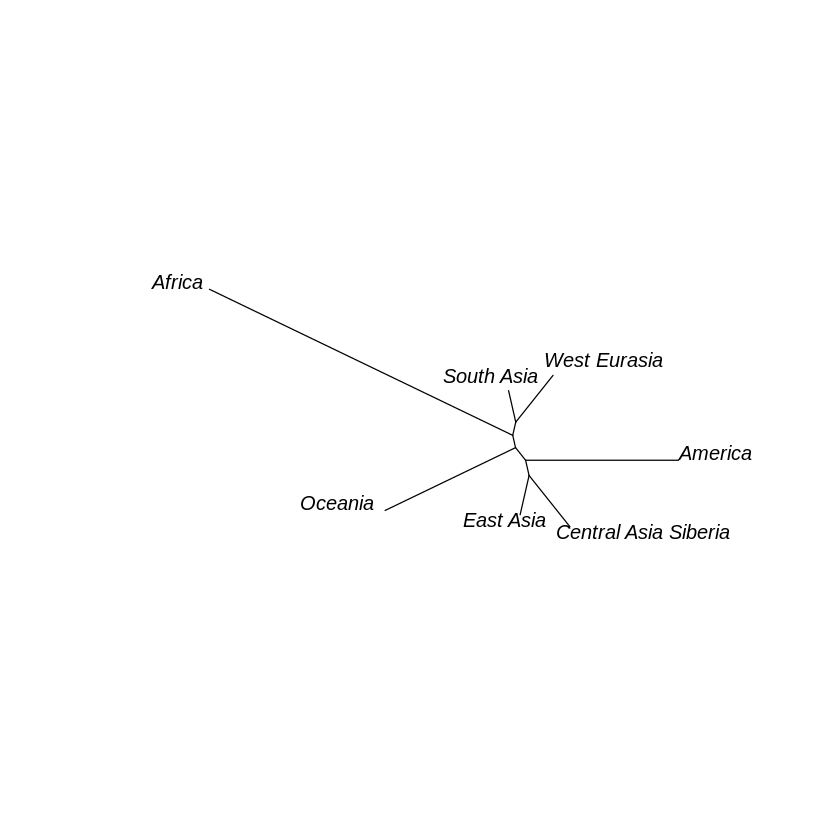

In [18]:
#Unrooted tree
plot(tree, 'u')

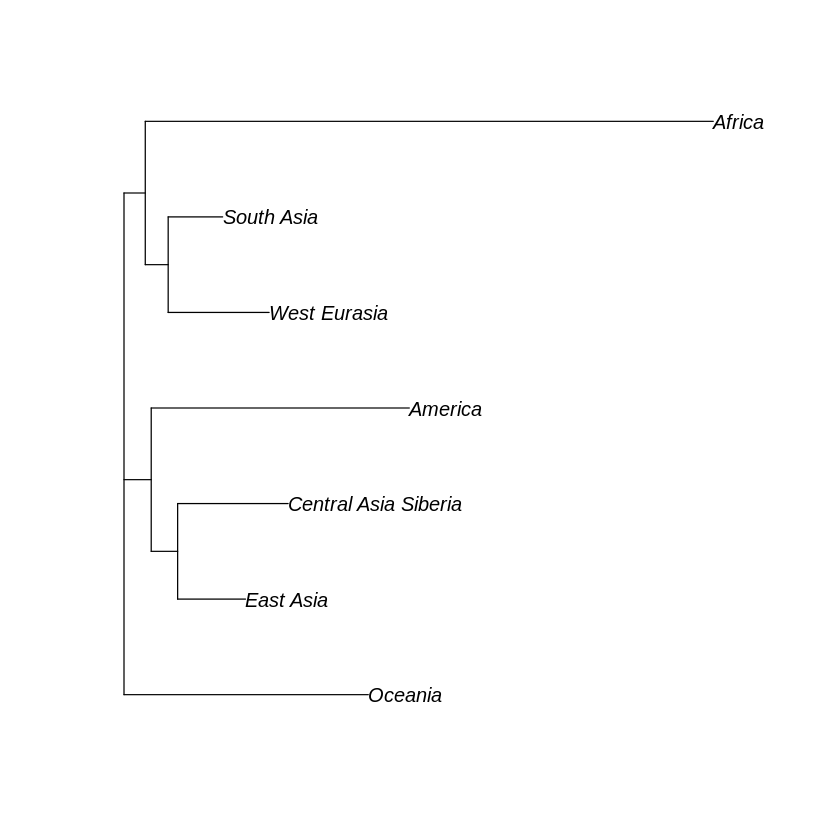

In [19]:
#Rooted tree 
plot(tree)

[1] "creating root"
[1] "checking if rooted"


[1] TRUE

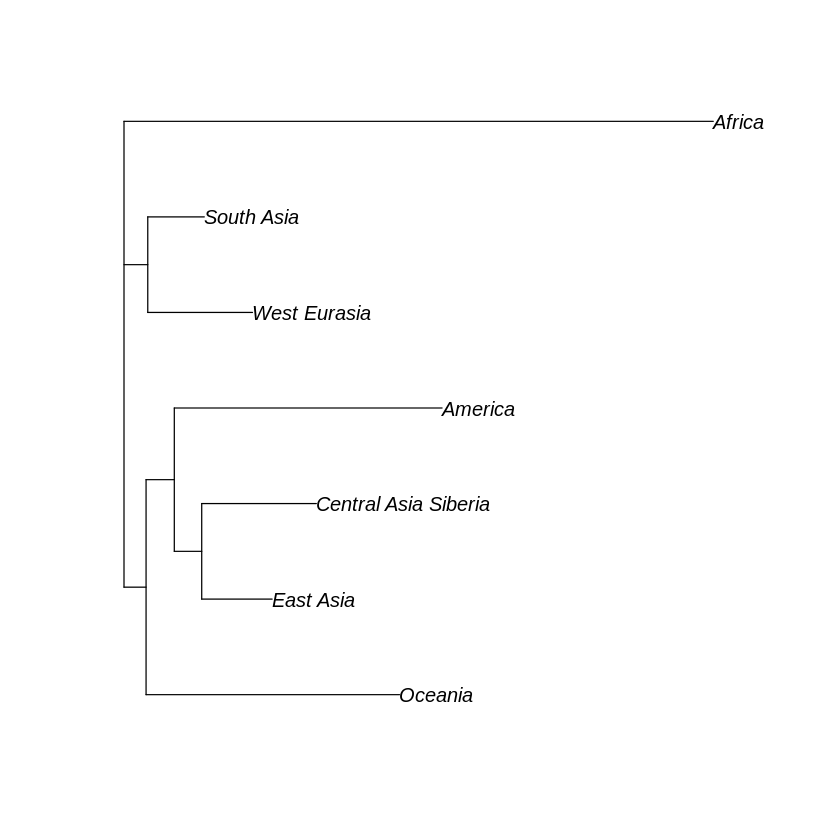

In [20]:
#Tree rooted with Africa
print("creating root")
tr  <- root(tree, "Africa")
tr$root.edge <- 0

print("checking if rooted")
is.rooted(tr)

plot(tr)


***Fst where NAs are removed***

In [4]:
#Function
fst_mean_rmNA <- function(fst_table, windowsize = 100){
    chr <- NULL
    begin_pos_SNP <- NULL
    end_pos_SNP <- NULL
    Fst_average <- NULL
    window <- windowsize-1
    
    for (i in 1:(nrow(SNPS) - window)){
        chr[i] = SNPS$chr[i]
        begin_pos_SNP[i] = SNPS$pos[i]
        end_pos_SNP[i] = SNPS$pos[i+window]
        SNPwindow <- fst_table %>% filter(between(pos, begin_pos_SNP[i], end_pos_SNP[i]))
        SNPwindow <- SNPwindow %>% drop_na()
        Fst_average[i] = mean(SNPwindow$Fst)
    }
    
    Fst <- tibble(chr = chr,
                  begin_pos_SNP = begin_pos_SNP,
                  end_pos_SNP = end_pos_SNP,
                  Fst_average = Fst_average)
    
    return(Fst)
}

In [6]:
Fst_mean_AF_WE_rmNA <- fst_mean_rmNA(Fst_AF_WE_per_pos)
print("Africa and West Eurasia")
head(Fst_mean_AF_WE_rmNA)
write.csv(Fst_mean_AF_WE_rmNA, "Fst_mean_AF_WE_rmNA.csv")


Fst_mean_WE_EA_rmNA <- fst_mean_rmNA(Fst_WE_EA_per_pos)
print("West Eurasia and East Asia")
head(Fst_mean_WE_EA_rmNA)
write.csv(Fst_mean_WE_EA_rmNA, "Fst_mean_WE_EA_rmNA.csv")

Fst_mean_EA_AF_rmNA <- fst_mean_rmNA(Fst_AF_EA_per_pos)
print("East Asia and Africa")
head(Fst_mean_EA_AF_rmNA)
write.csv(Fst_mean_EA_AF_rmNA, "Fst_mean_EA_AF_rmNA.csv")

[1] "East Asia and Africa"


chr,begin_pos_SNP,end_pos_SNP,Fst_average
<chr>,<int>,<int>,<dbl>
X,365712,452218,0.05087873
X,400000,452221,0.05087873
X,400108,452231,0.05063482
X,400132,454014,0.04670589
X,400148,454116,0.04556730
X,400303,454355,0.04556730


In [24]:
Fst_mean_AF_WE_rmNA <- read.csv("Fst_mean_AF_WE_rmNA.csv")
Fst_mean_AF_WE_rmNA <- Fst_mean_AF_WE_rmNA %>% mutate(region = rep("Africa_WestEurasia", nrow(Fst_mean_AF_WE_rmNA)))
Fst_mean_WE_EA_rmNA <- read.csv("Fst_mean_WE_EA_rmNA.csv")
Fst_mean_WE_EA_rmNA <- Fst_mean_WE_EA_rmNA %>% mutate(region = rep("WestEurasia_EastAsia", nrow(Fst_mean_WE_EA_rmNA)))
Fst_mean_EA_AF_rmNA <- read.csv("Fst_mean_EA_AF_rmNA.csv")
Fst_mean_EA_AF_rmNA <- Fst_mean_EA_AF_rmNA %>% mutate(region = rep("EastAsia_Africa", nrow(Fst_mean_EA_AF_rmNA)))

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,1,X,365712,452218,0.06035410,Africa_WestEurasia
2,2,X,400000,452221,0.06035410,Africa_WestEurasia
3,3,X,400108,452231,0.06083362,Africa_WestEurasia
4,4,X,400132,454014,0.05430005,Africa_WestEurasia
5,5,X,400148,454116,0.05320768,Africa_WestEurasia
6,6,X,400303,454355,0.05320768,Africa_WestEurasia


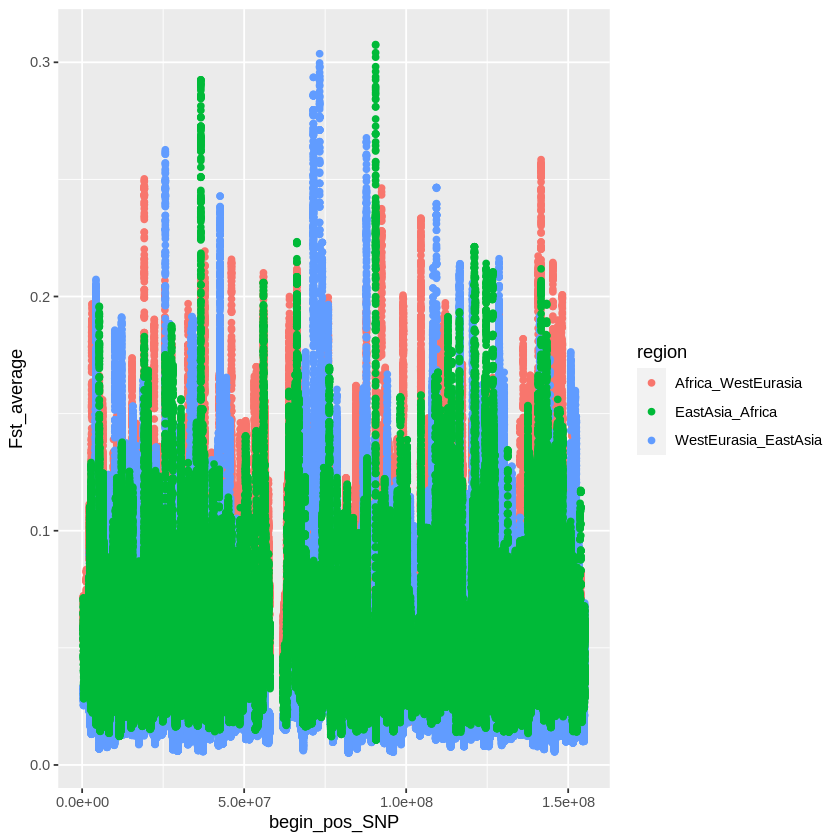

In [9]:
#Plot with the three populations combined:  
Fst_av_rmNA <- bind_rows(Fst_mean_AF_WE_rmNA, Fst_mean_WE_EA_rmNA, Fst_mean_EA_AF_rmNA)
head(Fst_av_rmNA)
plot1_rmNA <- ggplot(Fst_av_rmNA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average, color = region))
plot1_rmNA

[1] "Africa and West Eurasia"
[1] "West Eurasia and East Asia"


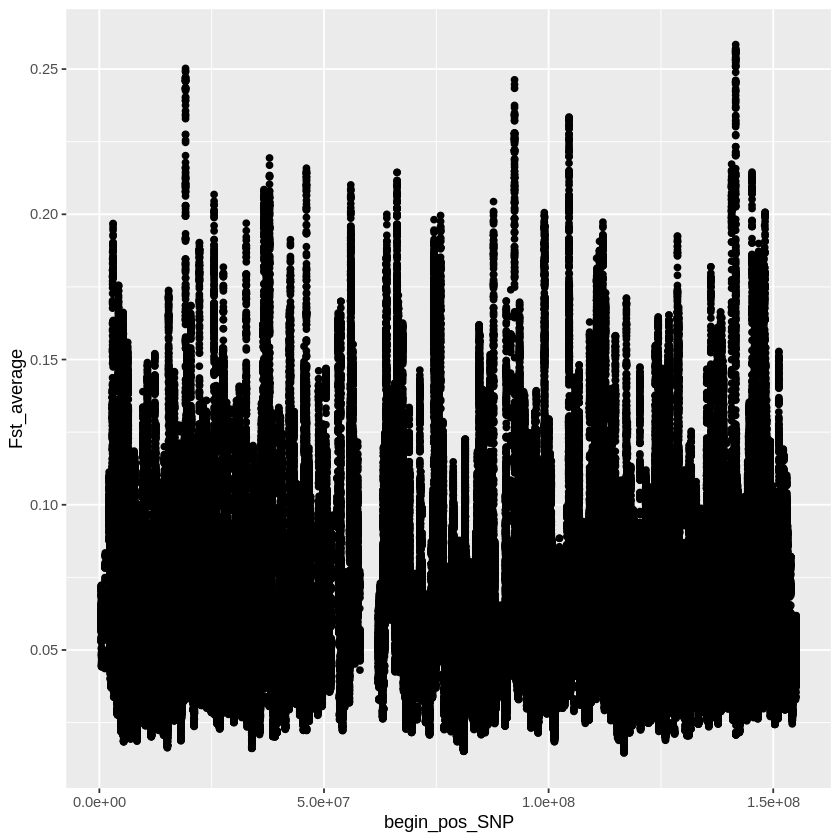

[1] "East Asia and Africa"


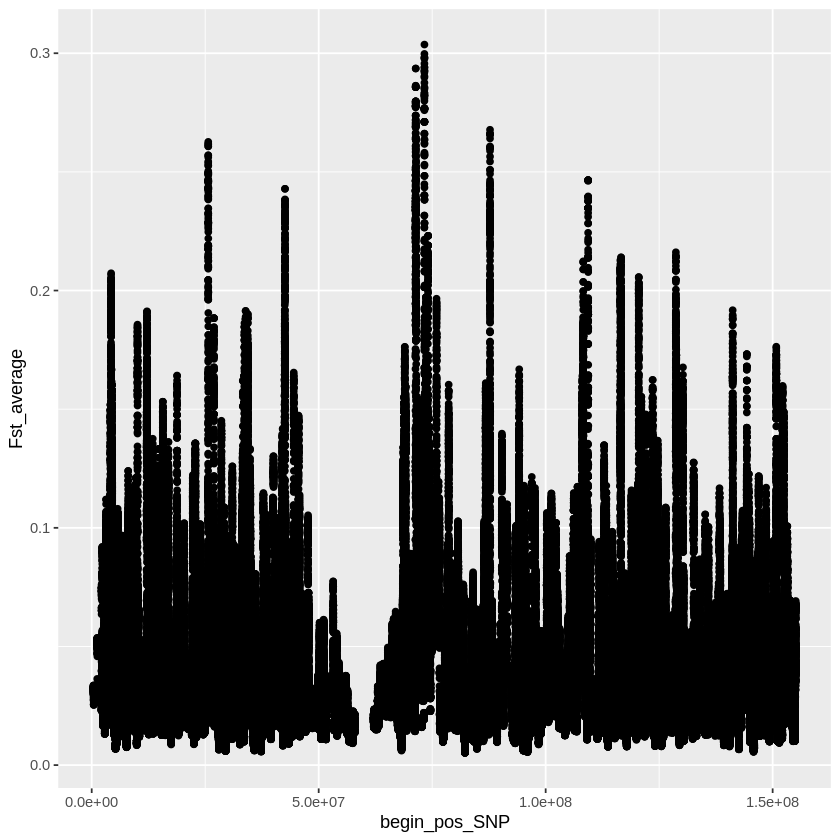

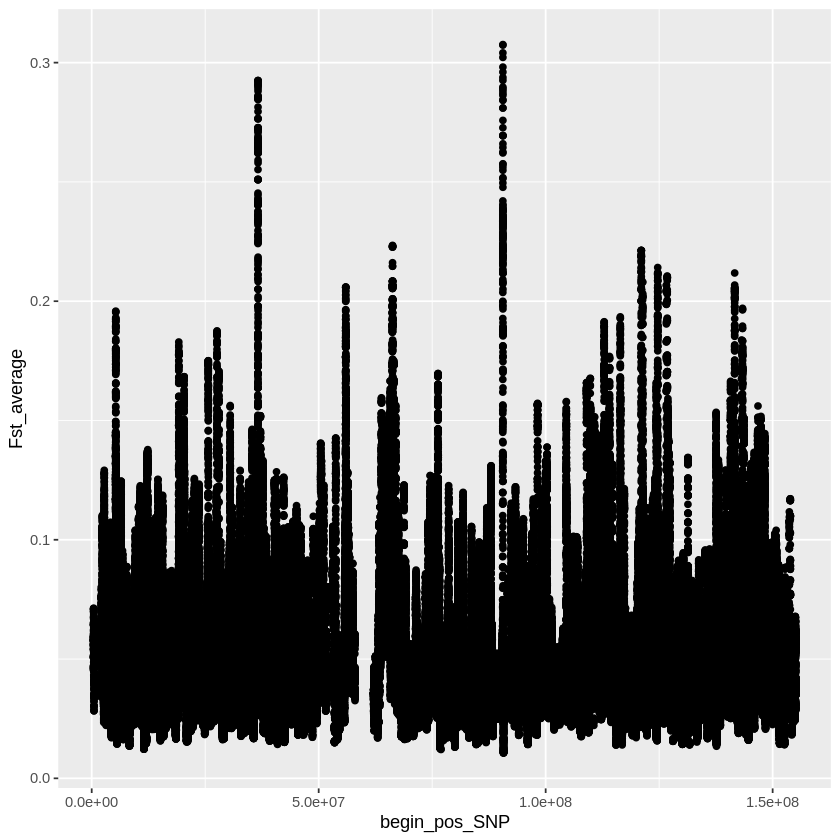

In [21]:
#Plots for one population at a time: 
par(mfrow=c(2,2))
print("Africa and West Eurasia")
plot_AF_WE_rmNA <- ggplot(Fst_mean_AF_WE_rmNA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_WE_rmNA

print("West Eurasia and East Asia")
plot_WE_EA_rmNA <- ggplot(Fst_mean_WE_EA_rmNA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_WE_EA_rmNA

print("East Asia and Africa")
plot_EA_AF_rmNA <- ggplot(Fst_mean_EA_AF_rmNA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_EA_AF_rmNA

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373278,X,141641747,141654883,0.2584422,Africa_WestEurasia
2,373277,X,141641500,141654874,0.2570901,Africa_WestEurasia
3,373275,X,141640842,141654384,0.2567489,Africa_WestEurasia
4,373276,X,141641044,141654801,0.2567489,Africa_WestEurasia
5,373266,X,141640132,141651286,0.2561760,Africa_WestEurasia
6,373267,X,141640245,141652006,0.2561438,Africa_WestEurasia


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,184161,X,73295813,73332575,0.3036630,WestEurasia_EastAsia
2,184151,X,73291592,73327904,0.2997258,WestEurasia_EastAsia
3,184162,X,73296100,73332626,0.2981860,WestEurasia_EastAsia
4,184165,X,73296751,73333994,0.2981456,WestEurasia_EastAsia
5,184160,X,73294978,73332135,0.2977003,WestEurasia_EastAsia
6,184152,X,73291611,73328353,0.2956250,WestEurasia_EastAsia


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


[1] "Africa and West Eurasia"


,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,373278,X,141641747,141654883,0.2584422,Africa_WestEurasia
2,373277,X,141641500,141654874,0.2570901,Africa_WestEurasia
3,373275,X,141640842,141654384,0.2567489,Africa_WestEurasia
4,373276,X,141641044,141654801,0.2567489,Africa_WestEurasia
5,373266,X,141640132,141651286,0.2561760,Africa_WestEurasia
6,373267,X,141640245,141652006,0.2561438,Africa_WestEurasia


[1] "West Eurasia and East Asia"


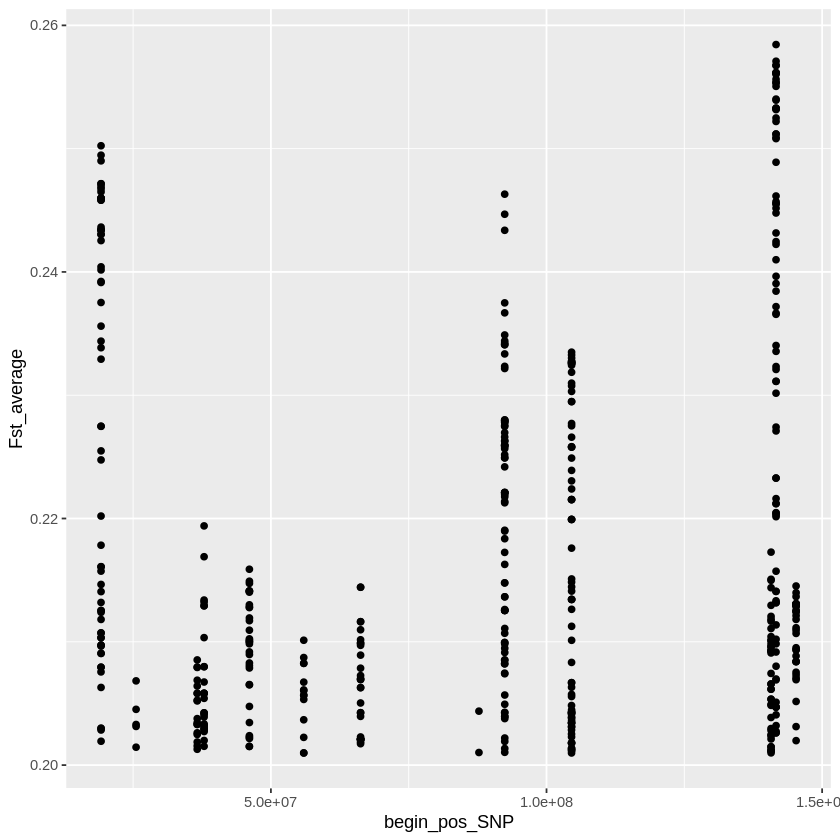

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,184161,X,73295813,73332575,0.3036630,WestEurasia_EastAsia
2,184151,X,73291592,73327904,0.2997258,WestEurasia_EastAsia
3,184162,X,73296100,73332626,0.2981860,WestEurasia_EastAsia
4,184165,X,73296751,73333994,0.2981456,WestEurasia_EastAsia
5,184160,X,73294978,73332135,0.2977003,WestEurasia_EastAsia
6,184152,X,73291611,73328353,0.2956250,WestEurasia_EastAsia


[1] "Africa and East Asia"


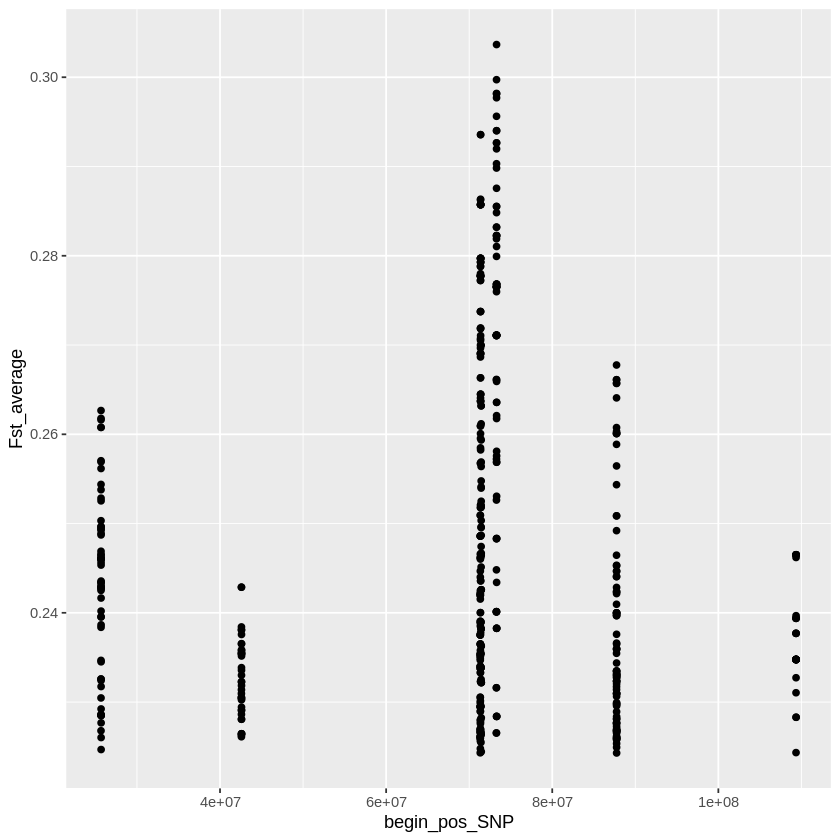

,X,chr,begin_pos_SNP,end_pos_SNP,Fst_average,region
,<int>,<chr>,<int>,<int>,<dbl>,<chr>
1,234372,X,90574931,90599747,0.3075771,EastAsia_Africa
2,234373,X,90576998,90599753,0.3073332,EastAsia_Africa
3,234371,X,90574684,90599622,0.3040935,EastAsia_Africa
4,234374,X,90577453,90600023,0.3021815,EastAsia_Africa
5,234375,X,90577681,90600277,0.2981373,EastAsia_Africa
6,234370,X,90574677,90599574,0.2960431,EastAsia_Africa


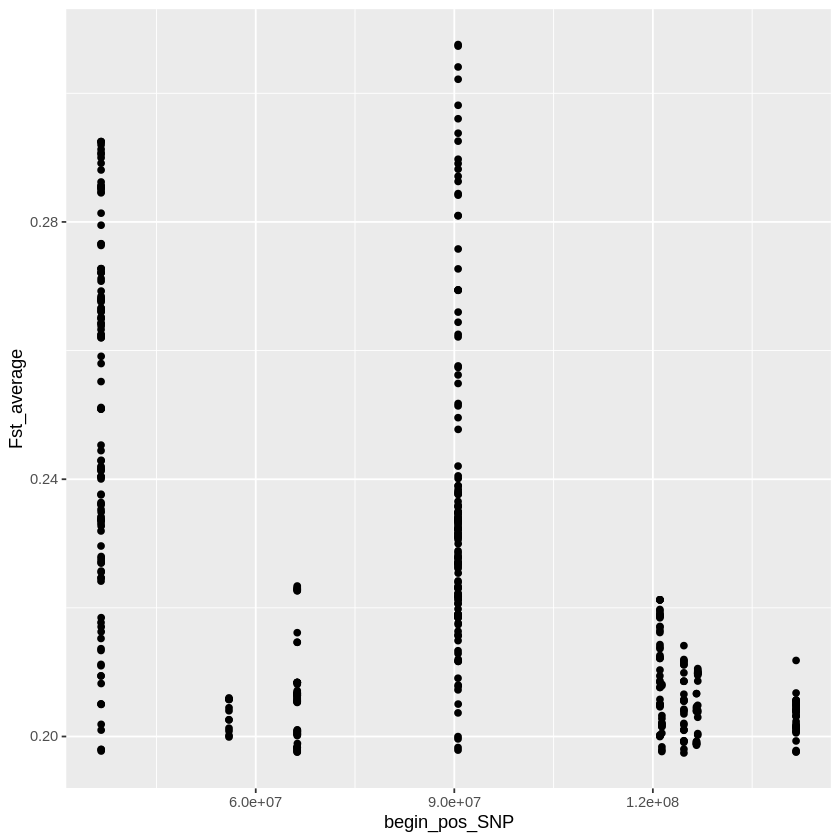

In [26]:
#Sorting the table according to the Fst values 
descending_order_AF_WErm_NA <- Fst_mean_AF_WE_rmNA %>% dplyr::arrange(desc(Fst_average))
head(descending_order_AF_WErm_NA)

descending_order_WE_EArm_NA <- Fst_mean_WE_EA_rmNA %>% dplyr::arrange(desc(Fst_average))
head(descending_order_WE_EArm_NA)

descending_order_AF_EArm_NA <- Fst_mean_EA_AF_rmNA %>% dplyr::arrange(desc(Fst_average))
head(descending_order_AF_EArm_NA)

#500 most extreme Fst values Africa and West Eurasia
plotdata_AF_WE_500rm_NA <- descending_order_AF_WErm_NA[1:500,]
print("Africa and West Eurasia")
plot_AF_WE_500rm_NA <- ggplot(plotdata_AF_WE_500rm_NA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_WE_500rm_NA
head(plotdata_AF_WE_500rm_NA)


AF_WE_beddata <- plotdata_AF_WE_500rm_NA %>% select(begin_pos_SNP, end_pos_SNP)
AF_WE_beddata <- AF_WE_beddata %>% mutate(chrom = rep('chrX', nrow(AF_WE_beddata))) 
AF_WE_beddata <- AF_WE_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_WE_beddata, "AF_WE_beddata_500rm_NA.bed", delim = "\t", col_names = FALSE)

#500 most extreme Fst values West Eurasia and East Asia
plotdata_WE_EA_500rm_NA <- descending_order_WE_EArm_NA[1:500,]
print("West Eurasia and East Asia")
plot_WE_EA_500rm_NA <- ggplot(plotdata_WE_EA_500rm_NA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_WE_EA_500rm_NA
head(plotdata_WE_EA_500rm_NA)


WE_EA_beddata <- plotdata_WE_EA_500rm_NA %>% select(begin_pos_SNP, end_pos_SNP)
WE_EA_beddata <- WE_EA_beddata %>% mutate(chrom = rep('chrX', nrow(WE_EA_beddata))) 
WE_EA_beddata <- WE_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(WE_EA_beddata, "WE_EA_beddata_500rm_NA.bed", delim = "\t", col_names = FALSE)

#500 most extreme Fst values Africa and East Asia
plotdata_AF_EA_500rm_NA <- descending_order_AF_EArm_NA[1:500,]
print("Africa and East Asia")
plot_AF_EA_500rm_NA <- ggplot(plotdata_AF_EA_500rm_NA)+ geom_point(aes(x = begin_pos_SNP, y= Fst_average))
plot_AF_EA_500rm_NA
head(plotdata_AF_EA_500rm_NA)


AF_EA_beddata <- plotdata_AF_EA_500rm_NA %>% select(begin_pos_SNP, end_pos_SNP)
AF_EA_beddata <- AF_EA_beddata %>% mutate(chrom = rep('chrX', nrow(AF_EA_beddata))) 
AF_EA_beddata <- AF_EA_beddata %>% select(chrom, begin_pos_SNP, end_pos_SNP)


write_delim(AF_EA_beddata, "AF_EA_beddata_500rm_NA.bed", delim = "\t", col_names = FALSE)



The intersection was done in the terminal. 

In [28]:
#Afrika and West Eurasia
print('Africa and West Eurasia 500')
AF_WE_500_rmNA <- read.csv('AF_WE_500_rmNA.bed', sep = '\t', header = FALSE)
AF_WE_500_rmNA  <- AF_WE_500_rmNA %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(AF_WE_500_rmNA)
genesAF_WE_500_rmNA <- unique(AF_WE_500_rmNA[c("V7")])
genesAF_WE_500_rmNA

#West Eurasia and East Asia
print('West Eurasia and East Asia 500')
WE_EA_500_rmNA <- read.csv('WE_EA_500_rmNA.bed', sep = '\t', header = FALSE)
WE_EA_500_rmNA  <- WE_EA_500_rmNA %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(WE_EA_500_rmNA)
genesWE_EA_500_rmNA <- unique(WE_EA_500_rmNA[c("V7")])
genesWE_EA_500_rmNA

#East Asia and Africa
print('East Asia and Africa 500')
EA_AF_500_rmNA <- read.csv('AF_EA_500_rmNA.bed', sep = '\t', header = FALSE)
EA_AF_500_rmNA  <- EA_AF_500_rmNA %>% filter(V8 != 0)  %>% distinct_at(vars(V1, V2, V3, V7), .keep_all = TRUE)
head(EA_AF_500_rmNA)
genesEA_AF_500_rmNA <- unique(EA_AF_500_rmNA[c("V7")])
genesEA_AF_500_rmNA

[1] "Africa and West Eurasia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,104547889,104573396,chrX,103810995,105011822,ENSG00000189108.12_3,25507
2,chrX,104548287,104574421,chrX,103810995,105011822,ENSG00000189108.12_3,26134
3,chrX,104551933,104578307,chrX,103810995,105011822,ENSG00000189108.12_3,26374
4,chrX,104548952,104574633,chrX,103810995,105011822,ENSG00000189108.12_3,25681
5,chrX,104549171,104575449,chrX,103810995,105011822,ENSG00000189108.12_3,26278
6,chrX,104552956,104578330,chrX,103810995,105011822,ENSG00000189108.12_3,25374


,V7
,<chr>
1,ENSG00000189108.12_3
33,ENSG00000147041.12_5
34,ENSG00000221466.2
35,ENSG00000250349.3_6
37,ENSG00000277215.1_5
74,ENSG00000214745.2_5
75,ENSG00000227486.1_6


[1] "West Eurasia and East Asia 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,73295813,73332575,chrX,73331513,73332169,ENSG00000230590.10_5,656
2,chrX,73295813,73332575,chrX,73325406,73327793,ENSG00000223650.1_4,2387
3,chrX,73291592,73327904,chrX,73321828,73321849,ENSG00000230590.10_5,21
4,chrX,73291592,73327904,chrX,73325406,73327793,ENSG00000223650.1_4,2387
5,chrX,73296100,73332626,chrX,73331513,73332169,ENSG00000230590.10_5,656
6,chrX,73296100,73332626,chrX,73325406,73327793,ENSG00000223650.1_4,2387


,V7
,<chr>
1,ENSG00000230590.10_5
2,ENSG00000223650.1_4
17,ENSG00000204131.9_5
18,ENSG00000225471.5_5
19,ENSG00000102309.13_5
20,ENSG00000239577.2
42,ENSG00000215933.1
85,ENSG00000225470.7_4
86,ENSG00000234969.1_5


[1] "East Asia and Africa 500"


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>
1,chrX,90563242,90584159,chrX,90562779,90563877,ENSG00000206062.4_5,635
2,chrX,90563281,90584340,chrX,90562779,90563877,ENSG00000206062.4_5,596
3,chrX,90563445,90584378,chrX,90562779,90563877,ENSG00000206062.4_5,432
4,chrX,90563535,90584555,chrX,90562779,90563877,ENSG00000206062.4_5,342
5,chrX,90562804,90583816,chrX,90562779,90563877,ENSG00000206062.4_5,1073
6,chrX,90563860,90584609,chrX,90562779,90563877,ENSG00000206062.4_5,17


,V7
,<chr>
1,ENSG00000206062.4_5
19,ENSG00000260683.1_5
31,ENSG00000280142.1_5
34,ENSG00000274631.1_5
38,ENSG00000214745.2_5
39,ENSG00000227486.1_6


Intersection of these results and the results from the analysis to check if the results when removing the NAs and setting them to be 0 are the same. 

In [34]:
AF_WE_intersect <- intersect(genesAF_WE_500, genesAF_WE_500_rmNA)
AF_WE_intersect

AF_EA_intersect <- intersect(genesEA_AF_500, genesEA_AF_500_rmNA)
AF_EA_intersect

WE_EA_intersect <- intersect(genesWE_EA_500, genesWE_EA_500_rmNA)
WE_EA_intersect

V7
<chr>
ENSG00000189108.12_3
ENSG00000277215.1_5
ENSG00000147041.12_5
ENSG00000221466.2
ENSG00000250349.3_6
ENSG00000214745.2_5
ENSG00000227486.1_6


V7
<chr>
ENSG00000206062.4_5
ENSG00000260683.1_5
ENSG00000280142.1_5
ENSG00000274631.1_5
ENSG00000214745.2_5
ENSG00000227486.1_6


V7
<chr>
ENSG00000230590.10_5
ENSG00000223650.1_4
ENSG00000264396.1
ENSG00000186871.7_5
ENSG00000102309.13_5
ENSG00000198034.11_3
ENSG00000225470.7_4
ENSG00000203397.2_5
ENSG00000234969.1_5


Intersection with the results from the XP-EHH analysis

In [31]:
Fst_XPEHH_AF_WE <- intersect(genesAF_WE_500_rmNA, genesAF_WE_XPEHH_500)
Fst_XPEHH_AF_WE

Fst_XPEHH_AF_EA <- intersect(genesEA_AF_500_rmNA, genesAF_EA_XPEHH_500)
Fst_XPEHH_AF_EA

Fst_XPEHH_WE_EA <- intersect(genesWE_EA_500_rmNA, genesWE_EA_XPEHH_500)
Fst_XPEHH_WE_EA

V7
<chr>


V7
<chr>


V7
<chr>
